<a href="https://colab.research.google.com/github/eisbetterthanpi/JEPA/blob/main/procgen_JEPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qq procgen faiss-cpu vector-quantize-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 630.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 4.7 MB/s eta 0:00:00


In [ ]:
# @title faiss
import faiss
import numpy as np

# d = 256 # dimension
# res = faiss.StandardGpuResources()  # use a single GPU
# nlist = 100
# m = 8
# index = faiss.IndexFlatL2(d) # no need train # 1-Flat.py
# index = faiss.IndexIVFFlat(index, d, nlist, faiss.METRIC_L2) # 2-IVFFlat.py
# # index = faiss.IndexIVFPQ(index, d, nlist, m, 8) # each sub-vector is encoded as 8 bits # 3-IVFPQ.py
# # index = faiss.index_cpu_to_gpu(res, 0, index) # 4-GPU.py
# # index = faiss.index_cpu_to_all_gpus(index) # 5-Multiple-GPUs.py


# import torch
# ltmk = torch.rand(1000,d)
# ltmv = torch.rand(1000,d)

def makefaissindex(vert_store):
    d = vert_store.shape[-1]
    nlist = 100
    index = faiss.IndexFlatL2(d) # no need train # 1-Flat.py
    index = faiss.IndexIVFFlat(index, d, nlist, faiss.METRIC_L2) # 2-IVFFlat.py
    if not index.is_trained: index.train(vert_store)
    index.add(vert_store)
    return index
# index = makefaissindex(ltmk)


def vecsearch(query, index, k=5, treshold=36): # k nearest neighbors
    # index.nprobe = 5 # 1
    D, I = index.search(query, k) # dist, idx
    D, I = D[0], I[0]
    mask = I[D<treshold]
    return mask

# import torch
# query = torch.rand(1,d)

# mask = vecsearch(query, index, k=5, treshold=37)
# print(mask)
# rag = ltmk[mask]
# print(rag)


# removing = torch.tensor([998, 769, 643])
# index.remove_ids(removing)



In [ ]:
# @title mem
import faiss
import pickle
import torch

class Stm():
    def __init__(self): # [batch_size, len_ltm, d_model]
        self.stmk, self.stmv = torch.tensor([], device=device), torch.tensor([], device=device)

    def __call__(self, query): # [batch_size, d_model]
        if len(self.stmk)==0: return torch.zeros((1), device=device)
        attn = query.unsqueeze(1) @ self.stmk.transpose(-1,-2) # [batch_size, 1, d_model] @ [batch_size, d_model, len_ltm] = [batch_size, 1, len_ltm]
        attention = torch.softmax(attn, dim=-1) # [batch_size, 1, len_ltm]
        x = attention @ self.stmv
        return x.squeeze(1) # [batch_size, d_model]

    def add(self, k, v): # [batch_size, 1, d_model]
        self.stmk = torch.cat([self.stmk, k], dim=1)
        self.stmv = torch.cat([self.stmv, v], dim=1)


class Mem():
    def __init__(self, batch_size=1):
        self.index = None
        self.ltmk, self.ltmv = torch.tensor([]), torch.tensor([])
        # self.stmk, self.stmv, self.meta = torch.tensor([]), torch.tensor([]), torch.tensor([])
        # self.ltmk, self.ltmv = torch.tensor([], device=device), torch.tensor([], device=device)
        self.stmk, self.stmv, self.meta = torch.tensor([], device=device), torch.tensor([], device=device), torch.tensor([], device=device)
        self.batch_size = batch_size

    def __call__(self, query, a=0.5):
        return a*self.Stm(query) + (1-a)*self.Ltm(query.cpu()).to(device)

    def Stm(self, query): # [1, d_model]
        if len(self.stmk)==0: return torch.zeros((1), device=device)
        attn = query @ self.stmk.T # [1, d_model] @ [d_model, len_ltm] = [1, len_ltm]
        attention = torch.softmax(attn, dim=-1) # [1, len_ltm]
        x = attention @ self.stmv # [1, len_ltm] @ [len_ltm, d_model] = [1, d_model]
        self.meta = self.meta + attn.squeeze(0) # attention # [len_ltm]
        return x # [1, d_model]

    def Ltm(self, query, k=5, treshold=36): # [batch_size, d_model] or [d_model]
        if self.index: rag = self.vecsearch(query, k, treshold)
        else: rag = self.ltmk
        if len(rag)==0: return torch.zeros(1)
        # print("ltm call", query.shape, rag.shape)
        attn = query @ rag.T # [1, d_model] @ [d_model, len_ltm] = [1, len_ltm]
        attention = torch.softmax(attn, dim=-1) # [1, len_ltm]
        x = attention @ rag
        return x # [1, d_model]

    def add(self, k, v): # [batch_size, d_model] or [d_model]
        # print("add", k.shape,self.stmk.shape)
        self.stmk = torch.cat([self.stmk, k], dim=0)
        self.stmv = torch.cat([self.stmv, v], dim=0)
        self.meta = torch.cat([self.meta, torch.ones((1), device=device)], dim=-1)
        if torch.rand(1)<0.1:
            self.pop()
            self.decay()

    def decay(self, g=0.9, k=256): # remove unimportant mem in stm
        self.meta = g*self.meta # decay
        mask = self.meta>0.001 # forget not retrieved
        self.stmk, self.stmv = self.stmk[mask], self.stmv[mask]
        self.meta = self.meta[mask]

        if len(self.meta)>k:
            topk = torch.topk(self.meta, k)#, dim=None, largest=True, sorted=True
            self.meta = topk.values # cap stm size
            self.stmk, self.stmv = self.stmk[topk.indices], self.stmv[topk.indices]

    def pop(self, t=5): # transfer from stm to ltm
        # if important long term, if
        mask = self.meta>t # to pop to ltm
        k, v = self.stmk[mask], self.stmv[mask]
        self.stmk, self.stmv = self.stmk[~mask], self.stmv[~mask] # remove from stm
        self.meta = self.meta[~mask]
        # print("pop", k.shape, self.ltmk.shape, k)
        k, v = k.cpu(), v.cpu()
        if k.ndim==1: k, v = k.unsqueeze(0), v.unsqueeze(0)
        self.ltmk = torch.cat([self.ltmk, k], dim=0) # add to ltm
        self.ltmv = torch.cat([self.ltmv, v], dim=0)
        if self.index:
            self.index.add(k)
            if torch.rand(1)<0.01:
                self.index.train(self.ltmk)
        else:
            if len(self.ltmk)>=100:
                self.index = makefaissindex(self.ltmk)

    def makefaissindex(self, vert_store):
        d = vert_store.shape[-1]
        nlist = 100
        index = faiss.IndexFlatL2(d) # no need train # 1-Flat.py
        index = faiss.IndexIVFFlat(index, d, nlist, faiss.METRIC_L2) # 2-IVFFlat.py
        if not index.is_trained: index.train(vert_store)
        index.add(vert_store)
        return index

    def vecsearch(self, query, k=5, treshold=36): # k nearest neighbors
        # index.nprobe = 5 # 1
        D, I = self.index.search(query, k) # dist, idx
        D, I = D[0], I[0]
        mask = I[D<treshold]
        rag = self.ltmk[mask] # [len_rag, d_model]
        return rag

    def remove_ids(self, removing): # torch.tensor indexes
        mask = torch.ones(len(self.ltmk), dtype=torch.bool)
        mask[removing] = False
        self.ltmk, self.ltmv = self.ltmk[mask], self.ltmv[mask]
        if self.index: self.index = makefaissindex(ltmk)

    def save(self, file='mem.pkl'):
        with open(file, 'wb') as f: pickle.dump((self.ltmk, self.ltmv, self.stmk, self.stmv, self.meta), f)

    def load(self, file='mem.pkl'):
        with open(file, 'rb') as f: self.ltmk, self.ltmv, self.stmk, self.stmv, self.meta = pickle.load(f)


In [ ]:
# @title resnet
import torch
import torch.nn as nn
from torchvision import models # https://pytorch.org/vision/0.12/models.html#id10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_res(dim_embd):
    model = models.resnet18(weights='DEFAULT') # 18 34 50 101 152
    num_ftrs = model.fc.in_features # 1000
    # model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
    model.layer4 = nn.Sequential()
    model.fc = nn.Sequential( # og
        # nn.Linear(num_ftrs, dim_embd, bias=None),
        # nn.Linear(512, dim_embd, bias=None),
        # nn.Softmax(dim=1),
        )
    return model

# print(get_res(256).to(device))
# model = get_res(256).to(device)
# input = torch.rand(16,3,64,64)
# input = torch.rand(16,1,256,256)
# out = model(input)
# print(out.shape)


In [2]:
# @title conv deconv
import torch
import torch.nn as nn

class Conv(torch.nn.Module):
    def __init__(self, d_model = 256):
        super().__init__()
        # d_list=[32, 64, 128, 256, 512, 1024] #
        d_list=[32, 64, 128, 256, 256, 256] #
        # d_list = [min(d, d_model) for d in d_list]
        self.cnn = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0), # SiLU ReLU
            nn.Conv2d(3, d_list[0], 7, 2, 3), nn.BatchNorm2d(d_list[0]), nn.ReLU(),
            nn.Conv2d(d_list[0], d_list[1], 5, 2, 2), nn.BatchNorm2d(d_list[1]), nn.ReLU(),
            nn.Conv2d(d_list[1], d_list[2], 3, 2, 1), nn.BatchNorm2d(d_list[2]), nn.ReLU(),
            nn.Conv2d(d_list[2], d_list[3], 3, 2, 1), nn.BatchNorm2d(d_list[3]), nn.ReLU(),
            nn.Conv2d(d_list[3], d_list[4], 3, 2, 1), nn.BatchNorm2d(d_list[4]), nn.ReLU(),
            # nn.Conv2d(d_list[4], d_list[5], 3, 2, 1), nn.ReLU(),
            nn.Flatten(start_dim=1),
            # nn.Linear(4*d_list[4],d_list[5]), nn.ReLU(),
            nn.Linear(4*d_list[4],d_model), nn.ReLU(),
        )
    def forward(self, x): return self.cnn(x)

class Deconv(torch.nn.Module):
    def __init__(self, d_model = 1024):
        super().__init__()
        # d_list=[32, 64, 128, 256, 512, 1024] #
        d_list=[32, 64, 128, 256, 256, 256] #
        # d_list = [min(d, d_model) for d in d_list]
        self.decoder = nn.Sequential(
            nn.Linear(d_model,4*d_list[4]), nn.ReLU(),
            # nn.Linear(d_list[5],4*d_list[4]), nn.ReLU(),
            nn.Unflatten(-1, (d_list[4],2,2)),
            # nn.Unflatten(-1, (d_list[5],1,1)),
            # nn.ConvTranspose2d(d_list[5], d_list[4], 3, 2, 1, output_padding=1), nn.BatchNorm2d(d_list[4]), nn.ReLU(),
            nn.ConvTranspose2d(d_list[4], d_list[3], 3, 2, 1, output_padding=1), nn.BatchNorm2d(d_list[3]), nn.ReLU(),
            nn.ConvTranspose2d(d_list[3], d_list[2], 3, 2, 1, output_padding=1), nn.BatchNorm2d(d_list[2]), nn.ReLU(),
            nn.ConvTranspose2d(d_list[2], d_list[1], 3, 2, 1, output_padding=1), nn.BatchNorm2d(d_list[1]), nn.ReLU(),
            nn.ConvTranspose2d(d_list[1], d_list[0], 5, 2, 2, output_padding=1), nn.BatchNorm2d(d_list[0]), nn.ReLU(),
            nn.ConvTranspose2d(d_list[0], 3, 7, 2, 3, output_padding=1),
        )
    def forward(self, x): return self.decoder(x)

# device = "cuda" if torch.cuda.is_available() else "cpu"
# conv = Conv().to(device)
# # print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683
# # input = torch.rand((4,1,256,256), device=device)
# out = conv(input)
# print(out.shape)

# conv = Deconv(256).to(device)
# # print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683
# input = torch.rand((4,256), device=device)
# out = conv(input)
# print(out.shape)


In [3]:
# @title vector quantize
# https://github.com/lucidrains/vector-quantize-pytorch?tab=readme-ov-file#finite-scalar-quantization
import torch
from vector_quantize_pytorch import FSQ
device = 'cuda' if torch.cuda.is_available() else 'cpu'
quantizer = FSQ(levels = [3,3,2]).to(device) # https://github.com/lucidrains/vector-quantize-pytorch/blob/master/vector_quantize_pytorch/finite_scalar_quantization.py

# # x = torch.randn(1, 1024, 3) # last dim is num levels
# x = torch.randn(4, 256, 3)*3 -1.5 # [batch_size, T, num_levels]
# xhat, indices = quantizer(x) # [batch_size, T, num_levels], [batch_size, T]
# # print(xhat[0])
# # print(indices[0])

# # assert torch.all(xhat == quantizer.indices_to_codes(indices))


In [ ]:
# @title intrinsic cost
import faiss
import torch

class ICost():
    def __init__(self, d_model, n=100):
        self.recent=[]
        # self.linmul = torch.linspace(0,1/n,n).unsqueeze(-1) # 1/n so that sum to 1
        self.linsx = torch.zeros((n, d_model), device=device)
        self.n = n
        self.p=(n-1)/n

    def boredom(self, lsx, linsx=None): # lsx: [len_seq, d_model]; for simulate only
        if linsx==None: linsx = self.linsx.clone()
        lsx, linsx = F.normalize(lsx, dim=-1), F.normalize(linsx, dim=-1)
        len_seq = lsx.shape[0]
        linsx = torch.cat([linsx, lsx], dim=0)
        weights = 1-self.p**torch.cat([torch.ones(self.n)*len_seq, torch.linspace(len_seq-1, 0, len_seq)], dim=0).float()
        idx = torch.multinomial(weights, len_seq)
        mask = torch.ones(self.n+len_seq, dtype=bool)
        mask[idx] = False
        linsx = linsx[mask]
        bore = (linsx[:-1]@lsx[-1].T).sum()/(self.n-1)
        return bore#.squeeze()

    def update(self, lsx): # lsx: []
        # self.linsx = torch.cat([lsx, self.linsx[:-lsx.shape[0]]], dim=0)
        lsx = F.normalize(lsx, dim=-1)
        len_seq = lsx.shape[0]
        linsx = torch.cat([self.linsx, lsx], dim=0)
        weights = 1-self.p**torch.cat([torch.ones(self.n)*len_seq, torch.linspace(len_seq-1, 0, len_seq)], dim=0).float()
        idx = torch.multinomial(weights, len_seq)
        mask = torch.ones(self.n+len_seq, dtype=bool)
        mask[idx] = False
        self.linsx = linsx[mask]


    # def curiousity(self, sx):
    #     lin= nn.Linear(d_model, 100)#, bias=False)
    #     with torch.no_grad():
    #         data=lin(data) # random projection
    #         data = F.normalize(data, dim=-1)

    #         n,d=10,2
    #         data=torch.rand(n,d)

    #         index = faiss.IndexFlatIP(d) # IndexFlatL2, IndexFlatIP
    #         index = faiss.IndexIDMap(index)
    #         ids=torch.arange(n)
    #         index.add_with_ids(data,ids)
    #         a=torch.rand(1,2)
    #         id=torch.tensor([0])
    #         index.remove_ids(id) # https://github.com/facebookresearch/faiss/wiki/Faiss-indexes#supported-operations
    #         index.add_with_ids(a,id)

    #         D, I = index.search(a, 20)
    #         D, I = index.search(sample, k) # estimate clusteredness using k nearest neighbors # dist, idx
    #         priority = (2**-D).sum(-1) # L2
    #         curious = 1-torch.clamp(priority, 0, 1)
    #         D.sum(-1)
    #         curious = 1-torch.clamp(, max=1) # IP


    # def __call__(self, st, a): # [batch_size, d_model]
    def __call__(self, x): # [batch_size, d_model**2]
        return 0

# pain, death, boredom, empathy


In [ ]:
# @title procgen
# https://github.com/openai/procgen
import gym
# env = gym.make("procgen:procgen-coinrun-v0")
# env = gym.make("procgen:procgen-coinrun-v0", start_level=0, num_levels=1)

# from procgen import ProcgenGym3Env
# env = ProcgenGym3Env(num=1, env_name="coinrun")

env_name="procgen:procgen-{}-v0".format("bigfish") # https://github.com/openai/procgen/blob/master/procgen/gym_registration.py#L29
# env = gym.make(env_name, use_sequential_levels=True, render_mode="rgb_array")
env = gym.make(env_name, use_sequential_levels=True, render_mode="rgb_array", use_backgrounds=False, restrict_themes=True, use_monochrome_assets=True)


ENV_NAMES = ["bigfish", "bossfight", "caveflyer", "chaser", "climber", "coinrun", "dodgeball", "fruitbot", "heist", "jumper", "leaper", "maze", "miner", "ninja", "plunder", "starpilot",]


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [13]:
# @title jepa
# https://openreview.net/pdf?id=BZ5a1r-kVsf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
device = "cuda" if torch.cuda.is_available() else "cpu"
# from torch.optim.swa_utils import AveragedModel, get_ema_multi_avg_fn, update_bn # https://pytorch.org/docs/stable/optim.html#putting-it-all-together-ema

def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

class JEPA(nn.Module):
    def __init__(self, in_dim, d_model, dim_a, dim_z, dim_v):
        super(JEPA, self).__init__()
        # self.enc = nn.Sequential(nn.Linear(in_dim, d_model), nn.ReLU(),)
        # self.enc = get_res(d_model)
        # # self.enc.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        # self.enc.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.enc = Conv(d_model)

        self.pred = nn.Sequential(
            nn.Linear(d_model+dim_a+dim_z, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model),
            )
        # self.pred = gru(emb_dim, rnn_units, num_layers)
        self.exp = nn.Sequential(
            nn.Linear(d_model, dim_v), nn.ReLU(),
            nn.Linear(dim_v, dim_v), nn.ReLU(),
            nn.Linear(dim_v, dim_v),# nn.ReLU(),
            )
        self.d_model = d_model
        self.dim_z = dim_z
        self.sim_coeff=10.0 # 25.0 # λ
        self.std_coeff=1.0 # 25.0 # µ
        self.cov_coeff=25.0 # 1.0 # ν
        self.z=torch.zeros((1,dim_z),device=device)
        # self.enc_ema = AveragedModel(self.enc, multi_avg_fn=get_ema_multi_avg_fn(0.999))
        # self.exp_ema = AveragedModel(self.exp, multi_avg_fn=get_ema_multi_avg_fn(0.999))

    def v_creg(self, x): # vx [batch_size, d_model]
        x = x - x.mean(dim=0)
        std_x = torch.sqrt(x.var(dim=0) + 0.0001) #ϵ=0.0001
        std_loss = torch.mean(F.relu(1 - std_x)) / 2
        batch_size, num_features = x.shape
        cov_x = (x.T @ x) / (batch_size - 1) #C(Z)
        cov_loss = off_diagonal(cov_x).pow_(2).sum().div(num_features)
        return self.std_coeff * std_loss, self.cov_coeff * cov_loss
        # return std_loss, cov_loss

    def argm(self, sx, a, sy, lr=1e5): # 3e3
        batch=sx.size(dim=0)
        z = nn.Parameter(torch.zeros((batch,self.dim_z),device=device))
        optim = torch.optim.SGD([z], lr=lr)
        lossfn = torch.nn.MSELoss()
        sx, a, sy = sx.detach(), a.detach(), sy.detach()
        num_steps = 5 # 10
        for i in range(num_steps):
            sxaz = torch.cat([sx, a, z], dim=-1)
            sy_ = self.pred(sxaz)
            # print("y_, y",y_.shape, y.shape)
            loss = lossfn(sy_, sy)
            loss.backward()
            optim.step()
            optim.zero_grad()
            # print("argm in",loss.item())
        # print(z.squeeze())
        if loss.item()>0.9: print("argm",loss.item(), torch.mean(abs(z.detach())).item())
        return z#.detach()

    def loss(self, x, y, a, z=None):
        sx, sy = self.enc(x), self.enc(y)
        z = self.argm(sx, a, sy)
        sxaz = torch.cat([sx, a, z], dim=-1)
        sy_ = self.pred(sxaz)
        repr_loss = self.sim_coeff * F.mse_loss(sy, sy_) # s(sy, sy~) # invariance loss
        # v_c_loss = self.v_creg(self.exp(sx))
        vx, vy = self.exp(sx), self.exp(sy)
        v_c_loss = self.v_creg(vx) + self.v_creg(vy)
        return repr_loss + v_c_loss

    def forward(self, sx, a): # state, ctrl
        batch=sx.size(dim=0)
        z=torch.zeros((batch,self.dim_z),device=device)
        sxaz = torch.cat([sx, a, z], dim=-1)
        sy_ = self.pred(sxaz)
        return sy_ # state1


# d_model=16
# dim_z= 1#-5
# dim_v=32
# dim_a=4
# model = JEPA(in_dim, d_model, dim_a, dim_z, dim_v).to(device)
# x=torch.rand(1, in_dimx)
# y=torch.rand(1, in_dimy)
# loss = model.loss(x,y)
# distance = torch.norm(embeddings.weight.data - my_sample, dim=-1)
# nearest = torch.argmin(distance)


In [ ]:
# @title agent
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
import torchvision.transforms as transforms
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()


class Agent(nn.Module):
    def __init__(self, d_model=256, dim_a=3, dim_z=1, dim_v=512):
        super().__init__()
        self.d_model = d_model
        self.dim_a, self.dim_z, self.dim_v = dim_a, dim_z, dim_v
        self.sense = get_res(d_model)
        self.sense.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.mem = Mem()
        self.world_state = torch.zeros((d_model, d_model), device=device) # Sum i] vi kiT
        self.jepa = JEPA(d_model**2, d_model, dim_a, dim_z, dim_v)
        # self.critic = GRU(
        # self.critic = nn.Sequential(
            # nn.Linear(d_model+dim_a, d_model), nn.ReLU(),
            # nn.Linear(d_model, d_model),
            # )
        # self.actor = nn.Sequential( # -> goal sx/ssx/sssx/...
        #     nn.Linear(d_model+dim_a, d_model), nn.ReLU(),
        #     nn.Linear(d_model, d_model),
        #     )
        self.icost = ICost(d_model) # intrinsic cost
        self.tcost = nn.Sequential( # trained cost
            # nn.Linear(d_model+dim_a, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, 1),
            )
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.k = nn.Linear(d_model, d_model, bias=False)
        self.v = nn.Linear(d_model, d_model, bias=False)
        self.quantizer = FSQ(levels = [3,3,2])
        self.conv = Conv()

    def forward(self, state): # live run in env # np (64, 64, 3)
        self.eval()
        with torch.no_grad():
            self.mem, self.world_state = self.get(state, self.mem, self.world_state)
            sx = self.jepa.enc(self.world_state.flatten()).unsqueeze(0)
            self.icost.update(sx)
        la, lact = self.search(sx, T=2) # 20
        # a, act = la[0][0], lact[0][0]
        # return act
        return lact[0]

    # def search(self, sx, T=256, bptt=32):
    def search(self, sx, T=None, bptt=None):
        if T==None: T = 256
        if bptt==None: bptt = min(T,32)
        batch=sx.size(dim=0)
        x = nn.Parameter(torch.rand((batch, T, 3),device=device)*2 -1) # FSQ 3 levels
        optim = torch.optim.SGD([x], lr=1e5)
        xx = torch.split(x, bptt, dim=1)
        for _ in range(5): # num epochs
            sx_ = sx.detach()
            for xxx in xx: # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
                la, lact = quantizer(x) # xhat, indices [batch_size, T, num_levels], [batch_size, T]
                loss, sx_ = self.rnn_pred(sx_, la)
                loss.backward()
                optim.step()
                optim.zero_grad()
                sx_ = sx_.detach()
        print("search",loss.item())
        return la, lact # [batch_size, T]

    def rnn_pred(self, sx, la, z=None, gamma=0.95): # [1, d_model], [seq_len, dim_a/z]
        batch, seq_len, dim_a = la.shape
        if z is None: z=torch.zeros((batch,self.dim_z),device=device) # average case?
        # z = self.jepa.argm(sx, a, sx_) # worst case
        # out=[]
        cost = 0
        lsx=sx
        # print("rnn pred",lsx[0][:5])
        for t in range(seq_len): # simple single layer
            a = la[:,t] # [1, dim_a]
            sxaz = torch.cat([sx, a, z], dim=-1)
            # sx = self.jepa.pred(sxaz)
            sx = sx + self.jepa.pred(sxaz)
            lsx = torch.cat([lsx, sx], dim=0)
            # print(lsx.requires_grad, sx.requires_grad)
            icost = 0.1*self.icost.boredom(lsx, linsx=None) # + self.icost(sx)
            # print(icost.requires_grad)
            tcost = self.tcost(sx)
            # cost += tcost + icost
            cost += (tcost + icost)*gamma**t
            # print("tcost icost", tcost.item(), icost.item())
            # out.append(sx)
        # out=torch.cat(out)
        # out = out[:, -1, :] # out: (n, 128)
        return cost, sx#, z

    def get(self, state, _mem=None, world_state=None): # update world_state and mem from state
        if _mem==None: _mem = self.mem
        if world_state==None: world_state = self.world_state
        # print("get", state.shape)
        current = self.sense(state) # [batch_size, d_model] or [1, d_model]
        # current = self.sense(state.unsqueeze(-1)) # [batch_size, d_model] or [1, d_model]
        Q = self.q(current) # [batch_size, d_model]
        # mem = _mem(Q) # _mem(current)
        obs = current# + mem # [batch_size, d_model]
        K, V = self.k(obs), self.v(obs) # [batch_size, d_model]
        # self.scale = torch.sqrt(torch.tensor((self.head_dim,), dtype=torch.float, device=device))
        # K, V = F.normalize(K, dim=-1), F.normalize(V, dim=-1)
        K = F.normalize(K, dim=-1)
        if V.shape[0]>1 and V.ndim==2: K, V = K.unsqueeze(1), V.unsqueeze(1) # [batch_size, 1, d_model]
        V_ = world_state @ K.transpose(-1,-2) # [batch_size, d_model, d_model] @ [batch_size, d_model, 1] = [batch_size, d_model, 1]
        world_state = world_state + (V.transpose(-1,-2) - V_) @ K#.T # -V_.K^T, + V.K^T # update world state
        # _mem.add(K, V) # [batch_size, 1, d_model] or [1, d_model]
        return _mem, world_state#, cost

    def train_jepa(self, dataloader, optim, bptt=32):
        self.train()
        for batch, Sar in enumerate(dataloader):
            _mem = Stm()
            world_state = torch.zeros((batch_size, self.d_model, self.d_model), device=device) # Sum i] vi kiT
            # sx_ = self.jepa.enc(world_state.flatten(start_dim=1))
            sx_ = self.jepa.enc(world_state.unsqueeze(1)) # [batch_size, 1, d_model, d_model]
            lst=list(range(0,len(Sar[0]),bptt))[1:]+[len(Sar[0])] # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
            loss=0
            c,c_= torch.tensor([], device=device), torch.tensor([], device=device)
            # print(lst,len(Sar[0]))
            for i, (state, action, reward) in enumerate(zip(*Sar)):
                state, action, reward = state.to(device), action.to(device), reward.to(device)
                with torch.cuda.amp.autocast(): # automatic mixed percision
                    _mem, world_state_ = self.get(state, _mem, world_state)
                    # sy = self.jepa.enc(world_state_.flatten(start_dim=1)) # [batch_size, d_model]
                    # print("train jepa world_state_", world_state_) # 8.2697 # 2.0750e-11
                    sy = self.jepa.enc(world_state_.unsqueeze(1)) # [batch_size, d_model]
                    # sy = self.jepa.enc_ema(world_state_.flatten(start_dim=1)) # [batch_size, d_model]
                    a = self.quantizer.indices_to_codes(action)
                    z = self.jepa.argm(sx_, a, sy)
                    sxaz = torch.cat([sx_, a, z], dim=-1)
                    # sy_ = self.jepa.pred(sxaz)
                    sy_ = sx_ + self.jepa.pred(sxaz)
                    # print("train jepa sy_", sy_) # 11.7910 # 1.3963e-06
                    # repr_loss = self.jepa.sim_coeff * F.mse_loss(sy, sy_) # s(sy, sy~) # invariance loss
                    repr_loss = self.jepa.sim_coeff * F.mse_loss(sy.detach(), sy_) # s(sy, sy~) # invariance loss
                    std_loss, cov_loss = self.jepa.v_creg(self.jepa.exp(sy))
                    jloss = repr_loss + std_loss + cov_loss
                    # c_ = torch.cat([c_, self.tcost(sy_).squeeze(-1)]) # [batch_size, 1] -> [batch_size]
                    # c = torch.cat([c, self.icost(sy) + reward.to(torch.float32)])
                    # with torch.no_grad(): c = torch.cat([c, self.icost(sy.detach()) + reward.to(torch.float32)])

                    state_ = self.conv(world_state_.detach())
                    conv_loss = F.mse_loss(state_, state)
                    loss = loss + jloss + conv_loss

                if i+1 in lst:
                    # print(c_)
                    # print(c)
                    # closs=F.l1_loss(c_, c) # mse_loss, l1_loss
                    # print("repr, std, cov, closs", repr_loss.item(), std_loss.item(), cov_loss.item(), closs.item())
                    print("repr, std, cov", repr_loss.item(), std_loss.item(), cov_loss.item())
                    # loss = loss + 100*closs
                    # loss.backward()
                    # optim.step()
                    scaler.scale(loss).backward()
                    scaler.step(optim)
                    scaler.update()
                    optim.zero_grad()
                    world_state = world_state_.detach()
                    sx_ = sx_.detach()
                    loss=0
                    c,c_= torch.tensor([], device=device), torch.tensor([], device=device)
                else:
                    scaler.scale(jloss).backward(retain_graph=True)

                try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "closs": closs.item()})
                except: pass
                # if batch % 100 == 0:
                #     loss, current = loss.item(), batch * len(X)
                #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        # model.conv_ema.update_parameters(model.conv)


    # def save(self, folder, name='agent.pth'):
    #     torch.save(self.state_dict(), folder+name)
    #     self.mem.save(file=folder+name)
    # def load(self, folder, name='agent.pth'):
    #     self.load_state_dict(torch.load(folder+name), strict=False)
    #     # self.mem.load(file=folder+name)


# lsx, lc
# self.tcost(sx).squeeze(-1)
# self.icost(sx_) + reward.to(torch.float32)
#                     closs=F.l1_loss(c_, c) # mse_loss, l1_loss


agent = Agent().to(device)
optim = torch.optim.AdamW(agent.parameters(), 1e-3, (0.9, 0.95)) # lr = 1e-4 #3e-4

tcost_params = [p for name, p in agent.named_parameters() if 'tcost' in name]
others = [p for name, p in agent.named_parameters() if 'tcost' not in name]
optim = torch.optim.AdamW([{'params': others, 'lr': 1e-3},
    {'params': tcost_params, 'lr': 1e-2}], betas=(0.9, 0.95))



# print(sum(p.numel() for p in agent.parameters() if p.requires_grad)) # 28488545
# dreamer v3 https://arxiv.org/pdf/2301.04104 https://vitalab.github.io/article/2023/01/19/DreamerV3.html


In [14]:
# @title agent pixel
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
import torchvision.transforms as transforms
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()

# repr, std, cov, conv, closs 0.27005431056022644 0.483642578125 0.0035182805731892586 0.06618960946798325 0.25528329610824585
# repr, std, cov, conv, closs 3.6650214195251465 0.474609375 0.0056321267038583755 0.020390193909406662 0.26914650201797485

sim_coeff, std_coeff, cov_coeff = 0.03,0.5,0.1 # 0.08, 0.48, 0.004 # 0.005 0.42 0.024
class Agent(nn.Module):
    def __init__(self, d_model=256, dim_a=3, dim_z=1, dim_v=512):
        super().__init__()
        self.d_model = d_model
        self.dim_a, self.dim_z, self.dim_v = dim_a, dim_z, dim_v
        self.jepa = JEPA(d_model**2, d_model, dim_a, dim_z, dim_v)
        # self.icost = ICost(d_model) # intrinsic cost
        self.tcost = nn.Sequential( # trained cost
            # nn.Linear(d_model+dim_a, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, 1),
            )
        self.quantizer = FSQ(levels = [3,3,2])
        self.deconv = Deconv(d_model)
        self.jepa.sim_coeff=10.0 # 25.0 # λ repr Invariance reconstruction, ->0 slowly
        self.jepa.std_coeff=1.0 # 25.0 # µ std Variance
        self.jepa.cov_coeff=100.0 # 1.0 # ν cov Covariance

    def forward(self, state): # live run in env # np (64, 64, 3)
        self.eval()
        with torch.no_grad():
            sx = self.jepa.enc(state).unsqueeze(0)
            self.icost.update(sx)
        la, lact = self.search(sx, T=2) # 20
        return lact[0]

    # def search(self, sx, T=256, bptt=32):
    def search(self, sx, T=None, bptt=None):
        if T==None: T = 256
        if bptt==None: bptt = min(T,32)
        batch=sx.size(dim=0)
        x = nn.Parameter(torch.rand((batch, T, 3),device=device)*2 -1) # FSQ 3 levels
        optim = torch.optim.SGD([x], lr=1e5)
        xx = torch.split(x, bptt, dim=1)
        for _ in range(5): # num epochs
            sx_ = sx.detach()
            for xxx in xx: # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
                la, lact = quantizer(x) # xhat, indices [batch_size, T, num_levels], [batch_size, T]
                loss, sx_ = self.rnn_pred(sx_, la)
                loss.backward()
                optim.step()
                optim.zero_grad()
                sx_ = sx_.detach()
        print("search",loss.item())
        return la, lact # [batch_size, T]

    def rnn_pred(self, sx, la, z=None, gamma=0.95): # [1, d_model], [seq_len, dim_a/z]
        batch, seq_len, dim_a = la.shape
        if z is None: z=torch.zeros((batch,self.dim_z),device=device) # average case?
        # z = self.jepa.argm(sx, a, sx_) # worst case
        # out=[]
        cost = 0
        lsx=sx
        # print("rnn pred",lsx[0][:5])
        for t in range(seq_len): # simple single layer
            a = la[:,t] # [1, dim_a]
            sxaz = torch.cat([sx, a, z], dim=-1)
            # sx = self.jepa.pred(sxaz)
            sx = sx + self.jepa.pred(sxaz)
            lsx = torch.cat([lsx, sx], dim=0)
            # print(lsx.requires_grad, sx.requires_grad)
            icost = 0.1*self.icost.boredom(lsx, linsx=None) # + self.icost(sx)
            # print(icost.requires_grad)
            tcost = self.tcost(sx)
            # cost += tcost + icost
            cost += (tcost + icost)*gamma**t
            # print("tcost icost", tcost.item(), icost.item())
            # out.append(sx)
        # out=torch.cat(out)
        # out = out[:, -1, :] # out: (n, 128)
        return cost, sx#, z

    def train_jepa(self, dataloader, optim, bptt=32):
        self.train()
        global sim_coeff, std_coeff, cov_coeff
        for batch, Sar in enumerate(dataloader):
            lst=list(range(0,len(Sar[0]),bptt))[1:]+[len(Sar[0])] # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
            loss=0
            c,c_= torch.tensor([], device=device), torch.tensor([], device=device)
            # print(lst,len(Sar[0]))
            state = torch.rand((batch_size, 3,64,64), device=device)
            sx_ = self.jepa.enc(state) # [batch_size, d_model]
            for i, (state, action, reward) in enumerate(zip(*Sar)):
                state, action, reward = state.to(device), action.to(device), reward.to(device)
                with torch.cuda.amp.autocast(): # automatic mixed percision
                    # print("train jepa world_state_", world_state_) # 8.2697 # 2.0750e-11
                    sy = self.jepa.enc(state) # [batch_size, d_model]
                    # sy = self.jepa.enc_ema(world_state_.flatten(start_dim=1)) # [batch_size, d_model]
                    a = self.quantizer.indices_to_codes(action)
                    z = self.jepa.argm(sx_, a, sy)
                    sxaz = torch.cat([sx_, a, z], dim=-1)
                    sy_ = self.jepa.pred(sxaz)
                    # sy_ = sx_ + self.jepa.pred(sxaz)
                    # print("train jepa sy_", sy_) # 11.7910 # 1.3963e-06
                    # repr_loss = self.jepa.sim_coeff * F.mse_loss(sy, sy_) # s(sy, sy~) # invariance loss
                    repr_loss = self.jepa.sim_coeff * F.mse_loss(sy.detach(), sy_) # s(sy, sy~) # invariance loss
                    # repr_loss = F.mse_loss(sy.detach(), sy_) # s(sy, sy~) # invariance loss
                    std_loss, cov_loss = self.jepa.v_creg(self.jepa.exp(sy))
                    jloss = repr_loss + std_loss + cov_loss

                    decay=0.999
                    sim_coeff, std_coeff, cov_coeff = sim_coeff*decay + (1-decay)*repr_loss.detach(), std_coeff*decay + (1-decay)*std_loss.detach(), cov_coeff*decay + (1-decay)*cov_loss.detach()

                    step=0.01
                    if repr_loss.detach()>sim_coeff: self.jepa.sim_coeff=self.jepa.sim_coeff*(1+step)
                    if std_loss.detach()>std_coeff: self.jepa.std_coeff=self.jepa.std_coeff*(1+step)
                    if cov_loss.detach()>cov_coeff: self.jepa.cov_coeff=self.jepa.cov_coeff*(1+step)
                    self.jepa.sim_coeff, self.jepa.std_coeff = self.jepa.sim_coeff/self.jepa.cov_coeff, self.jepa.std_coeff/self.jepa.cov_coeff
                    self.jepa.cov_coeff = 1.

                    c_ = torch.cat([c_, self.tcost(sy_).squeeze(-1)]) # [batch_size, 1] -> [batch_size]
                    # c = torch.cat([c, self.icost(sy) + reward.to(torch.float32)])
                    with torch.no_grad(): c = torch.cat([c, self.icost(sy.detach()) + reward.to(torch.float32)])

                    state_ = self.deconv(sy.detach())
                    # state_ = self.deconv(sy)
                    tsmall = torch.nn.Sequential(transforms.Resize((32,32)), transforms.Grayscale(1))
                    # conv_loss = F.mse_loss(state_, state)
                    conv_loss = F.mse_loss(state_, tsmall(state))
                    # loss = jloss + conv_loss


                    loss = loss + jloss + conv_loss

                if i+1 in lst:
                    # print(c_)
                    # print(c)
                    closs=F.l1_loss(c_, c) # mse_loss, l1_loss
                    # print("repr, std, cov, closs", repr_loss.item(), std_loss.item(), cov_loss.item(), closs.item())
                    # print("repr, std, cov", repr_loss.item(), std_loss.item(), cov_loss.item())
                    # print("repr, std, cov, conv", repr_loss.item(), std_loss.item(), cov_loss.item(), conv_loss.item())
                    print("repr, std, cov, conv, closs", repr_loss.item(), std_loss.item(), cov_loss.item(), conv_loss.item(), closs.item())
                    loss = loss + 100*closs
                    # loss.backward()
                    # optim.step()
                    print(self.jepa.sim_coeff, self.jepa.std_coeff, self.jepa.cov_coeff)
                    scaler.scale(loss).backward()
                    scaler.step(optim)
                    scaler.update()
                    optim.zero_grad()
                    sx_ = sx_.detach()
                    loss=0
                    c,c_= torch.tensor([], device=device), torch.tensor([], device=device)
                else:
                    scaler.scale(jloss).backward(retain_graph=True)

                # try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "closs": closs.item()})
                try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "conv": conv_loss.item()})
                except: pass
                # if batch % 100 == 0:
                #     loss, current = loss.item(), batch * len(X)
                #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        # model.conv_ema.update_parameters(model.conv)



    def train_ae(self, dataloader, optim, bptt=32):
        self.train()
        for batch, Sar in enumerate(dataloader):
            # state = torch.rand((batch_size, 3,64,64), device=device)
            # sx_ = self.jepa.enc(state) # [batch_size, d_model]
            for i, (state, action, reward) in enumerate(zip(*Sar)):
                state, action, reward = state.to(device), action.to(device), reward.to(device)
                with torch.cuda.amp.autocast(): # automatic mixed percision
                    # print("train jepa world_state_", world_state_) # 8.2697 # 2.0750e-11
                    sy = self.jepa.enc(state) # [batch_size, d_model]
                    # sy = self.jepa.enc_ema(world_state_.flatten(start_dim=1)) # [batch_size, d_model]

                    # std_loss, cov_loss = self.jepa.v_creg(self.jepa.exp(sy))
                    # jloss = std_loss + cov_loss

                    # state_ = self.deconv(sy.detach()) # pure jepa
                    state_ = self.deconv(sy) # ae
                    # tsmall = torch.nn.Sequential(transforms.Resize((32,32)), transforms.Grayscale(1))

                    conv_loss = F.mse_loss(state_, state)
                    # conv_loss = F.mse_loss(state_, tsmall(state))
                    # loss = jloss + conv_loss
                    loss = conv_loss

                    # print("std, cov, conv", std_loss.item(), cov_loss.item(), conv_loss.item())
                    print("loss", loss.item())
                    scaler.scale(loss).backward()
                    scaler.step(optim)
                    scaler.update()
                    optim.zero_grad()
                    # sx_ = sx_.detach()

                # try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "closs": closs.item()})
                try: wandb.log({"std": std_loss.item(), "cov": cov_loss.item(), "conv": conv_loss.item()})
                except: pass


    def train_jepa(self, dataloader, c_loader, optim, bptt=32):
        self.train()
        global sim_coeff, std_coeff, cov_coeff
        trainiter = iter(c_loader)
        for batch, Sar in enumerate(dataloader):
            lst=list(range(0,len(Sar[0]),bptt))[1:]+[len(Sar[0])] # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
            loss=0
            c,c_= torch.tensor([], device=device), torch.tensor([], device=device)
            state = torch.rand((batch_size, 3,64,64), device=device)
            sx_ = self.jepa.enc(state) # [batch_size, d_model]
            for i, (state, action, reward) in enumerate(zip(*Sar)):
                state, action, reward = state.to(device), action.to(device), reward.to(device)
                with torch.cuda.amp.autocast(): # automatic mixed percision
                    # print("train jepa world_state_", world_state_) # 8.2697 # 2.0750e-11
                    sy = self.jepa.enc(state) # [batch_size, d_model]
                    # sy = self.jepa.enc_ema(world_state_.flatten(start_dim=1)) # [batch_size, d_model]
                    a = self.quantizer.indices_to_codes(action)
                    z = self.jepa.argm(sx_, a, sy)
                    sxaz = torch.cat([sx_, a, z], dim=-1)
                    sy_ = self.jepa.pred(sxaz)
                    # sy_ = sx_ + self.jepa.pred(sxaz)
                    # print("train jepa sy_", sy_) # 11.7910 # 1.3963e-06
                    # repr_loss = self.jepa.sim_coeff * F.mse_loss(sy, sy_) # s(sy, sy~) # invariance loss
                    repr_loss = self.jepa.sim_coeff * F.mse_loss(sy.detach(), sy_) # s(sy, sy~) # invariance loss
                    # repr_loss = F.mse_loss(sy.detach(), sy_) # s(sy, sy~) # invariance loss
                    std_loss, cov_loss = self.jepa.v_creg(self.jepa.exp(sy))
                    # std_loss, cov_loss = self.jepa.v_creg(self.jepa.exp(sy_))
                    jloss = repr_loss + std_loss + cov_loss

                    decay=0.999
                    sim_coeff, std_coeff, cov_coeff = sim_coeff*decay + (1-decay)*repr_loss.detach(), std_coeff*decay + (1-decay)*std_loss.detach(), cov_coeff*decay + (1-decay)*cov_loss.detach()
                    step=0.0001
                    if repr_loss.detach()>sim_coeff: self.jepa.sim_coeff=self.jepa.sim_coeff*(1+step)
                    if std_loss.detach()>std_coeff: self.jepa.std_coeff=self.jepa.std_coeff*(1+step)
                    if cov_loss.detach()>cov_coeff: self.jepa.cov_coeff=self.jepa.cov_coeff*(1+step)
                    self.jepa.sim_coeff, self.jepa.std_coeff = self.jepa.sim_coeff/self.jepa.cov_coeff, self.jepa.std_coeff/self.jepa.cov_coeff
                    self.jepa.cov_coeff = 1.


                    # # c_ = torch.cat([c_, self.tcost(sy_).squeeze(-1)]) # [batch_size, 1] -> [batch_size]
                    # c_ = torch.cat([c_, self.tcost(sy).squeeze(-1)]) # [batch_size, 1] -> [batch_size]
                    # # c = torch.cat([c, self.icost(sy) + reward.to(torch.float32)])
                    # with torch.no_grad(): c = torch.cat([c, self.icost(sy.detach()) + reward.to(torch.float32)])

                    # # ae loss
                    state_ = self.deconv(sy)
                    # state_ = self.deconv(sy.detach())
                    conv_loss = F.mse_loss(state_, state)
                    # # tsmall = torch.nn.Sequential(transforms.Resize((32,32)), transforms.Grayscale(1))
                    # # conv_loss = F.mse_loss(state_, tsmall(state))
                    # # loss = jloss + conv_loss


                    loss = loss + jloss + conv_loss

                if i+1 in lst:

                    try:
                        st, r = next(trainiter)
                    except StopIteration:
                        st, r = next(trainiter)
                        trainiter = iter(c_loader)
                    # st, r = st.to(device), r.to(device).squeeze(-1)
                    st, r = st.to(device), torch.tensor(r, device=device, dtype=torch.float).squeeze(-1)
                    closs = F.mse_loss(self.tcost(self.jepa.enc(st)), r)

                    # closs=F.l1_loss(c_, c) # mse_loss, l1_loss
                    # print("repr, std, cov, closs", repr_loss.item(), std_loss.item(), cov_loss.item(), closs.item())
                    # print("repr, std, cov", repr_loss.item(), std_loss.item(), cov_loss.item())
                    # print("repr, std, cov, conv", repr_loss.item(), std_loss.item(), cov_loss.item(), conv_loss.item())
                    print("repr, std, cov, conv, closs", repr_loss.item(), std_loss.item(), cov_loss.item(), conv_loss.item(), closs.item())
                    loss = loss + closs
                    # loss.backward()
                    # optim.step()
                    print(self.jepa.sim_coeff, self.jepa.std_coeff, self.jepa.cov_coeff)
                    scaler.scale(loss).backward()
                    scaler.step(optim)
                    scaler.update()
                    optim.zero_grad()
                    sx_ = sx_.detach()
                    loss=0
                    # c,c_= torch.tensor([], device=device), torch.tensor([], device=device)
                # else:
                #     scaler.scale(jloss).backward(retain_graph=True)

                # try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "closs": closs.item()})
                # try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "conv": conv_loss.item()})
                try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "conv": conv_loss.item(), "closs": closs.item()})
                except: pass


    # def save(self, folder, name='agent.pth'):
    #     torch.save(self.state_dict(), folder+name)
    #     self.mem.save(file=folder+name)
    # def load(self, folder, name='agent.pth'):
    #     self.load_state_dict(torch.load(folder+name), strict=False)
    #     # self.mem.load(file=folder+name)


# lsx, lc
# self.tcost(sx).squeeze(-1)
# self.icost(sx_) + reward.to(torch.float32)
#



# agent = Agent().to(device)
agent = Agent(d_model=256).to(device)
# agent = Agent(d_model=1024,dim_v=4096).to(device)
optim = torch.optim.AdamW(agent.parameters(), 1e-3, (0.9, 0.95)) # lr = 1e-4 #3e-4
# optim = torch.optim.AdamW(agent.parameters(), 1e-4, (0.9, 0.95)) # lr = 1e-4 #3e-4

# tcost_params = [p for name, p in agent.named_parameters() if 'tcost' in name]
# others = [p for name, p in agent.named_parameters() if 'tcost' not in name]
# optim = torch.optim.AdamW([{'params': others, 'lr': 1e-4},
#     {'params': tcost_params, 'lr': 1e-2}], betas=(0.9, 0.95))



# print(sum(p.numel() for p in agent.parameters() if p.requires_grad)) # 28488545
# dreamer v3 https://arxiv.org/pdf/2301.04104 https://vitalab.github.io/article/2023/01/19/DreamerV3.html


In [6]:
# @title save/load
from google.colab import drive
drive.mount('/content/drive')
folder='/content/drive/MyDrive/jepa/'
import pickle

def save(folder, name='agent.pth'):
    torch.save(agent.state_dict(), folder+name)
    torch.save(op
    # agent.mem.save(file=folder+name)
    # with open(folder+'buffer.pkl', 'wb') as f: pickle.dump((buffer), f)

def load(folder, name='agent.pth'):
    # agent.load_state_dict(torch.load(folder+name, map_location=torch.device(device)), strict=False)
    # agent.load_state_dict(torch.load(folder+name, map_location=device), strict=False)
    # torch.load(folder+name, map_location=torch.device('cpu'))
    # agent.mem.load(file=folder+name)
    with open(folder+'buffer512.pkl', 'rb') as f: return pickle.load(f)

# save(folder)
# save(folder, name='agent_jepa753333256.pth')
# buffer = load(folder)
# save('/content/')
# buffer = load('/content/')

# name='agent.pth'
# print(folder+name)
# torch.load(folder+name, map_location='o')
# with open(folder+'buffer512down.pkl', 'wb') as f: pickle.dump((buffer), f)
with open(folder+'buffer512down.pkl', 'rb') as f: buffer = pickle.load(f)


checkpoint = {'model': agent.state_dict(), 'optimizer': optim.state_dict(),}
torch.save(checkpoint, folder+'agentoptim.pkl')

modelsd, optimsd = torch.load(folder+'agentoptim.pkl').values()
agent.load_state_dict(modelsd)
optim.load_state_dict(optimsd)


Mounted at /content/drive


In [22]:
checkpoint = {'model': agent.state_dict(), 'optimizer': optim.state_dict(),}
torch.save(checkpoint, folder+'agentoptim.pkl')

In [7]:
# @title buffer dataloader
# RNNs https://colab.research.google.com/drive/16DZRFsBEPMTHnjDED1xlxBDZpCmp5XGR#scrollTo=IV5HmCFv_ITo
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms
# import faiss
import random
import torchvision
import torch.nn.functional as F
import numpy as np

class BufferDataset(Dataset): # https://github.com/karpathy/minGPT
    def __init__(self, buffer, seq_len):
        # self.data = self.data_process(buffer)
        # self.data = buffer
        self.data = [step for episode in buffer for step in episode] # 0.00053
        self.seq_len = seq_len
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # def data_process(self, data): # str 10780437
    #     return torch.tensor([self.stoi.get(c) for c in data]) # list of int 4570571 # stoi.get(c,UNK_IDX)

    def __len__(self):
        return len(self.data)//self.seq_len
        # return len(self.data)

    def __getitem__(self, idx):
        sar = self.data[idx*self.seq_len : (idx+1)*self.seq_len]
        state, action, reward = zip(*sar)
        state = [self.transform(s) for s in state]
        return state, action, reward
        # state, action, reward = self.data[idx]
        # # print("__getitem__",state)
        # state = self.transform(state)
        # # print("__getitem__",type(state))
        # return state

    def add(self, episode):
        self.data.append(episode)

    # def pop(self, data, p=1, k=5, n=3): # p: num eps to pop; k: knn clustered; n: ave frames
    #     lin= nn.Linear(3*64*64, 100)#, bias=False)
    #     with torch.no_grad():
    #         imgs = [[sample[0] for sample in random.sample(episode,n)] for episode in buffer] # [num_episodes, num_samples, 64, 64, 3]
    #         data=torch.from_numpy(np.stack(imgs)).float().mean(1) # sum mean
    #         # imshow(torchvision.utils.make_grid(data.int().permute(0,3,1,2),nrow=4))
    #         data=data.flatten(start_dim=-3)
    #         data=lin(data) # random projection
    #         data = F.normalize(data, dim=-1)
    #         idx = torch.randperm(len(data))[:100] # sample some episodes
    #         sample = data[idx]
    #         index = faiss.IndexFlatL2(data.shape[-1]) # 6.53 ms ± 1.23 ms
    #         # index = faiss.IndexFlatIP(data.shape[-1]) #
    #         index.add(data)
    #         D, I = index.search(sample, k) # estimate clusteredness using k nearest neighbors # dist, idx
    #         priority = (2**-D).sum(-1) # L2
    #         # priority = -D.sum(-1) # IP
    #         topk = torch.topk(priority, p)#, dim=None, largest=True, sorted=True
    #         index_list = idx[topk.values] # most clustered
    #         for i in reversed(index_list): data.pop(i)
    #     return data

from matplotlib import pyplot as plt
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(30, 14))
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


seq_len = 50 # 50
train_data = BufferDataset(buffer, seq_len) # one line of poem is roughly 50 characters
from torch.utils.data.dataloader import DataLoader
batch_size = 64 #512
train_loader = DataLoader(train_data, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 2, drop_last=True) # num_workers = 4

# train_data.data = train_data.data + episode


In [ ]:
# @title data weighted
import torch
import torch.nn as nn

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

data = [step for episode in buffer for step in episode]
state, action, reward = zip(*data)
# print("reward",type(reward))
data_targets=(torch.tensor(reward)==0).int()
train_data=list(zip(state,reward))


from torch.utils.data import Dataset
import torchvision.transforms as transforms
class Datasetme(Dataset):
    def __init__(self, dataset, transform=None):
        super().__init__()
        self.dataset = dataset
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        x, y = self.dataset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
train_data = Datasetme(train_data)


from collections import Counter
class_count = torch.tensor(list(Counter(data_targets.tolist()).values()))
class_count = sorted(Counter(data_targets.tolist()).items())
class_count=torch.tensor([x[1] for x in class_count])
weight=1./class_count
weights = weight[data_targets]

# batch_size = 64 #

train_sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights))
# train_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, num_workers=4, pin_memory=True)
c_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, pin_memory=True)



import matplotlib
import numpy as np
matplotlib.rcParams['figure.dpi'] = 300
def imshow(img): # display img from torch tensor
    img = img / 2 + 0.5  # unnormalize
    plt.axis('off')
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

trainiter = iter(c_loader)
images, labels = next(trainiter)
imshow(torchvision.utils.make_grid(images,nrow=4))
print(labels)

with torch.no_grad(): print(agent.tcost(agent.jepa.enc(images.to(device))).squeeze(-1))



In [ ]:


def train_cost(model, c_loader, optim):
    model.train()
    for batch, (st, r) in enumerate(dataloader):
        st, r = st.to(device), torch.tensor(r, device=device, dtype=torch.float).squeeze(-1)
        loss = F.mse_loss(model.tcost(model.jepa.enc(st)), r)
        loss.backward()
        optim.step()
        optim.zero_grad()
        print(loss.item())
# model.tcost(mdoel.jepa.enc(images.to(device))).squeeze(-1))

train_cost(agent, c_loader, optim)


0


<ipython-input-14-bb786c946512>:273: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  st, r = st.to(device), torch.tensor(r, device=device, dtype=torch.float).squeeze(-1)
<ipython-input-14-bb786c946512>:274: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  closs = F.mse_loss(self.tcost(self.jepa.enc(st)), r)


repr, std, cov, conv, closs 4.892208099365234 0.0005435943603515625 1.610955223441124e-06 0.009587720036506653 0.2558749318122864
repr, std, cov, conv, closs 4.833956718444824 0.0005421638488769531 1.6130506992340088e-06 0.009685209952294827 0.251488596200943
repr, std, cov, conv, closs 4.948830604553223 0.00054168701171875 1.4444813132286072e-06 0.010010255500674248 0.2503177225589752
repr, std, cov, conv, closs 5.053390979766846 0.0005421638488769531 8.917413651943207e-07 0.010501055046916008 0.2490871250629425
repr, std, cov, conv, closs 4.964015483856201 0.0005407333374023438 1.1452939361333847e-06 0.010114642791450024 0.24786680936813354
repr, std, cov, conv, closs 5.018458843231201 0.0005412101745605469 7.320195436477661e-07 0.010017132386565208 0.25150638818740845
repr, std, cov, conv, closs 5.113284587860107 0.0005412101745605469 7.341150194406509e-07 0.012059522792696953 0.2549055814743042
repr, std, cov, conv, closs 5.107049942016602 0.0005412101745605469 8.055940270423889e-0

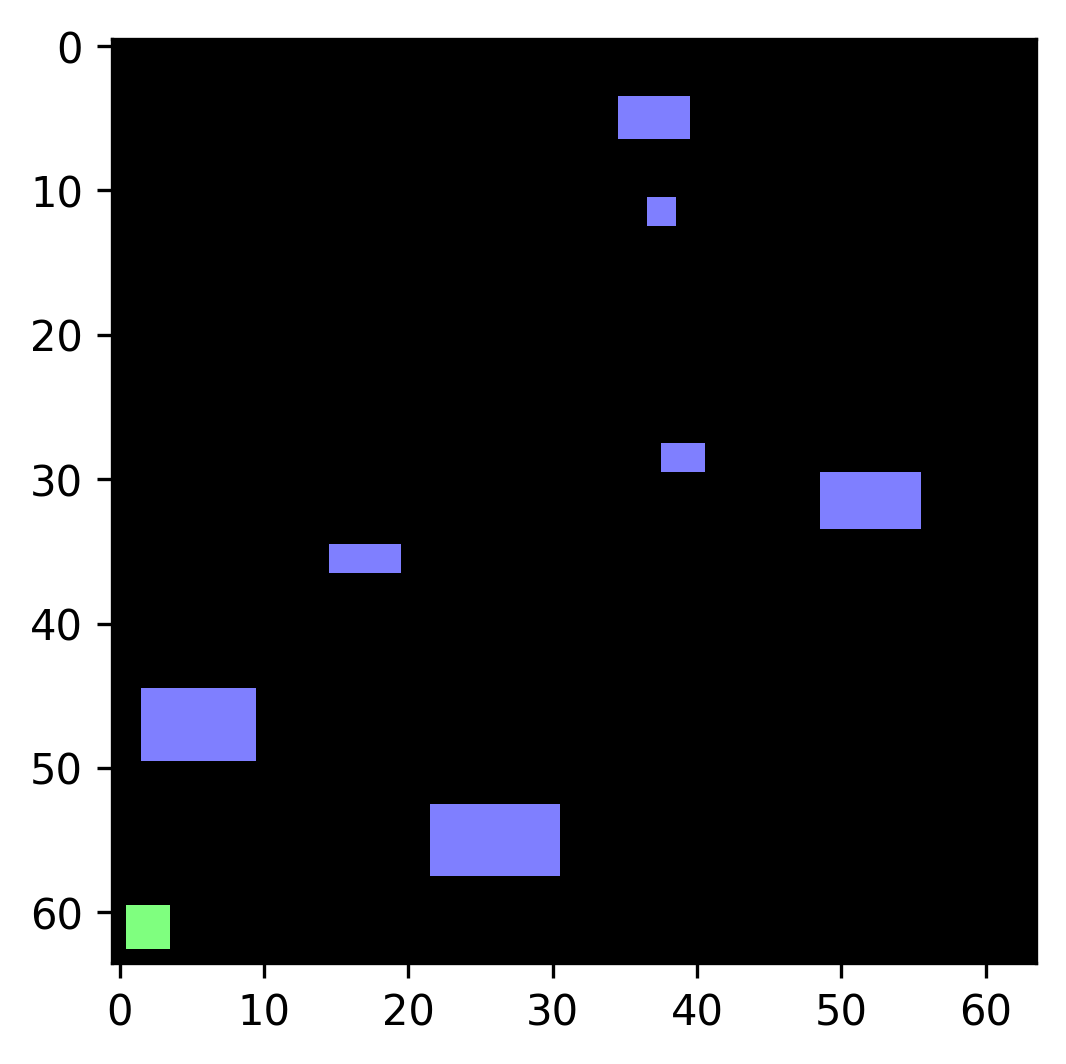

(3, 64, 64)


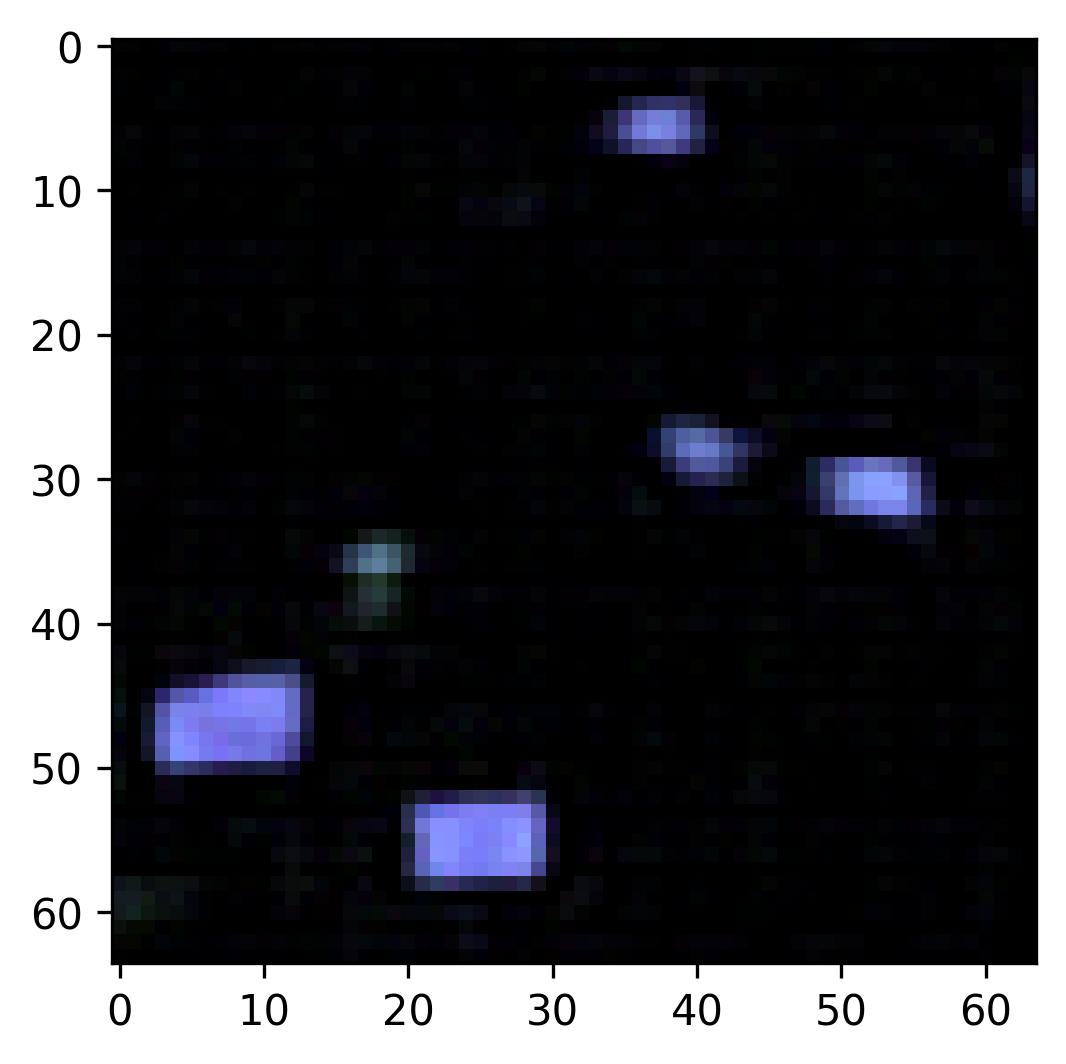

1
repr, std, cov, conv, closs 5.2431254386901855 0.0005288124084472656 7.341150194406509e-07 0.010521835647523403 0.25031960010528564
repr, std, cov, conv, closs 5.193456649780273 0.0005283355712890625 1.0863877832889557e-06 0.00904233381152153 0.2509389817714691
repr, std, cov, conv, closs 5.256367206573486 0.0005288124084472656 6.295740604400635e-07 0.010091053321957588 0.2519424557685852
repr, std, cov, conv, closs 5.323204517364502 0.0005288124084472656 7.199123501777649e-07 0.009245608001947403 0.2497081607580185
repr, std, cov, conv, closs 5.379167079925537 0.0005288124084472656 7.399357855319977e-07 0.009266561828553677 0.2504873275756836
repr, std, cov, conv, closs 5.603518009185791 0.0005283355712890625 6.565824151039124e-07 0.009938731789588928 0.2501358389854431
repr, std, cov, conv, closs 5.511297702789307 0.0005278587341308594 8.968636393547058e-07 0.010370738804340363 0.2507219910621643
repr, std, cov, conv, closs 5.553961753845215 0.0005273818969726562 8.030328899621964e

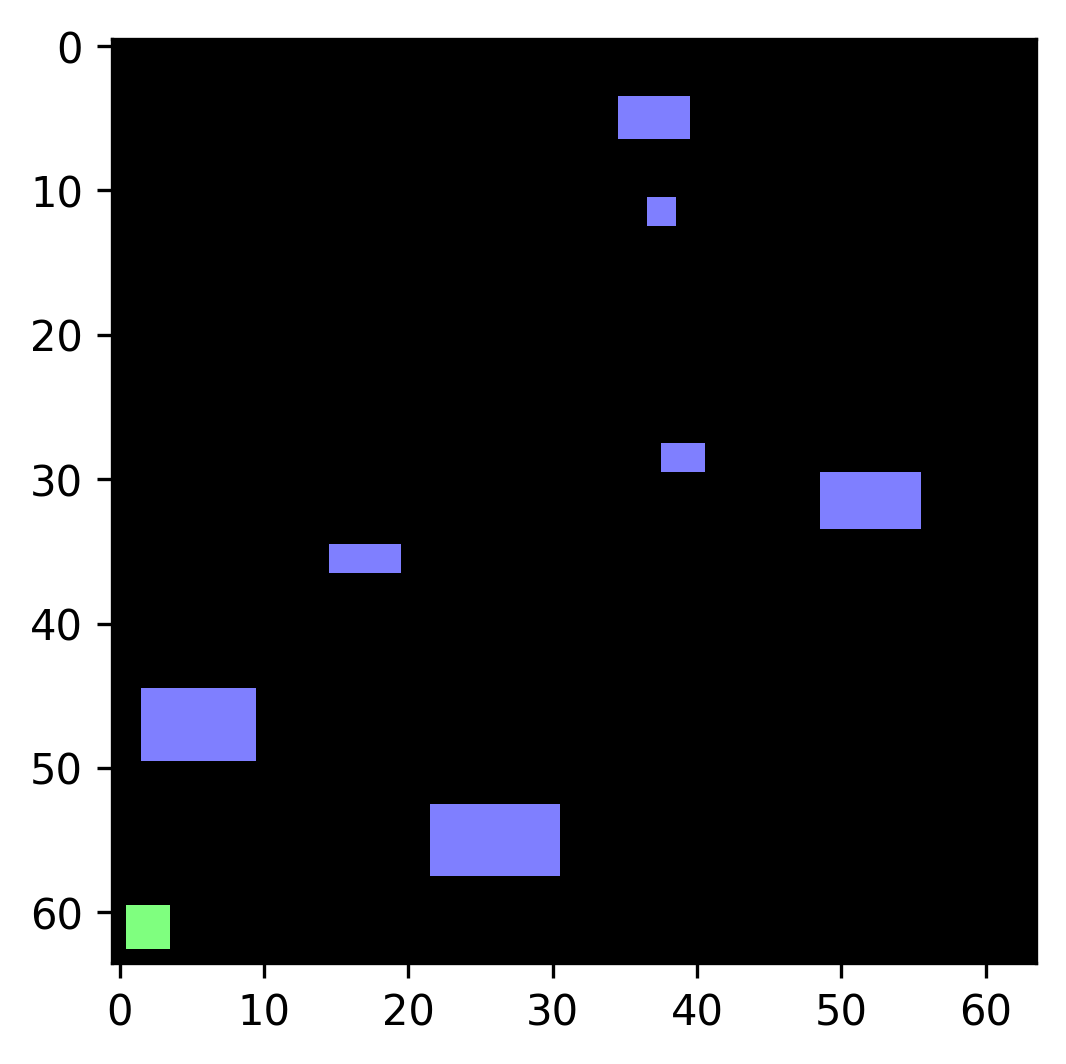

(3, 64, 64)


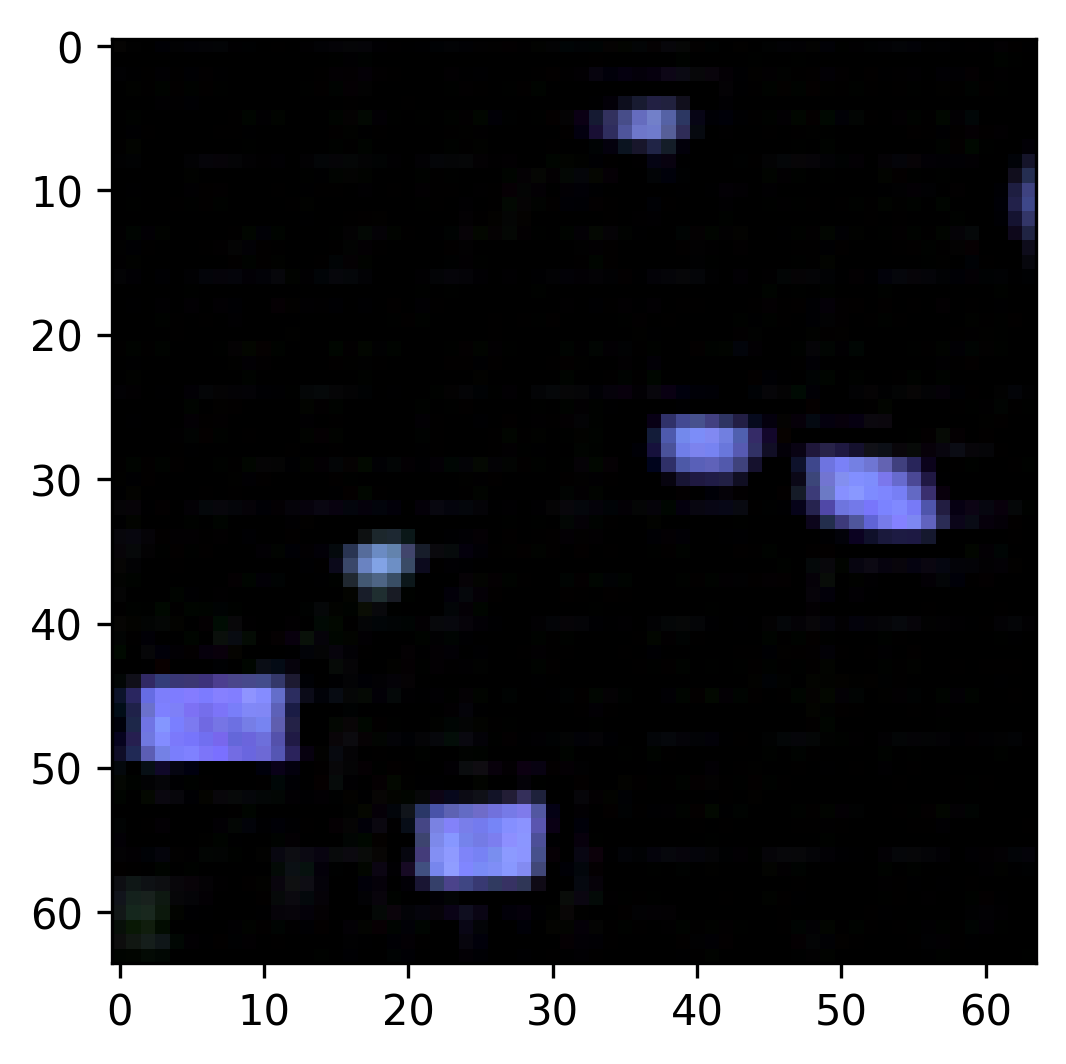

2
repr, std, cov, conv, closs 5.6741132736206055 0.0005183219909667969 1.1997763067483902e-06 0.009619561955332756 0.25009995698928833
repr, std, cov, conv, closs 5.588662624359131 0.0005178451538085938 9.005889296531677e-07 0.010097065940499306 0.24933074414730072
repr, std, cov, conv, closs 5.8442888259887695 0.0005183219909667969 6.973277777433395e-07 0.010637298226356506 0.2495059072971344
repr, std, cov, conv, closs 6.107340335845947 0.0005178451538085938 7.713679224252701e-07 0.010592850856482983 0.25226590037345886
repr, std, cov, conv, closs 5.94540548324585 0.0005159378051757812 1.30385160446167e-06 0.01199702825397253 0.25363627076148987
repr, std, cov, conv, closs 6.0439066886901855 0.0005159378051757812 8.428469300270081e-07 0.014426885172724724 0.2503441572189331
repr, std, cov, conv, closs 5.818070888519287 0.0005154609680175781 8.731149137020111e-07 0.010048739612102509 0.2509423792362213
repr, std, cov, conv, closs 5.9047980308532715 0.0005154609680175781 8.298084139823

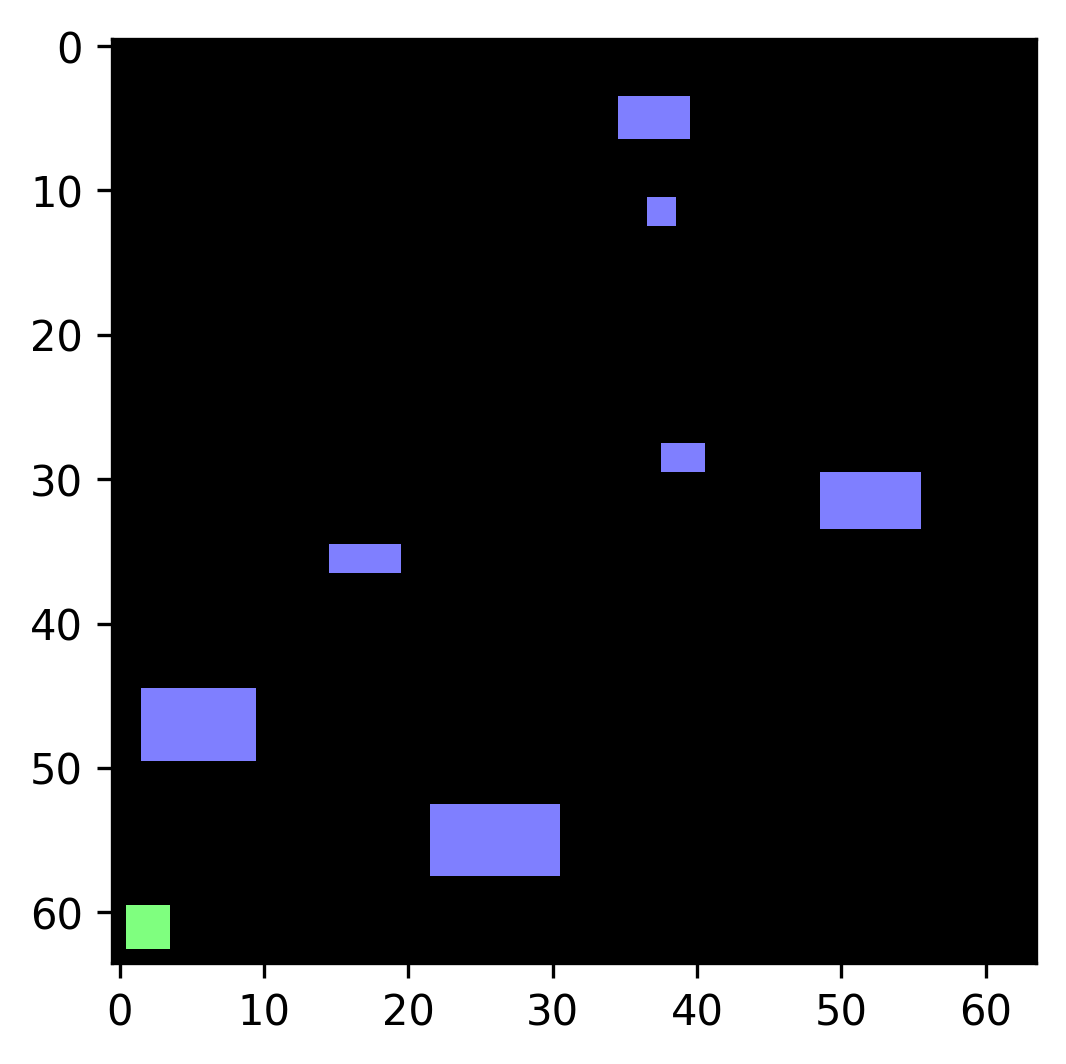

(3, 64, 64)


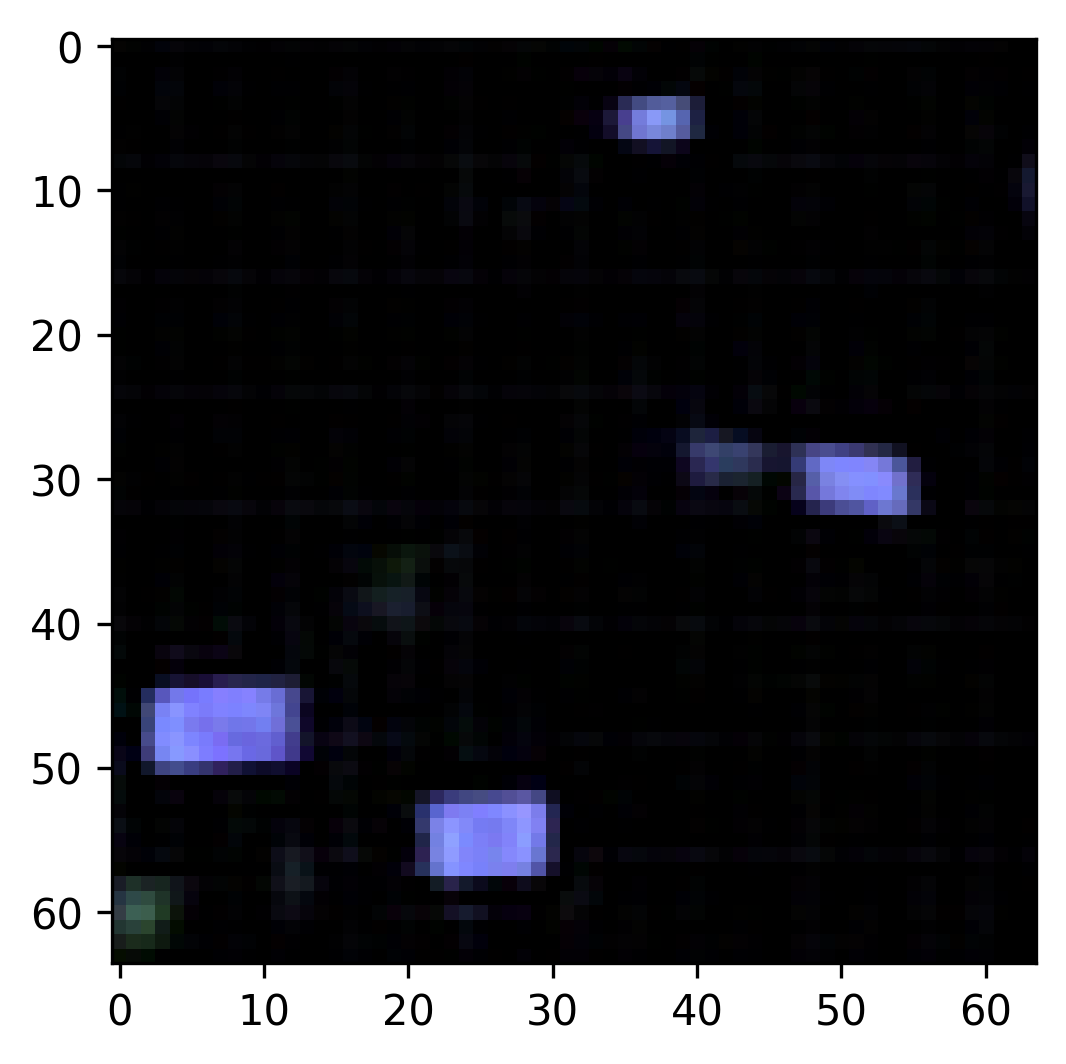

3
repr, std, cov, conv, closs 5.840001583099365 0.0005044937133789062 7.541384547948837e-07 0.01110374927520752 0.25065192580223083
repr, std, cov, conv, closs 5.789058685302734 0.0005049705505371094 4.12575900554657e-07 0.010508889332413673 0.2498428225517273
repr, std, cov, conv, closs 5.816595077514648 0.0005049705505371094 4.0442682802677155e-07 0.011378115974366665 0.2513369023799896
repr, std, cov, conv, closs 5.7867865562438965 0.0005044937133789062 6.258487701416016e-07 0.010287059471011162 0.24979914724826813
repr, std, cov, conv, closs 5.669907093048096 0.0005044937133789062 7.015187293291092e-07 0.010224977508187294 0.25104114413261414
repr, std, cov, conv, closs 5.8283538818359375 0.0005044937133789062 6.086193025112152e-07 0.0118973134085536 0.25408947467803955
repr, std, cov, conv, closs 5.809527397155762 0.0005044937133789062 6.537884473800659e-07 0.011017326265573502 0.2504896819591522
repr, std, cov, conv, closs 5.773797512054443 0.0005035400390625 7.811468094587326e-0

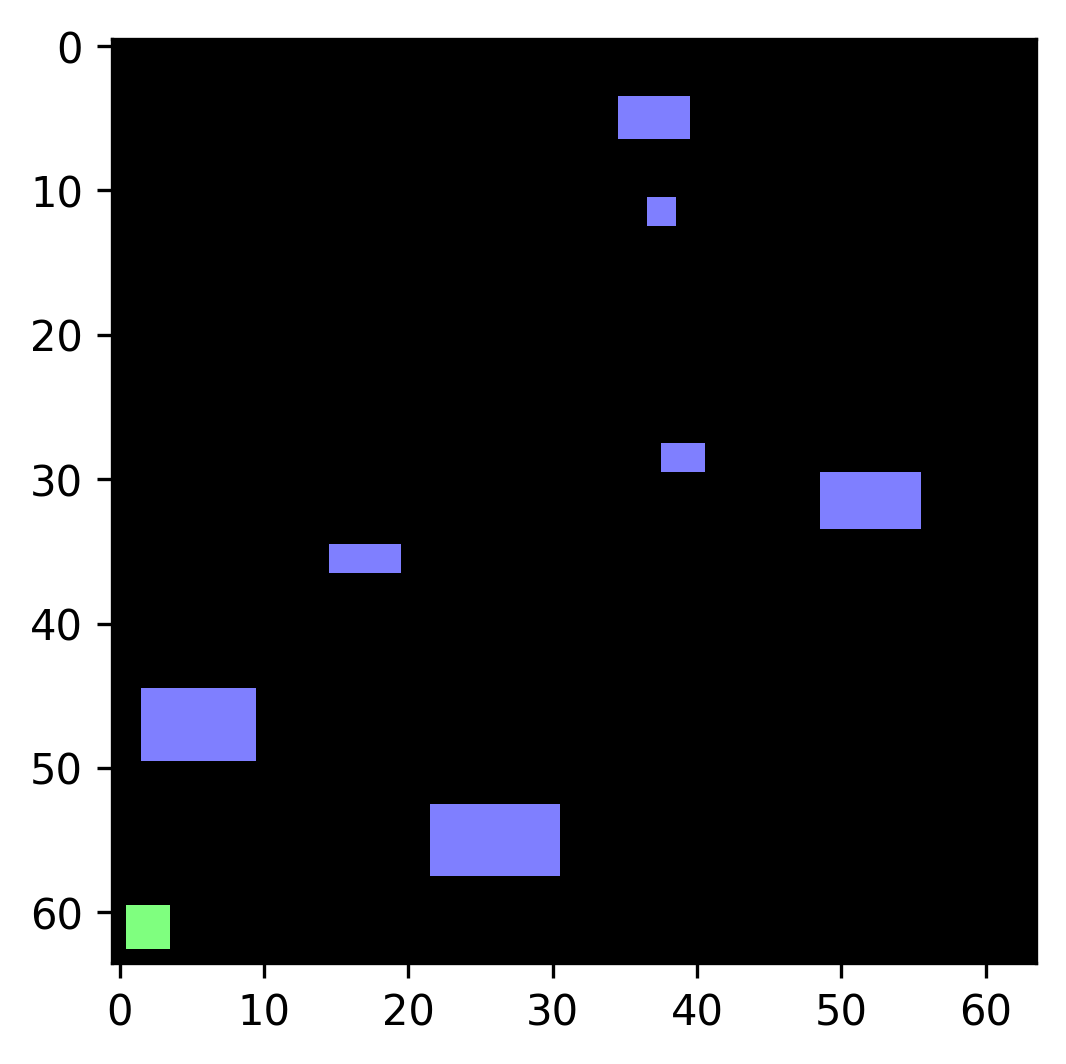

(3, 64, 64)


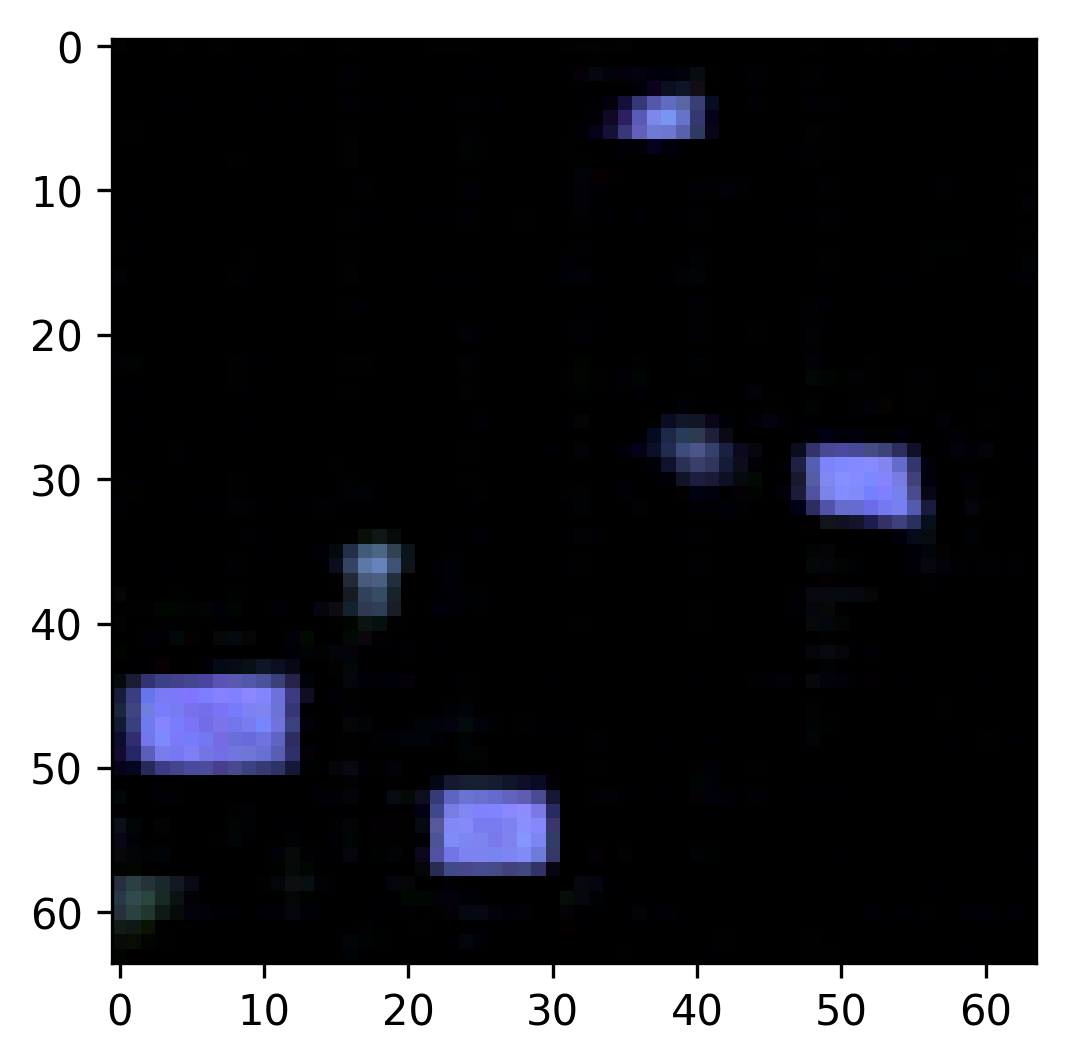

4
repr, std, cov, conv, closs 5.663848400115967 0.0004944801330566406 6.388872861862183e-07 0.009868215769529343 0.25292205810546875
repr, std, cov, conv, closs 5.669921398162842 0.0004940032958984375 8.482020348310471e-07 0.009481090120971203 0.24911847710609436
repr, std, cov, conv, closs 5.852153301239014 0.0004940032958984375 8.048955351114273e-07 0.01070798933506012 0.24956241250038147
repr, std, cov, conv, closs 5.859490871429443 0.0004935264587402344 8.866190910339355e-07 0.01184970885515213 0.24838204681873322
repr, std, cov, conv, closs 5.6314215660095215 0.0004916191101074219 1.1229421943426132e-06 0.010037887841463089 0.24640467762947083
repr, std, cov, conv, closs 5.760857582092285 0.0004911422729492188 6.975606083869934e-07 0.010489828884601593 0.25470128655433655
repr, std, cov, conv, closs 5.641510963439941 0.0004911422729492188 6.312038749456406e-07 0.011056273244321346 0.2540038228034973
repr, std, cov, conv, closs 5.854926109313965 0.0004906654357910156 6.875488907098

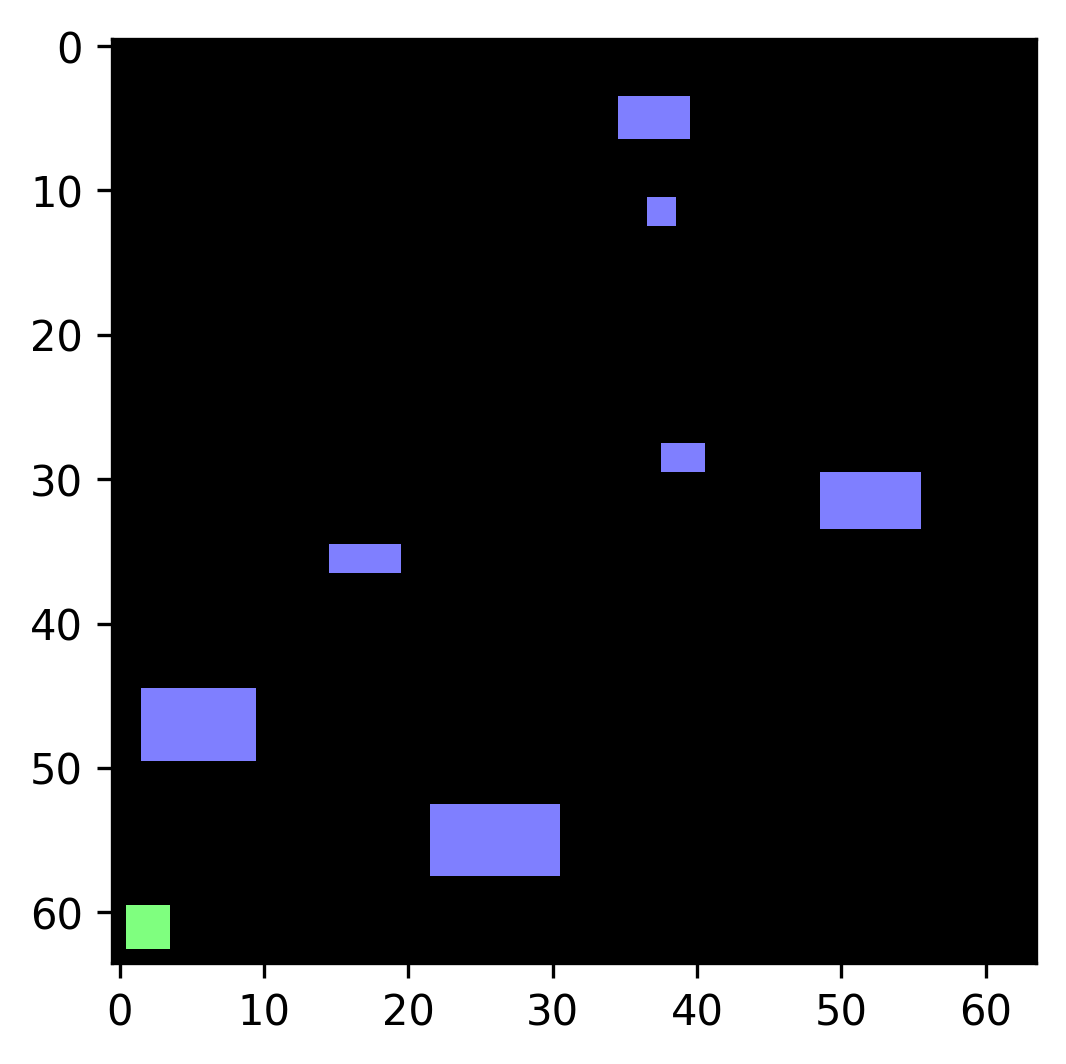

(3, 64, 64)


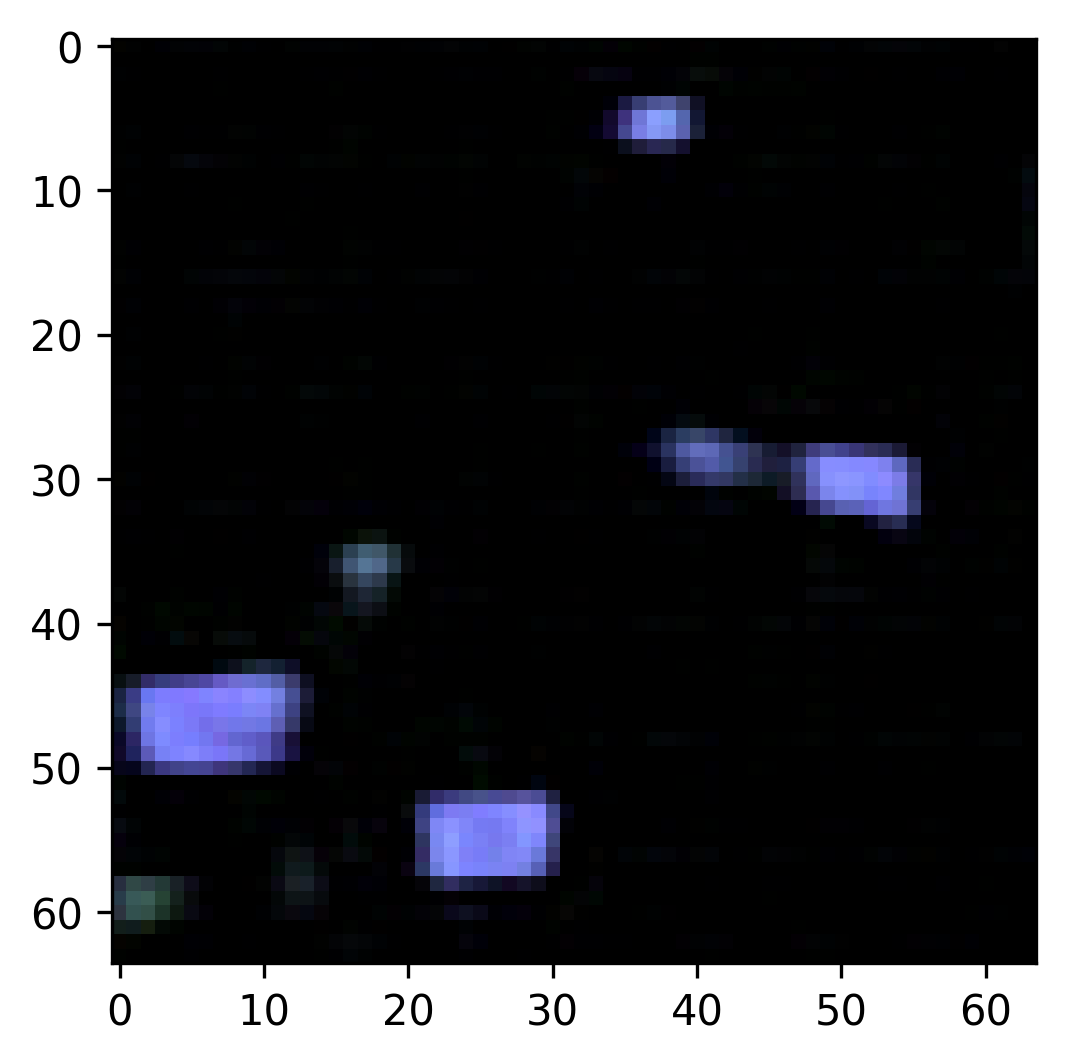

5
repr, std, cov, conv, closs 6.105347633361816 0.0004839897155761719 7.394701242446899e-07 0.010783935897052288 0.24961459636688232
repr, std, cov, conv, closs 6.172108173370361 0.0004837512969970703 5.729962140321732e-07 0.010039785876870155 0.24953007698059082
repr, std, cov, conv, closs 6.383686542510986 0.0004830360412597656 6.938353180885315e-07 0.010535046458244324 0.250174343585968
repr, std, cov, conv, closs 6.291011810302734 0.0004825592041015625 6.775371730327606e-07 0.010143397375941277 0.24965086579322815
repr, std, cov, conv, closs 6.381205081939697 0.0004818439483642578 5.918554961681366e-07 0.01162264309823513 0.2506557106971741
repr, std, cov, conv, closs 6.419989585876465 0.0004818439483642578 5.89294359087944e-07 0.011068719439208508 0.2500755786895752
repr, std, cov, conv, closs 6.009689807891846 0.0004813671112060547 7.005874067544937e-07 0.008754531852900982 0.25002360343933105
repr, std, cov, conv, closs 6.165621280670166 0.00048065185546875 6.512273102998734e-07

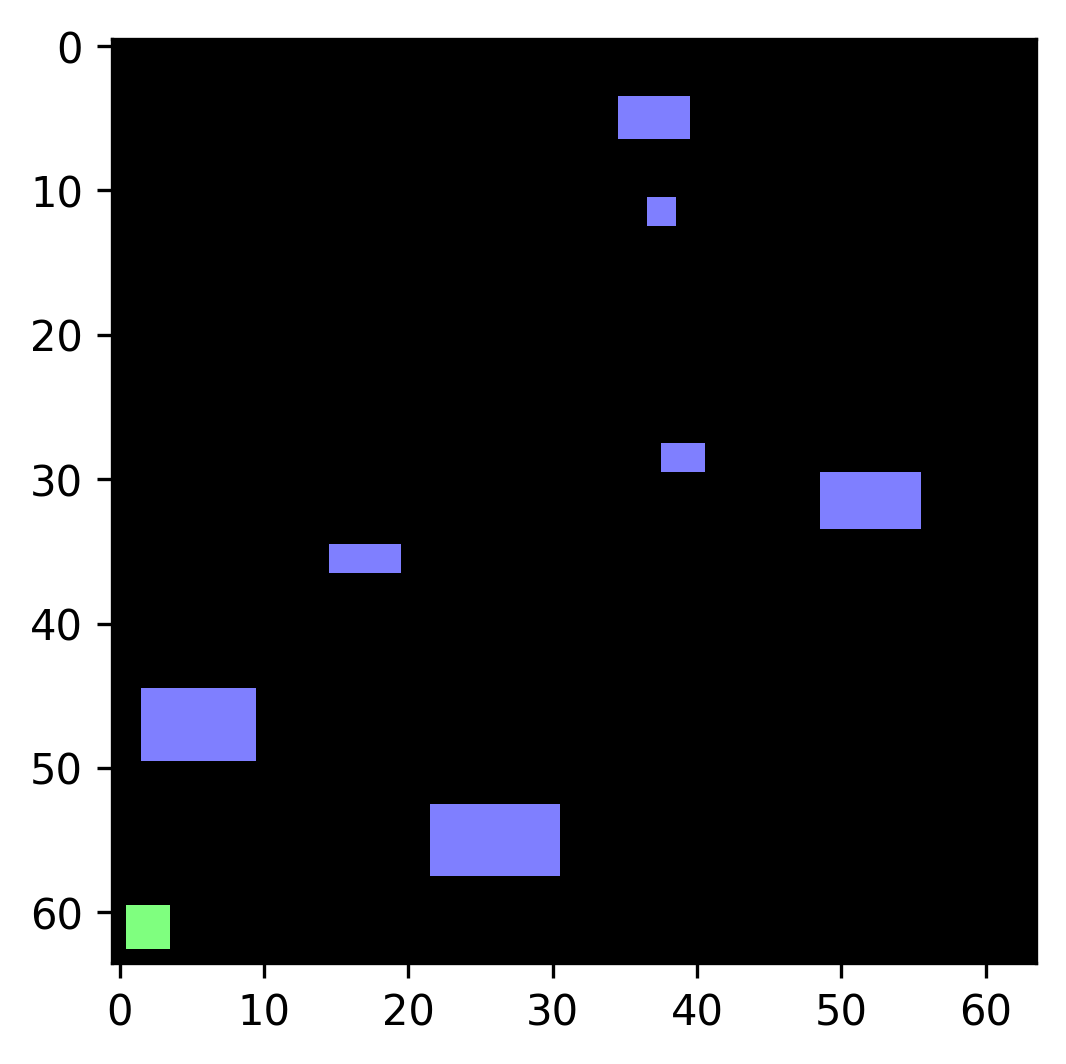

(3, 64, 64)


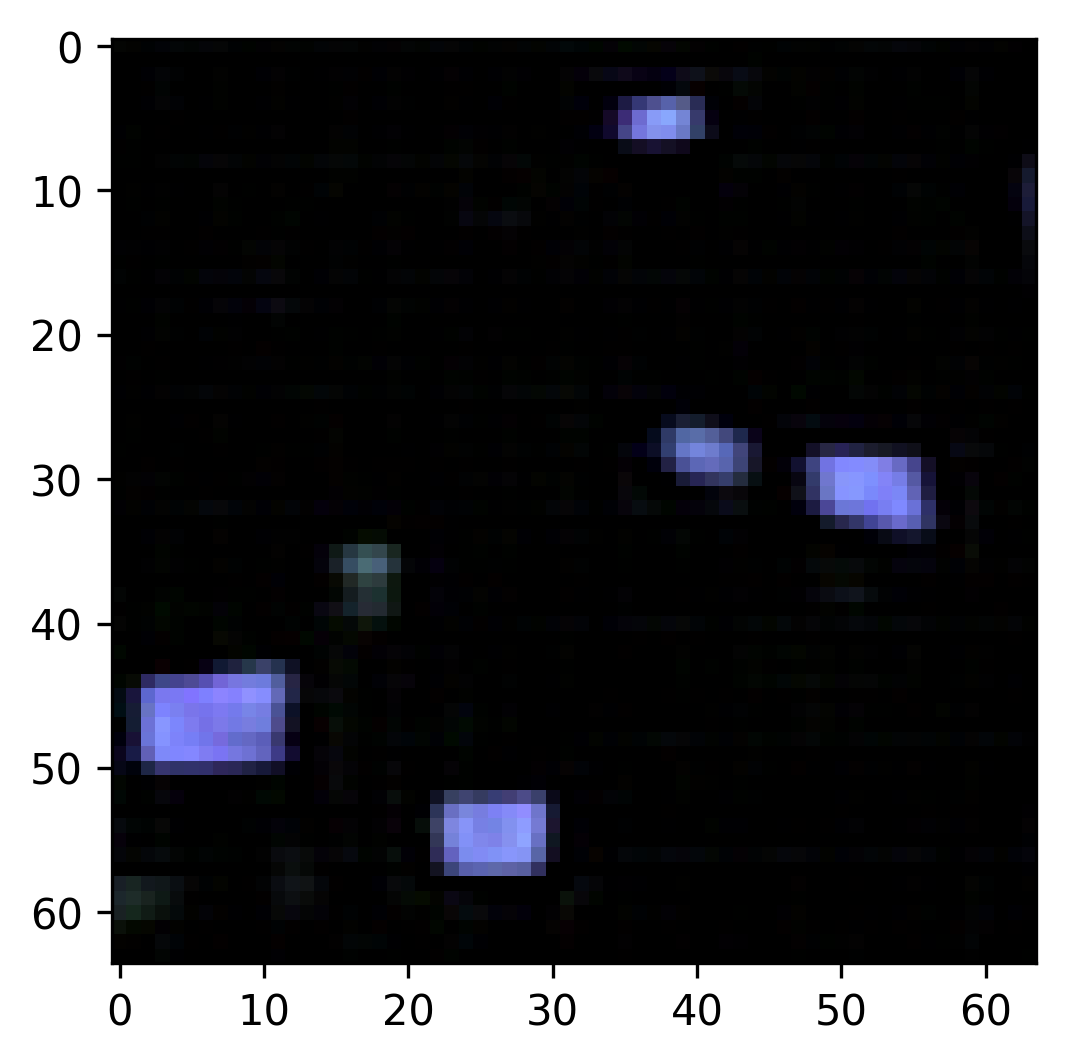

6
repr, std, cov, conv, closs 6.658832550048828 0.00047135353088378906 4.707835614681244e-07 0.012454632669687271 0.25002795457839966
repr, std, cov, conv, closs 6.616518497467041 0.00047135353088378906 5.166511982679367e-07 0.010200878605246544 0.2499295175075531
repr, std, cov, conv, closs 6.437070369720459 0.0004696846008300781 7.841736078262329e-07 0.010051140561699867 0.2502288818359375
repr, std, cov, conv, closs 6.586609840393066 0.000469207763671875 6.933696568012238e-07 0.01030840165913105 0.24989449977874756
repr, std, cov, conv, closs 6.476356506347656 0.00046944618225097656 4.637986421585083e-07 0.010350032709538937 0.2500554919242859
repr, std, cov, conv, closs 6.499765872955322 0.00046944618225097656 5.059409886598587e-07 0.00945679284632206 0.24978552758693695
repr, std, cov, conv, closs 6.5204668045043945 0.0004699230194091797 3.7695281207561493e-07 0.009724270552396774 0.2498011589050293
repr, std, cov, conv, closs 6.7907514572143555 0.000469207763671875 6.058253347873

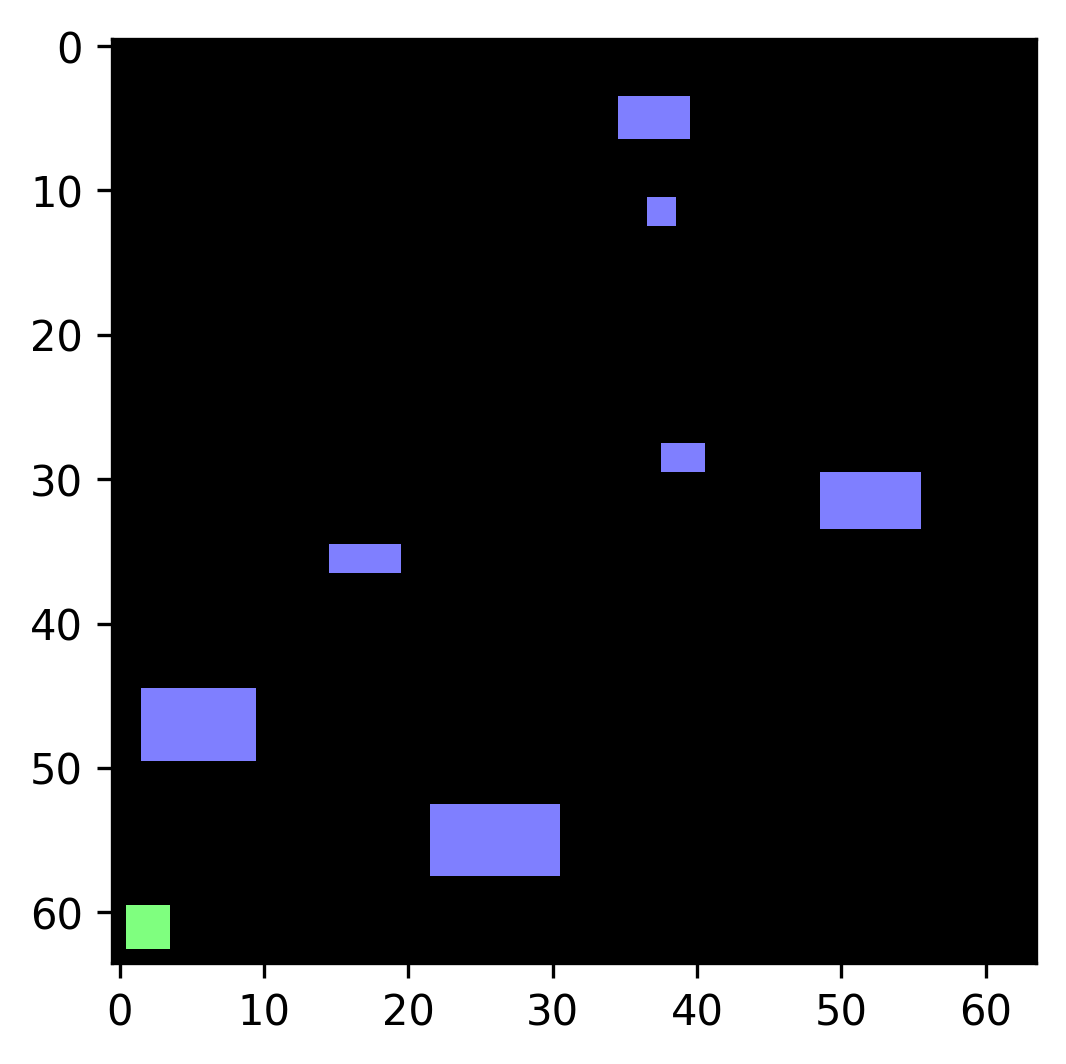

(3, 64, 64)


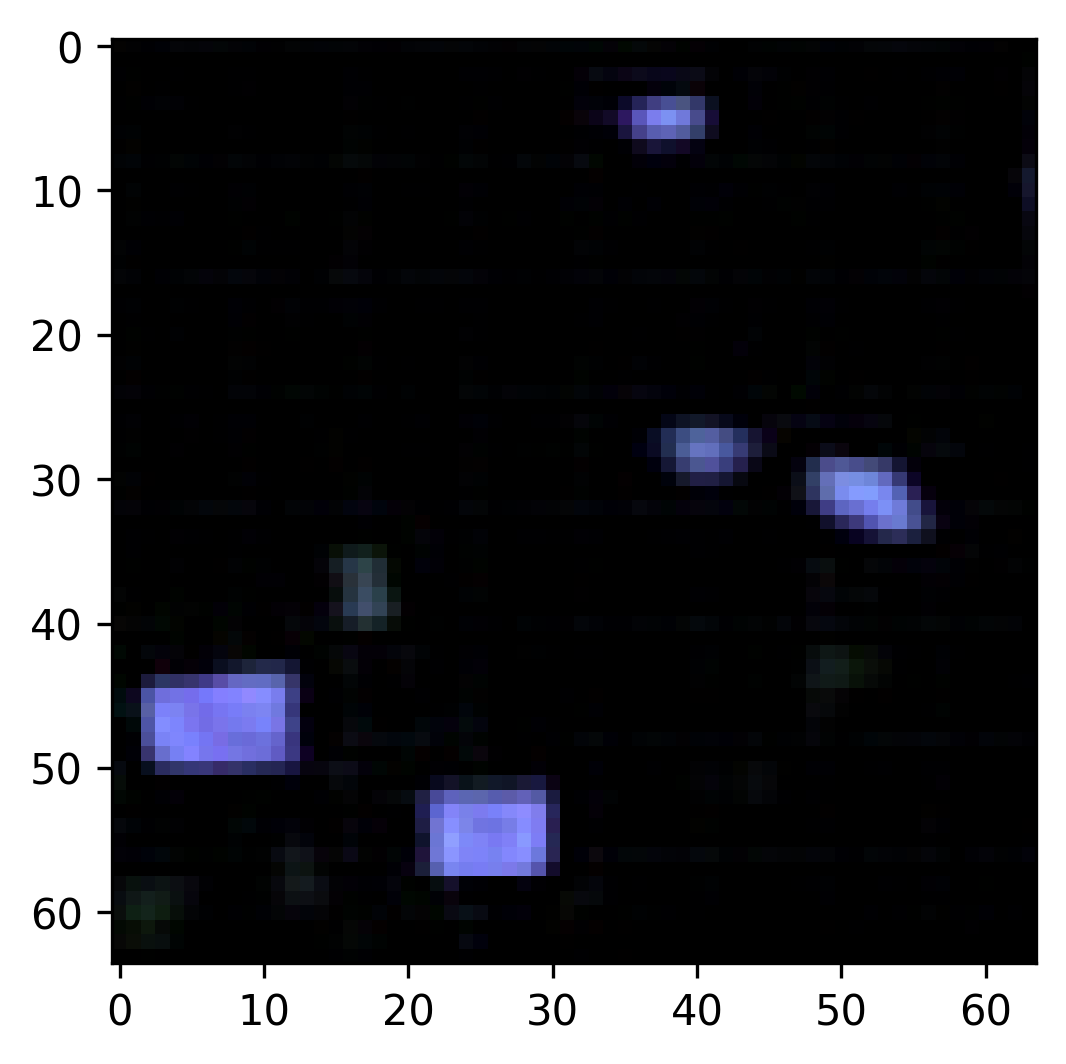

7
repr, std, cov, conv, closs 6.727285861968994 0.00045871734619140625 2.5401823222637177e-07 0.009014385752379894 0.24975663423538208
repr, std, cov, conv, closs 6.963066577911377 0.0004584789276123047 3.501772880554199e-07 0.009614674374461174 0.2501300573348999
repr, std, cov, conv, closs 7.115781307220459 0.00045752525329589844 5.648471415042877e-07 0.010863877832889557 0.2500532269477844
repr, std, cov, conv, closs 7.0852789878845215 0.0004565715789794922 5.979090929031372e-07 0.010151870548725128 0.2496263086795807
repr, std, cov, conv, closs 6.7165069580078125 0.00045561790466308594 8.654315024614334e-07 0.008109454065561295 0.2498662769794464
repr, std, cov, conv, closs 6.873958110809326 0.0004551410675048828 6.835907697677612e-07 0.00909450650215149 0.25139907002449036
repr, std, cov, conv, closs 7.0693464279174805 0.0004546642303466797 5.32250851392746e-07 0.010762828402221203 0.25067341327667236
repr, std, cov, conv, closs 7.377623081207275 0.00045490264892578125 3.385357558

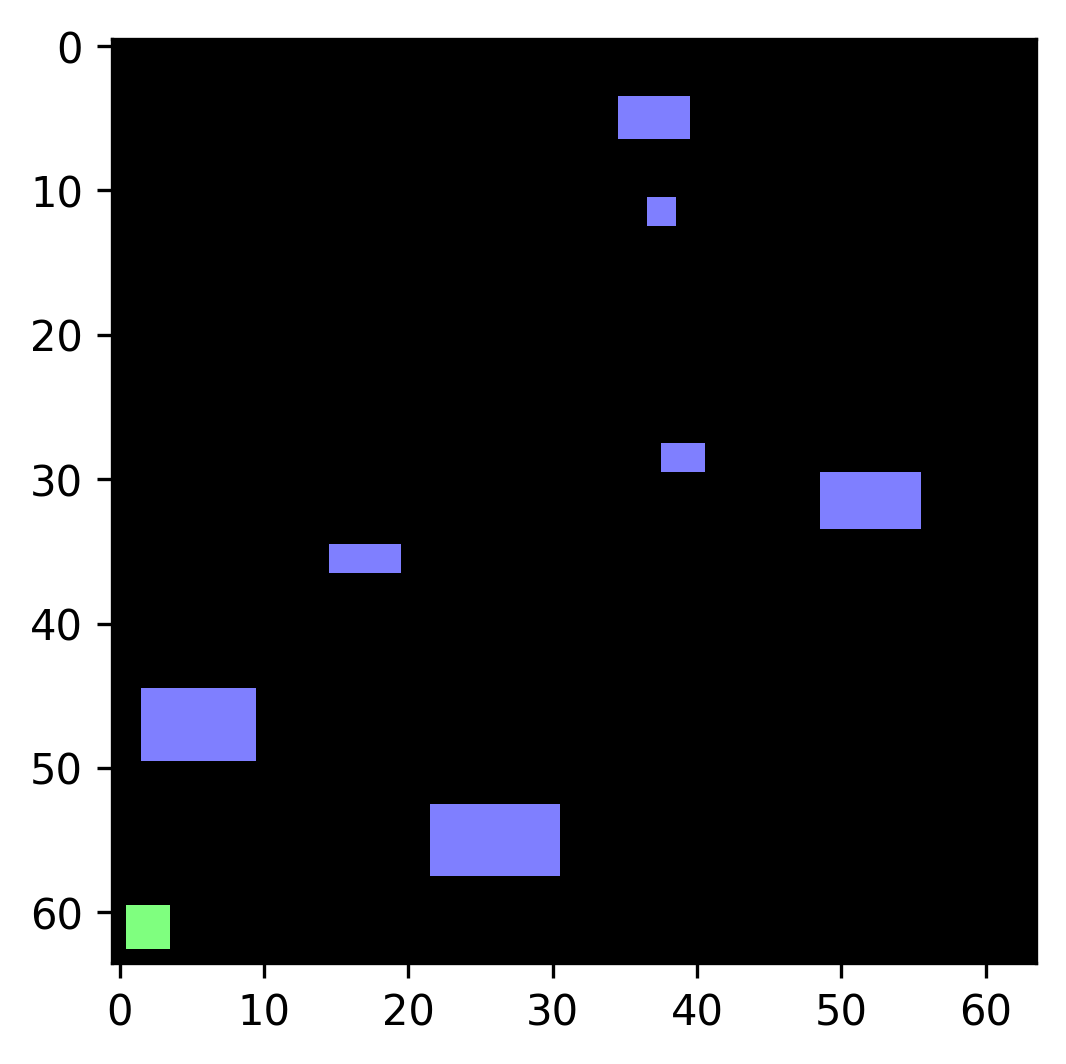

(3, 64, 64)


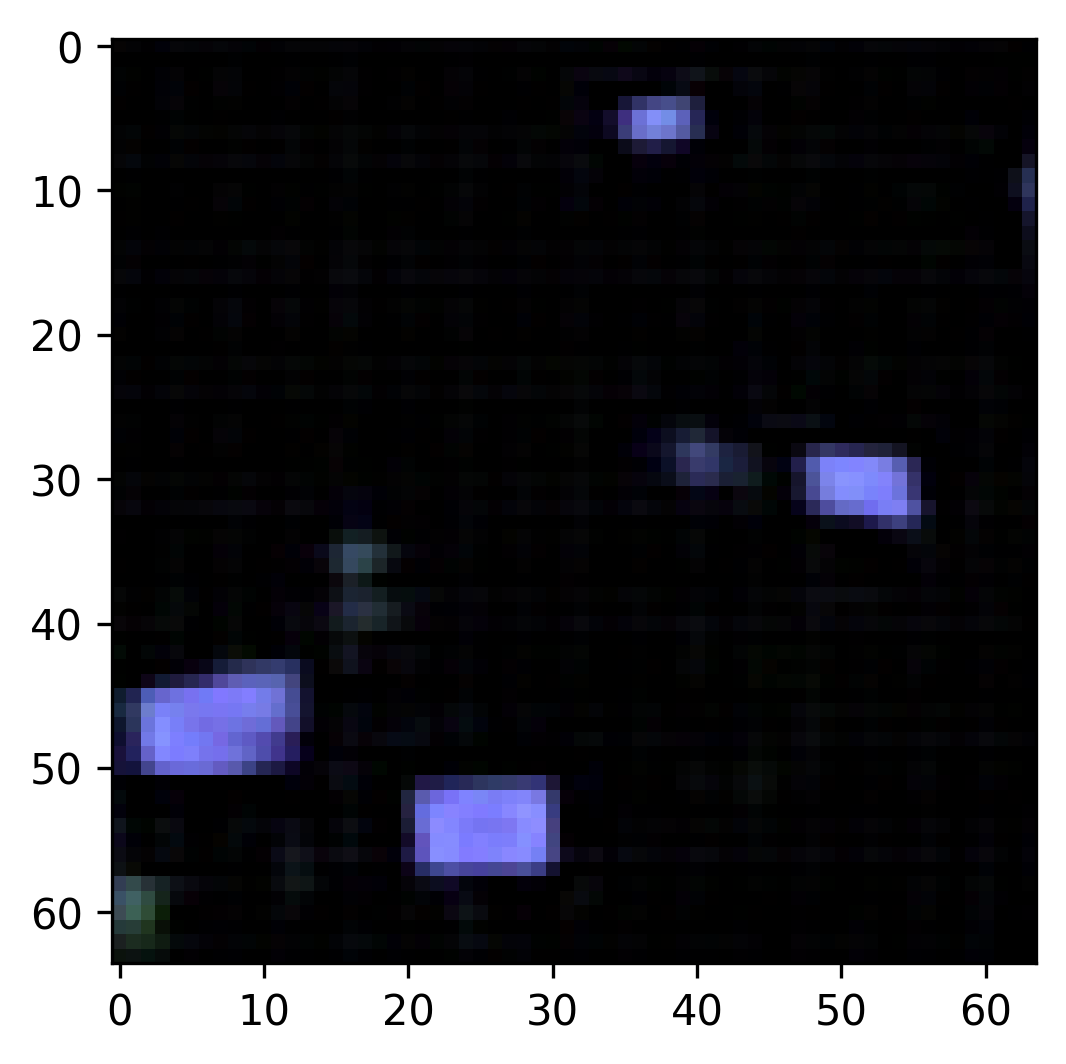

8
repr, std, cov, conv, closs 7.683309555053711 0.0004475116729736328 4.523899406194687e-07 0.011955112218856812 0.2500225901603699
repr, std, cov, conv, closs 7.847540855407715 0.0004477500915527344 4.048924893140793e-07 0.011742095462977886 0.25041478872299194
repr, std, cov, conv, closs 7.4581756591796875 0.00044608116149902344 6.433110684156418e-07 0.010603420436382294 0.24993140995502472
repr, std, cov, conv, closs 7.628789901733398 0.0004456043243408203 3.988388925790787e-07 0.010620271787047386 0.24984008073806763
repr, std, cov, conv, closs 7.693604469299316 0.0004456043243408203 4.414469003677368e-07 0.012550024315714836 0.2500652074813843
repr, std, cov, conv, closs 7.760024547576904 0.0004458427429199219 3.206077963113785e-07 0.010886229574680328 0.2502237856388092
repr, std, cov, conv, closs 7.628820419311523 0.0004458427429199219 3.2084062695503235e-07 0.011484610848128796 0.25000160932540894
repr, std, cov, conv, closs 7.79103422164917 0.0004458427429199219 2.940651029348

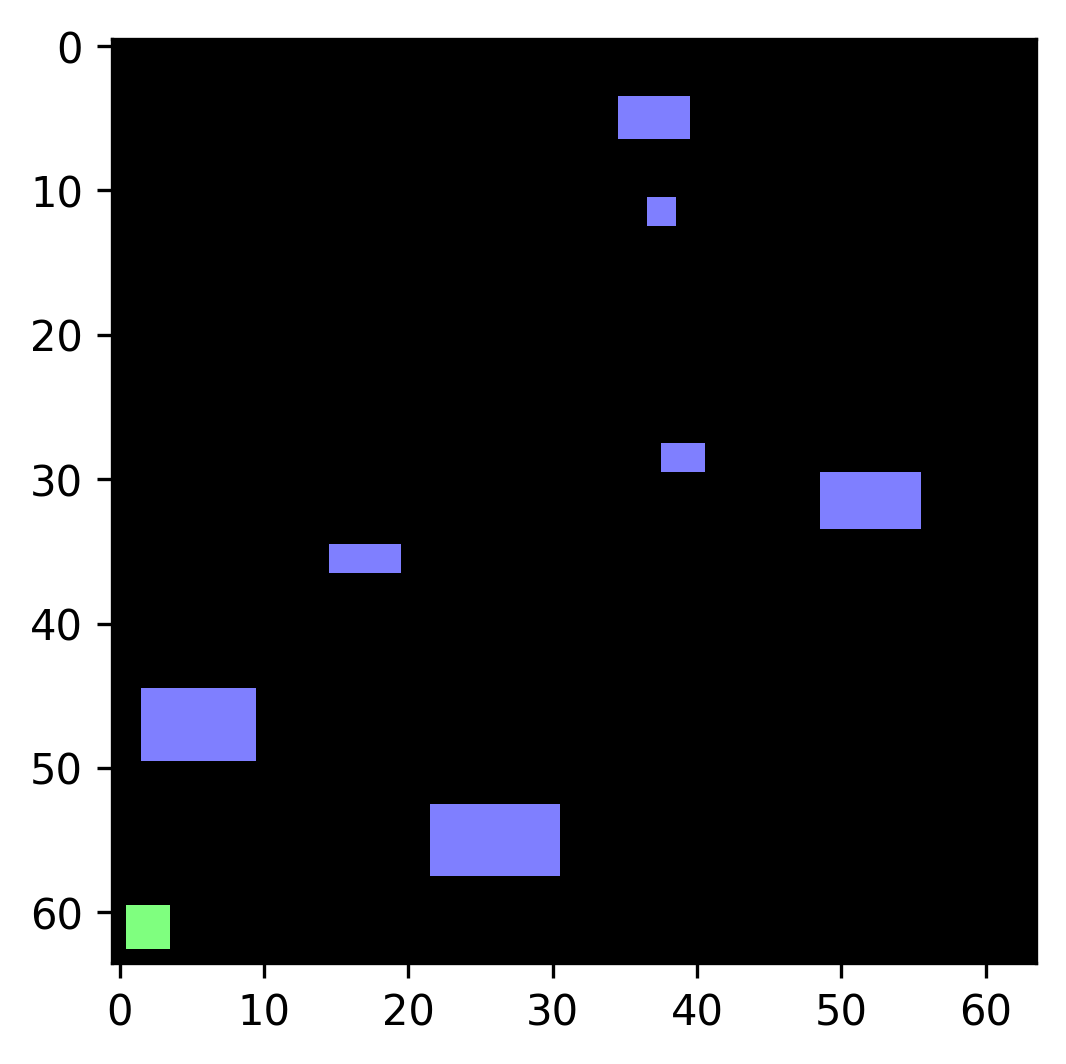

(3, 64, 64)


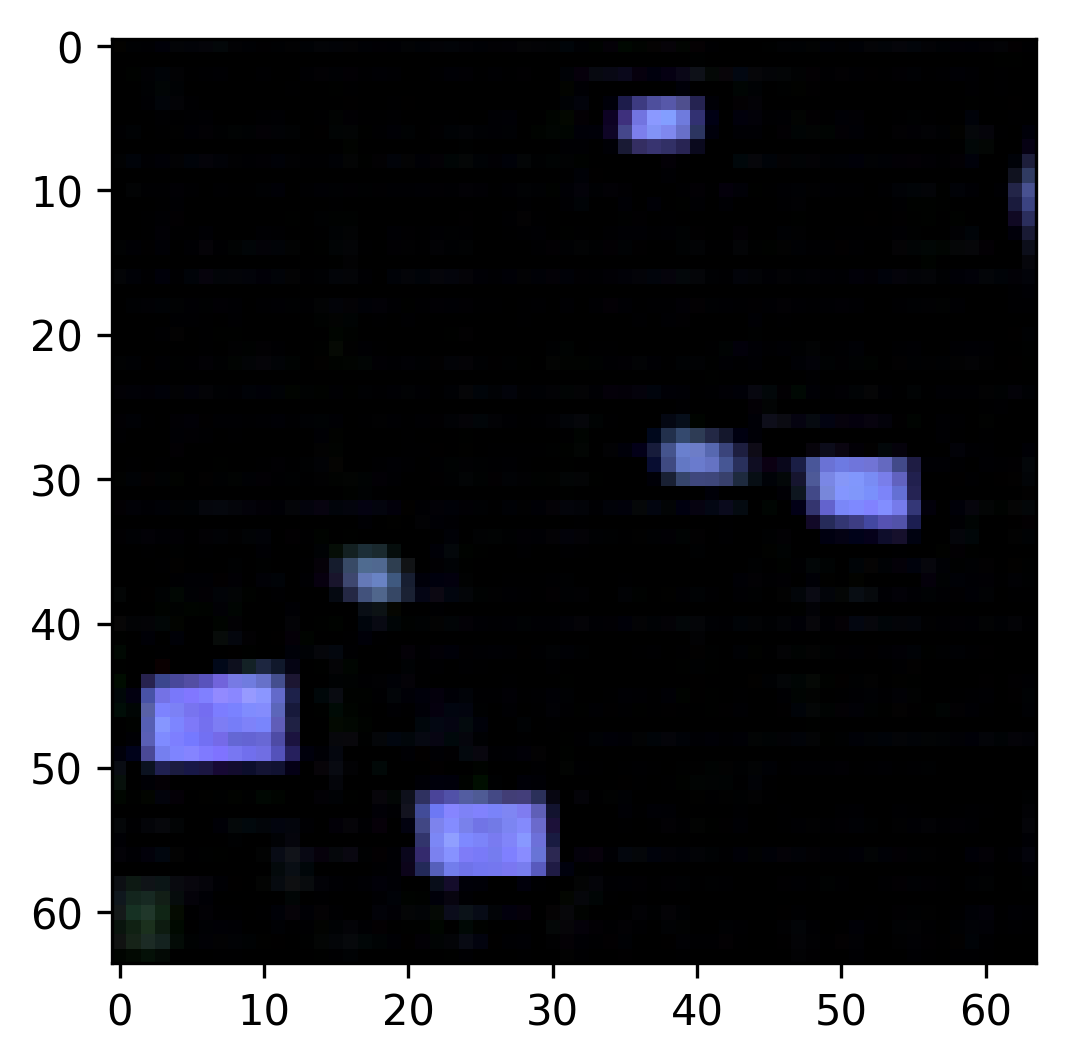

9
repr, std, cov, conv, closs 8.1992769241333 0.00043654441833496094 2.4936161935329437e-07 0.010686571709811687 0.24790900945663452
repr, std, cov, conv, closs 8.222501754760742 0.00043654441833496094 2.92900949716568e-07 0.010720591060817242 0.25527089834213257
repr, std, cov, conv, closs 7.737264156341553 0.00043487548828125 6.05359673500061e-07 0.009449608623981476 0.24880895018577576
repr, std, cov, conv, closs 7.7975873947143555 0.0004341602325439453 5.587935447692871e-07 0.009090069681406021 0.25076520442962646
repr, std, cov, conv, closs 8.006912231445312 0.00043463706970214844 3.1781382858753204e-07 0.010167415253818035 0.250785768032074
repr, std, cov, conv, closs 8.188690185546875 0.00043463706970214844 2.48197466135025e-07 0.011031351052224636 0.24874642491340637
repr, std, cov, conv, closs 7.765336036682129 0.0004343986511230469 3.466848284006119e-07 0.009624650701880455 0.25078561902046204
repr, std, cov, conv, closs 8.059274673461914 0.00043463706970214844 2.728775143623

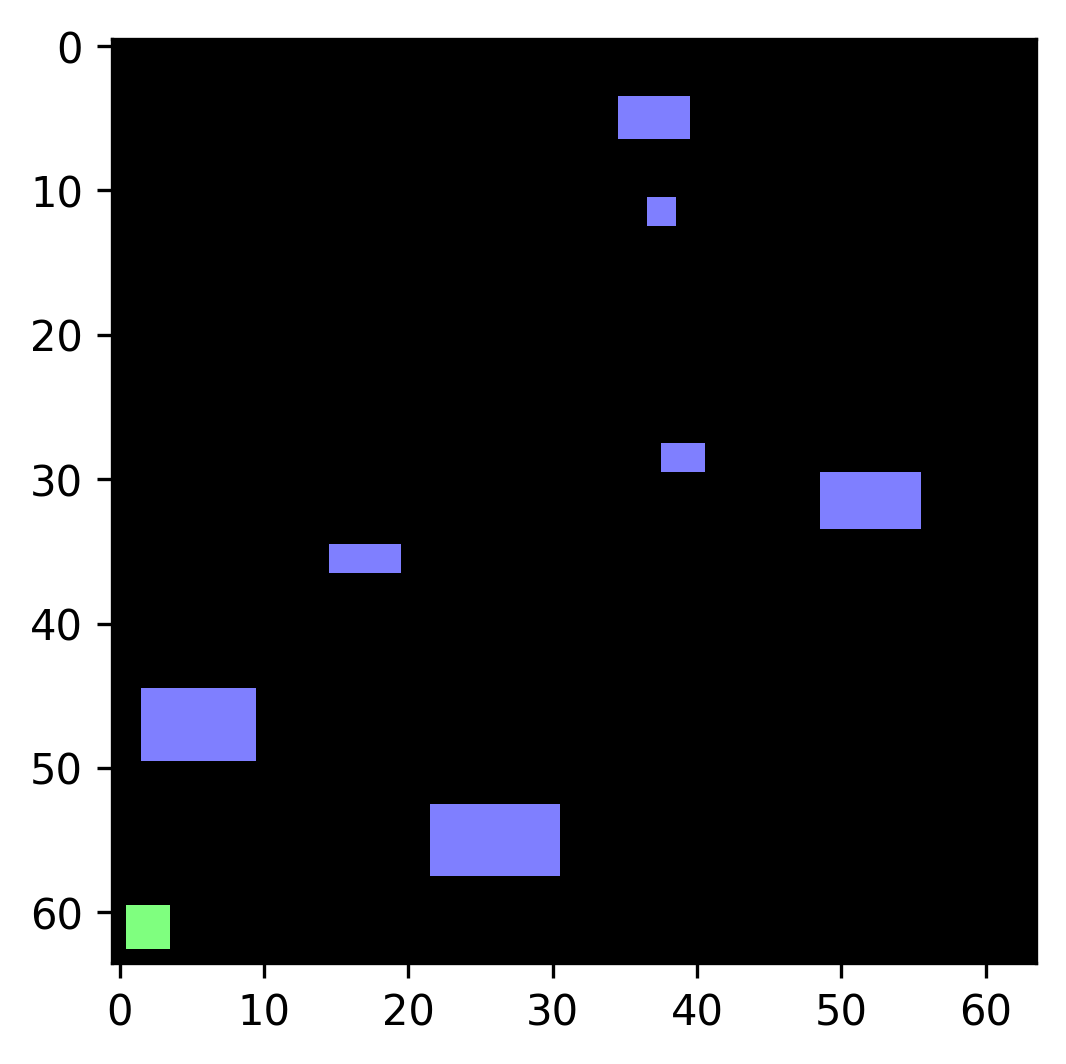

(3, 64, 64)


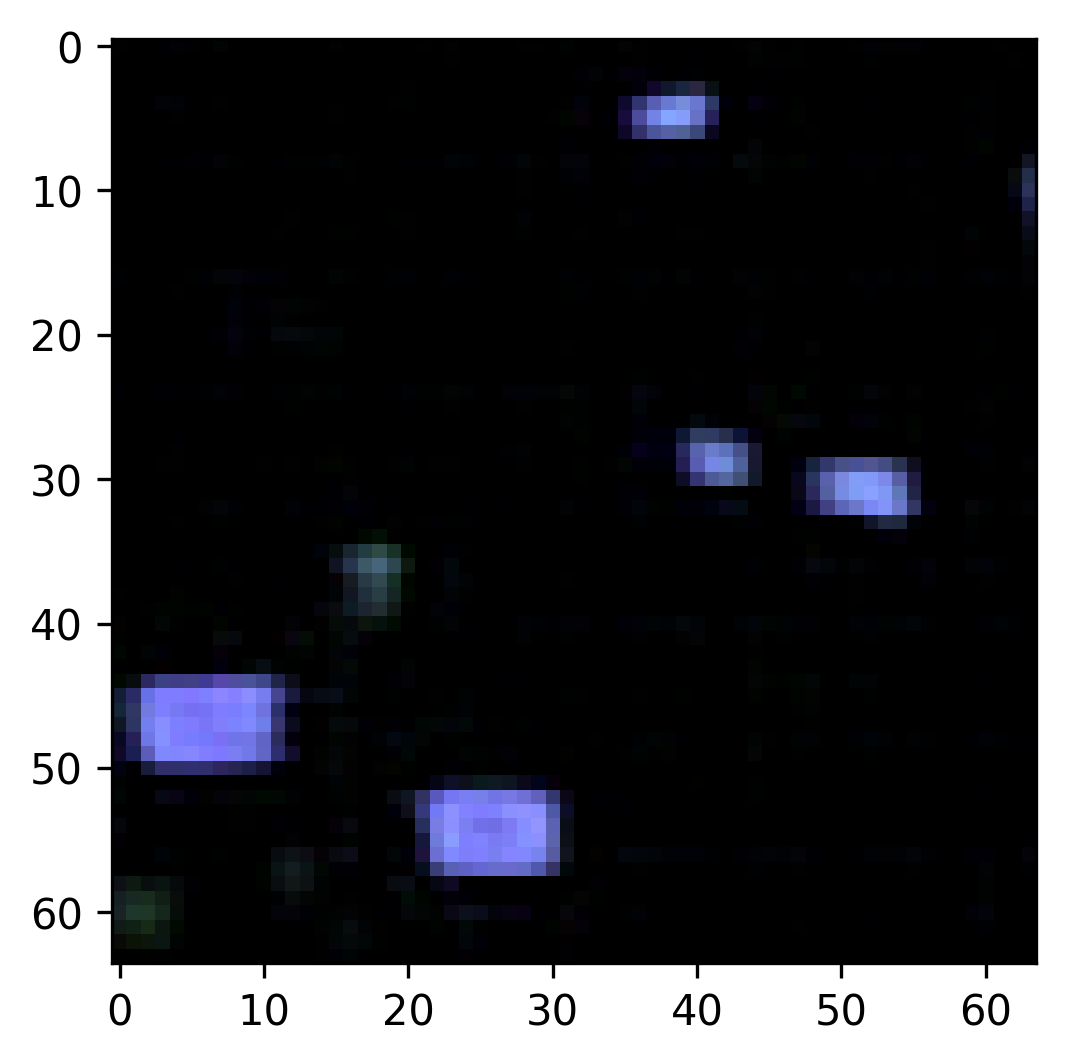

10
repr, std, cov, conv, closs 8.877942085266113 0.00042724609375 2.7171336114406586e-07 0.009152509272098541 0.24947835505008698
repr, std, cov, conv, closs 8.71453857421875 0.0004267692565917969 3.8463622331619263e-07 0.00795966200530529 0.2492319494485855
repr, std, cov, conv, closs 9.088830947875977 0.0004265308380126953 4.614703357219696e-07 0.009468596428632736 0.24984800815582275
repr, std, cov, conv, closs 9.58981704711914 0.0004258155822753906 5.010515451431274e-07 0.00941692665219307 0.2507188320159912
repr, std, cov, conv, closs 10.200590133666992 0.0004258155822753906 3.396999090909958e-07 0.009104527533054352 0.25111281871795654
repr, std, cov, conv, closs 10.444754600524902 0.00042557716369628906 3.5855919122695923e-07 0.009088480845093727 0.25044625997543335
argm 0.914276123046875 115.54118347167969
argm 0.9069534540176392 114.98406982421875
repr, std, cov, conv, closs 11.86767864227295 0.00042557716369628906 3.241002559661865e-07 0.010335970669984818 0.24992582201957703

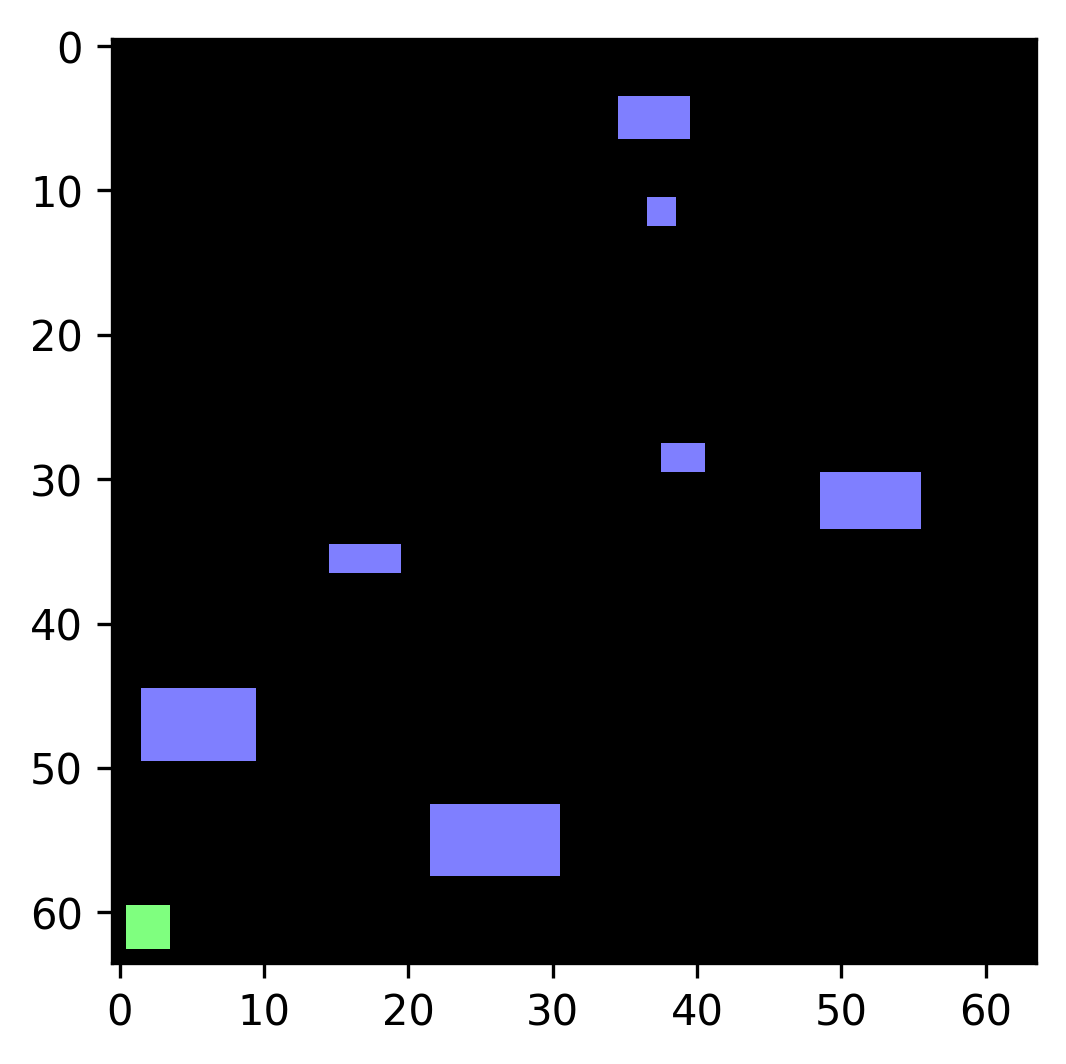

(3, 64, 64)


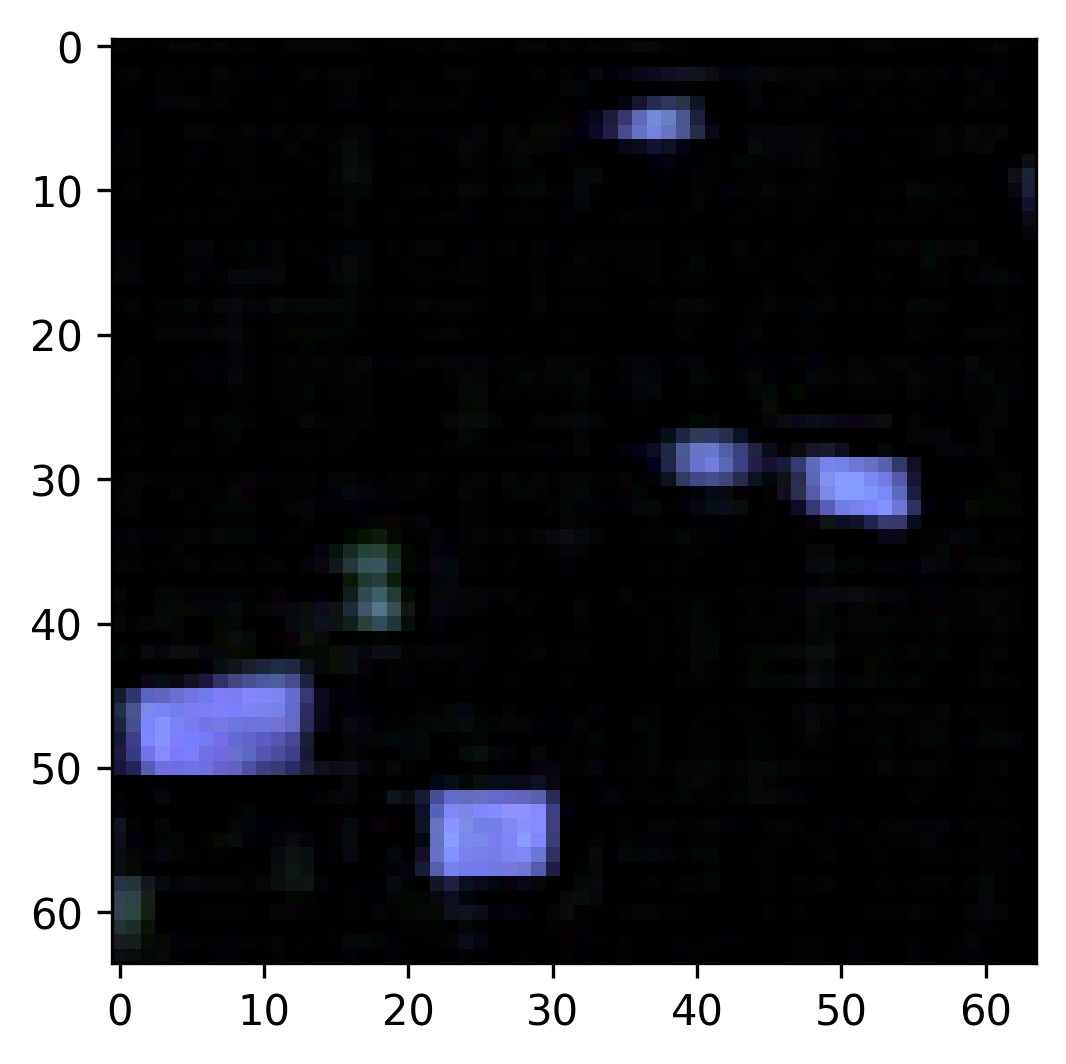

11
repr, std, cov, conv, closs 10.131364822387695 0.0004169940948486328 2.3283064365386963e-07 0.010002361610531807 0.25005605816841125
repr, std, cov, conv, closs 10.321025848388672 0.0004169940948486328 2.8870999813079834e-07 0.010977927595376968 0.2502891421318054
repr, std, cov, conv, closs 9.836009979248047 0.0004165172576904297 2.896413207054138e-07 0.010510455816984177 0.2515507638454437
repr, std, cov, conv, closs 10.157859802246094 0.0004165172576904297 3.182794898748398e-07 0.00989302434027195 0.2499002069234848
repr, std, cov, conv, closs 10.059852600097656 0.0004162788391113281 2.4726614356040955e-07 0.009739020839333534 0.2500282824039459
repr, std, cov, conv, closs 10.237312316894531 0.0004165172576904297 1.9255094230175018e-07 0.010224725119769573 0.2502625584602356
repr, std, cov, conv, closs 10.195432662963867 0.00041604042053222656 3.341119736433029e-07 0.010872317478060722 0.2498176246881485
repr, std, cov, conv, closs 10.20119857788086 0.000415802001953125 3.3108517

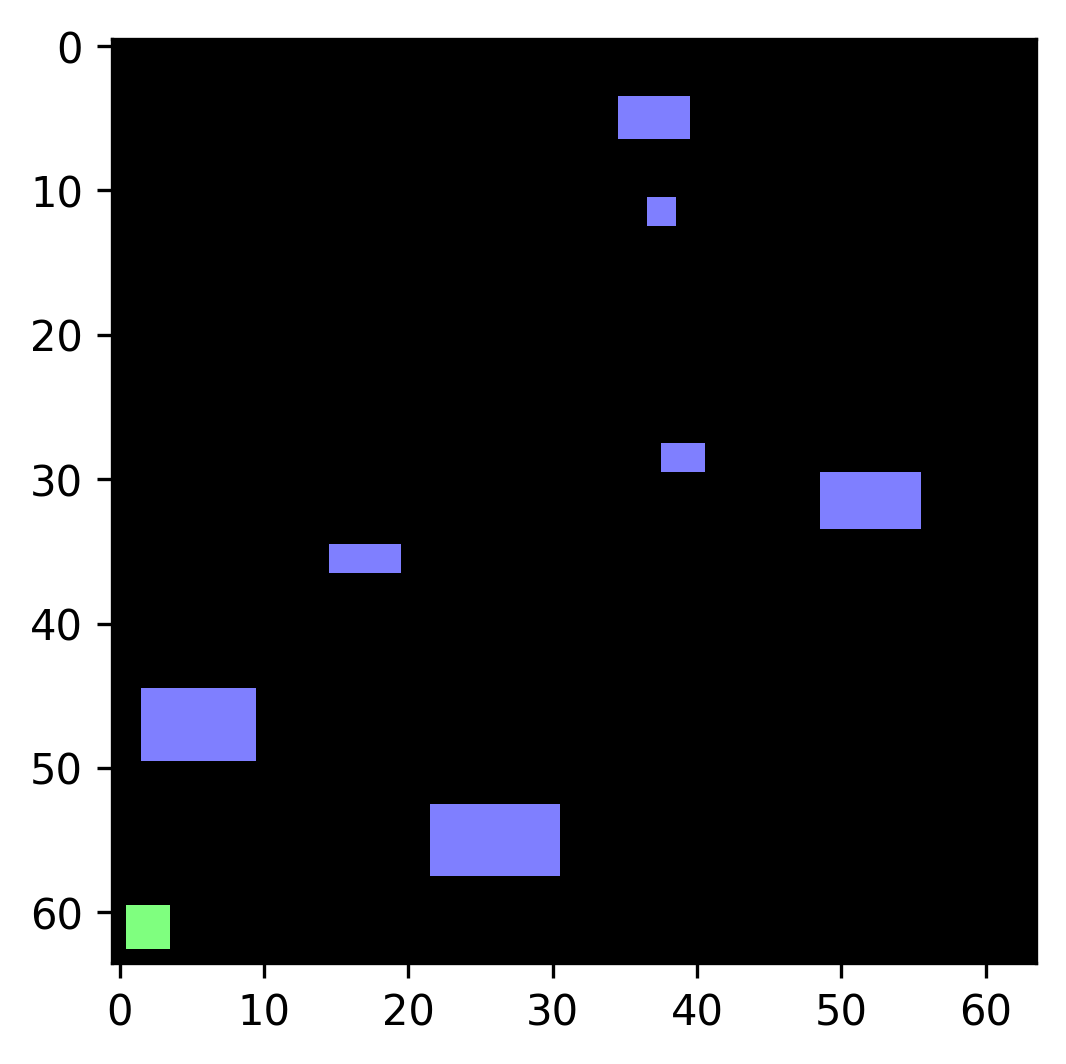

(3, 64, 64)


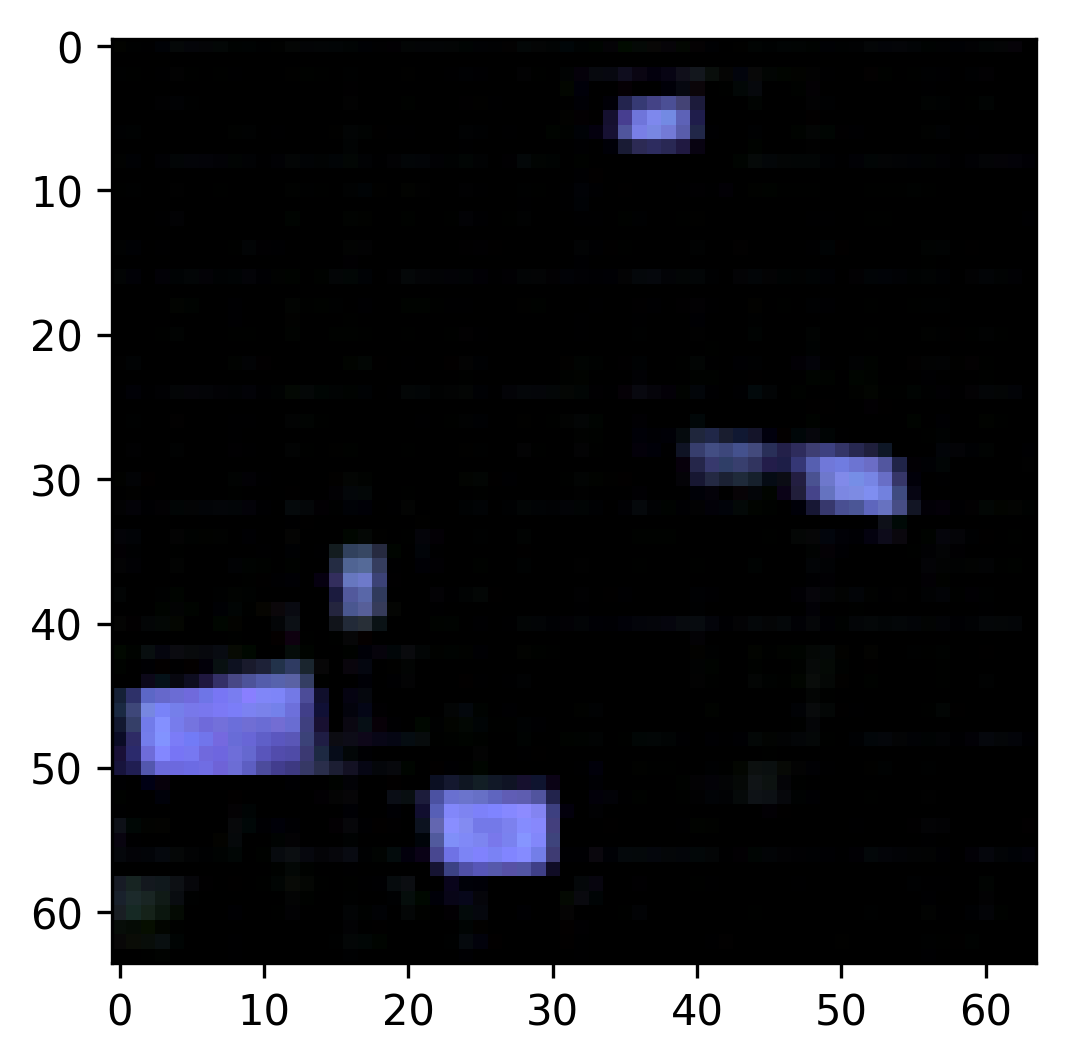

12
repr, std, cov, conv, closs 9.374199867248535 0.0004074573516845703 3.46451997756958e-07 0.008474331349134445 0.24981488287448883
repr, std, cov, conv, closs 9.887519836425781 0.0004076957702636719 2.8265640139579773e-07 0.00967829953879118 0.25036436319351196
repr, std, cov, conv, closs 9.762299537658691 0.0004076957702636719 2.2747553884983063e-07 0.010300587862730026 0.24834255874156952
repr, std, cov, conv, closs 9.925142288208008 0.0004076957702636719 1.471489667892456e-07 0.010379347950220108 0.24901805818080902
repr, std, cov, conv, closs 9.9192476272583 0.00040721893310546875 2.253800630569458e-07 0.010271338745951653 0.24781110882759094
repr, std, cov, conv, closs 9.919787406921387 0.00040721893310546875 1.8440186977386475e-07 0.010137620382010937 0.24720101058483124
repr, std, cov, conv, closs 9.637872695922852 0.0004069805145263672 2.952292561531067e-07 0.009237307123839855 0.2498854547739029
repr, std, cov, conv, closs 9.944632530212402 0.0004069805145263672 2.3585744202

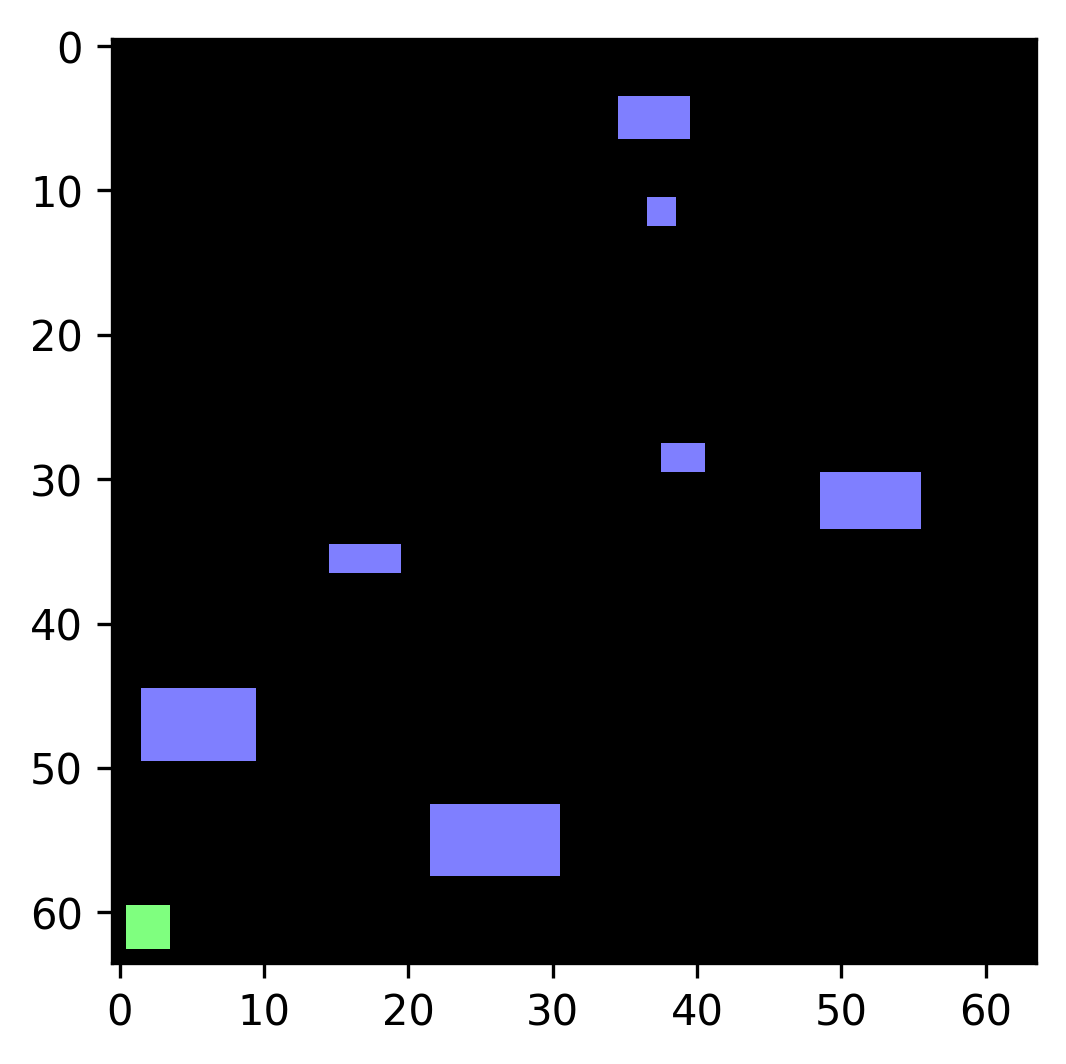

(3, 64, 64)


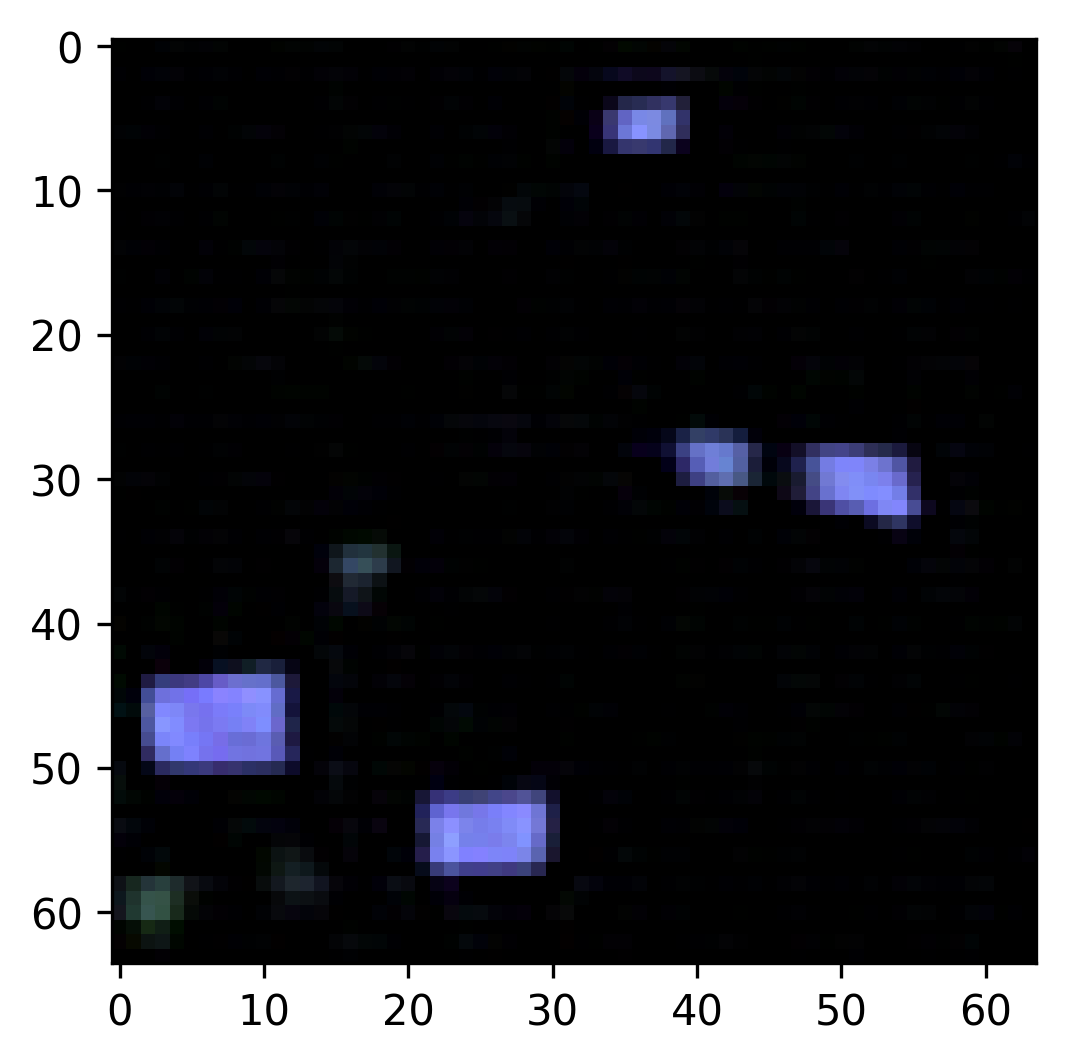

13
repr, std, cov, conv, closs 9.265406608581543 0.00039839744567871094 2.2491440176963806e-07 0.009986072778701782 0.24961090087890625
repr, std, cov, conv, closs 9.668360710144043 0.00039839744567871094 1.5273690223693848e-07 0.008916422724723816 0.2502382695674896
repr, std, cov, conv, closs 9.484477996826172 0.00039839744567871094 2.0279549062252045e-07 0.009738861583173275 0.24905610084533691
repr, std, cov, conv, closs 9.658417701721191 0.00039839744567871094 1.8975697457790375e-07 0.009202763438224792 0.24964627623558044
repr, std, cov, conv, closs 9.97425365447998 0.00039839744567871094 1.2014061212539673e-07 0.010846992954611778 0.2510542869567871
repr, std, cov, conv, closs 9.899394035339355 0.0003981590270996094 2.0745210349559784e-07 0.009291110560297966 0.251980185508728
repr, std, cov, conv, closs 9.407011985778809 0.00039649009704589844 4.2677856981754303e-07 0.008382890373468399 0.2501605153083801
repr, std, cov, conv, closs 9.478456497192383 0.0003960132598876953 3.960

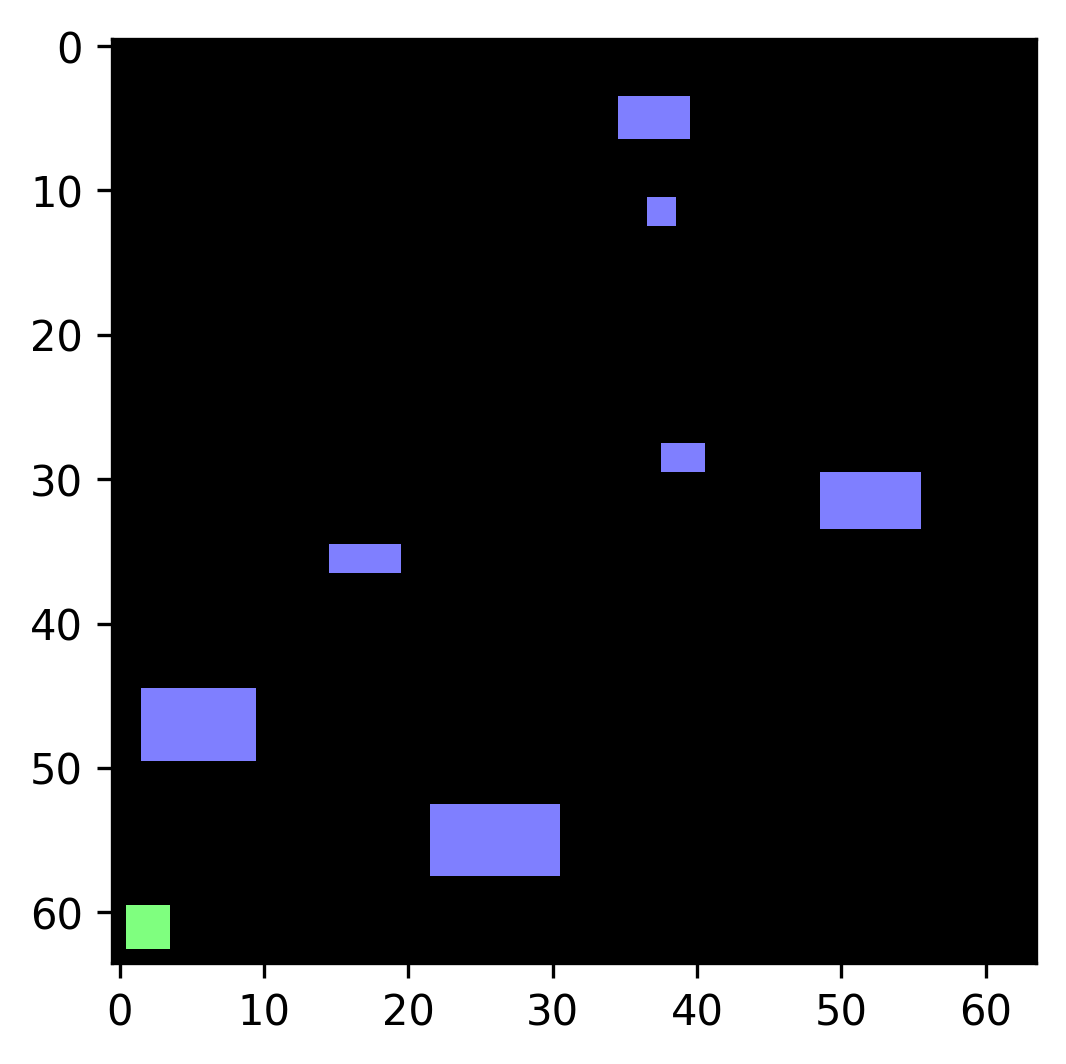

(3, 64, 64)


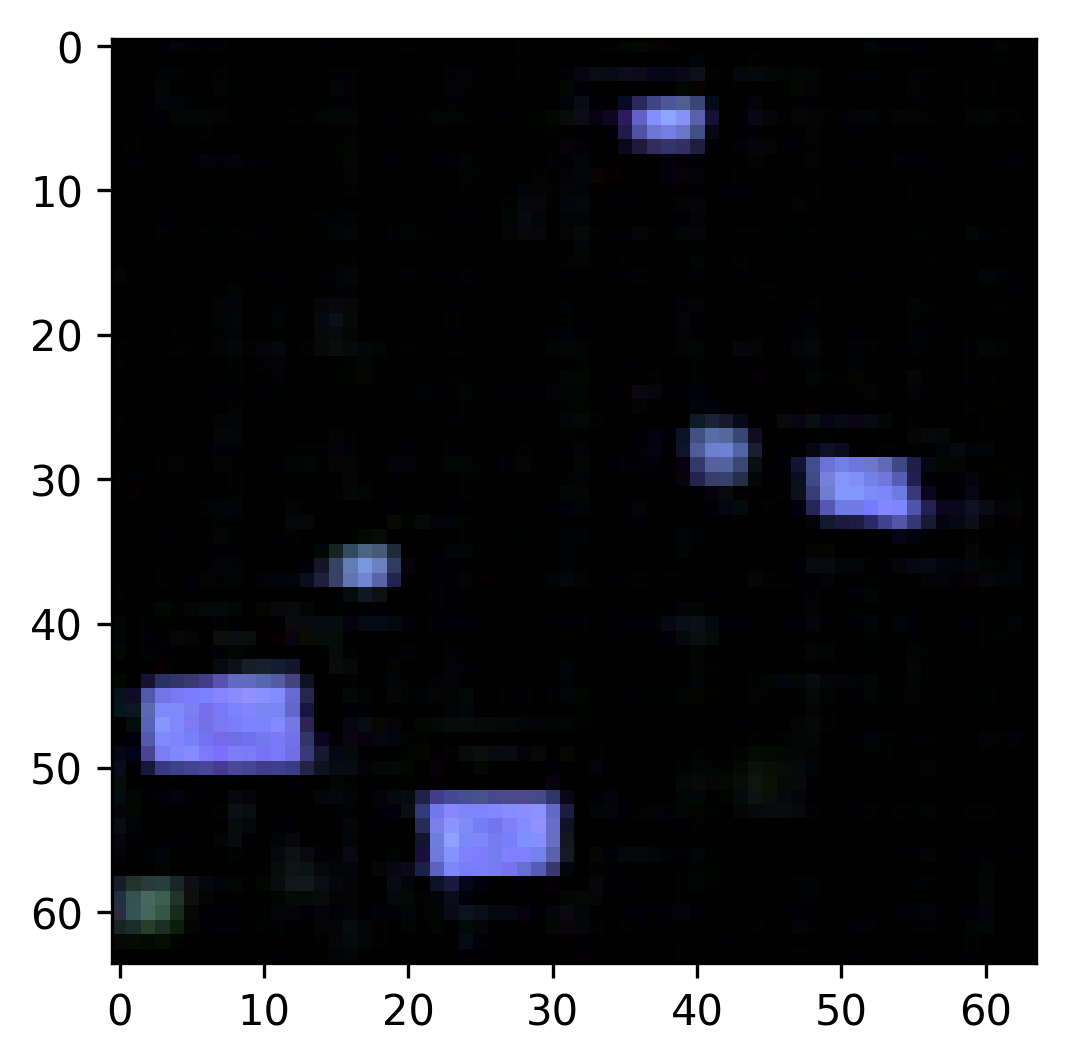

14
repr, std, cov, conv, closs 9.32124137878418 0.0003914833068847656 1.594889909029007e-07 0.008690275251865387 0.24823874235153198
repr, std, cov, conv, closs 9.357705116271973 0.0003914833068847656 1.2689270079135895e-07 0.008130633272230625 0.25032490491867065
repr, std, cov, conv, closs 9.280177116394043 0.0003910064697265625 1.8137507140636444e-07 0.008484646677970886 0.246192067861557
repr, std, cov, conv, closs 9.479267120361328 0.00039076805114746094 2.2351741790771484e-07 0.00921903271228075 0.25271740555763245
repr, std, cov, conv, closs 9.37027359008789 0.0003902912139892578 2.514570951461792e-07 0.008836462162435055 0.2572997212409973
repr, std, cov, conv, closs 9.490772247314453 0.0003898143768310547 2.591405063867569e-07 0.007760263048112392 0.25527215003967285
repr, std, cov, conv, closs 9.77678108215332 0.0003895759582519531 2.3096799850463867e-07 0.010858435183763504 0.2499925196170807
repr, std, cov, conv, closs 9.998079299926758 0.00038933753967285156 2.360902726650

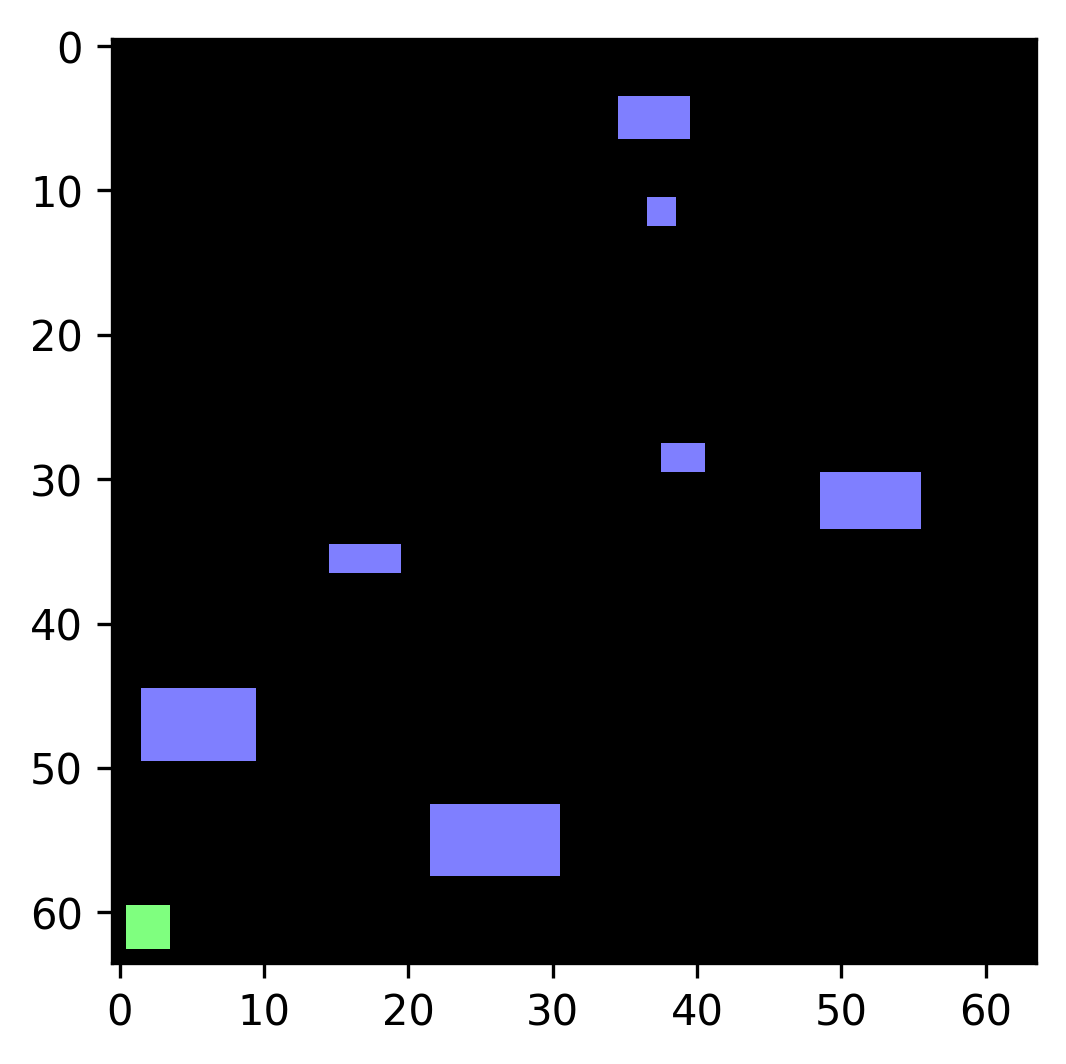

(3, 64, 64)


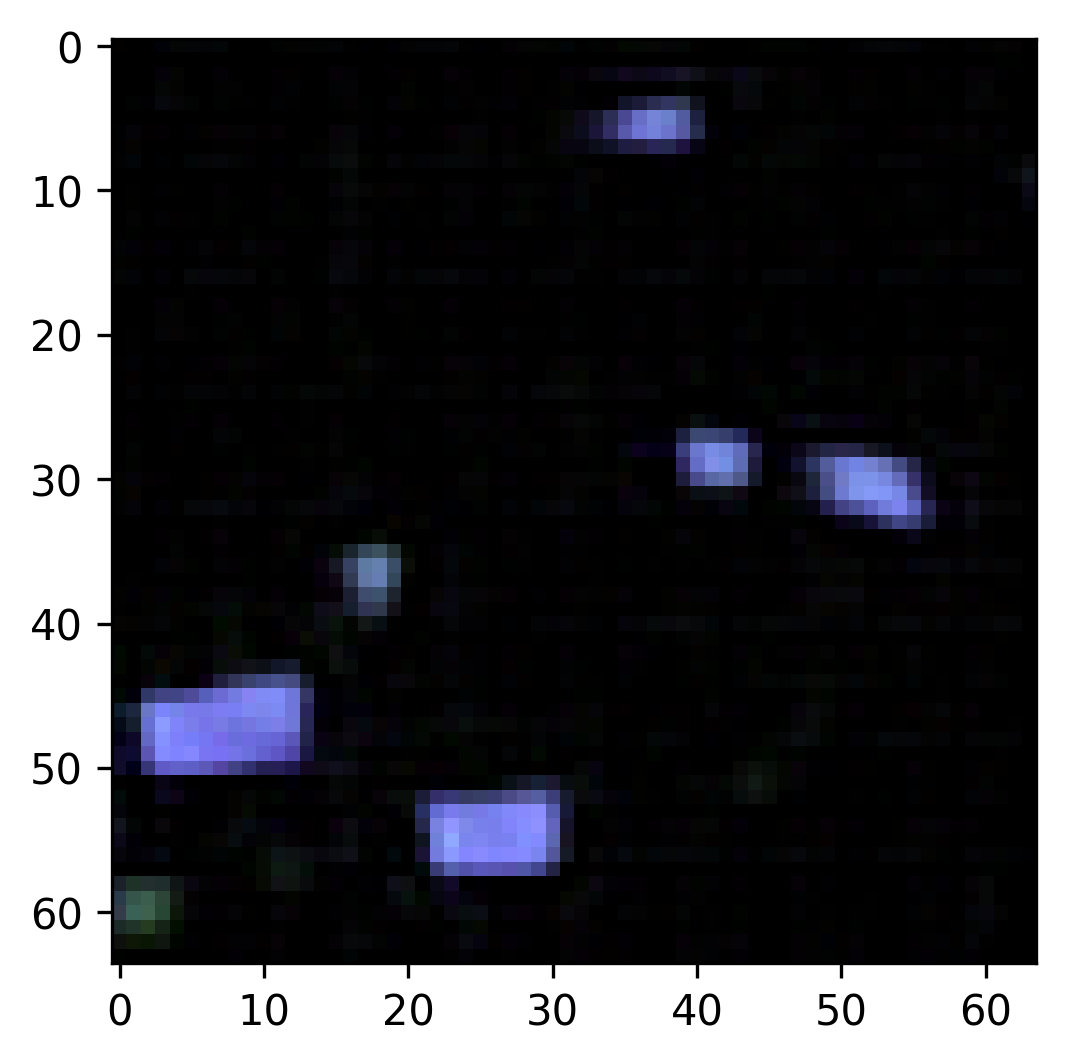

15
repr, std, cov, conv, closs 10.289408683776855 0.0003819465637207031 1.4016404747962952e-07 0.009463746100664139 0.24990564584732056
repr, std, cov, conv, closs 10.237740516662598 0.0003821849822998047 1.2246891856193542e-07 0.00826314091682434 0.2483694702386856
repr, std, cov, conv, closs 10.185330390930176 0.0003814697265625 2.3632310330867767e-07 0.008341295644640923 0.24856382608413696
repr, std, cov, conv, closs 10.36752986907959 0.00038123130798339844 1.8742866814136505e-07 0.009439684450626373 0.2518225610256195
repr, std, cov, conv, closs 10.656017303466797 0.0003800392150878906 2.3748725652694702e-07 0.009884808212518692 0.25093576312065125
repr, std, cov, conv, closs 10.420354843139648 0.0003800392150878906 2.3329630494117737e-07 0.010189563035964966 0.24981817603111267
repr, std, cov, conv, closs 10.70706844329834 0.0003790855407714844 2.9639340937137604e-07 0.009372853673994541 0.250805526971817
repr, std, cov, conv, closs 10.748013496398926 0.0003790855407714844 1.7299

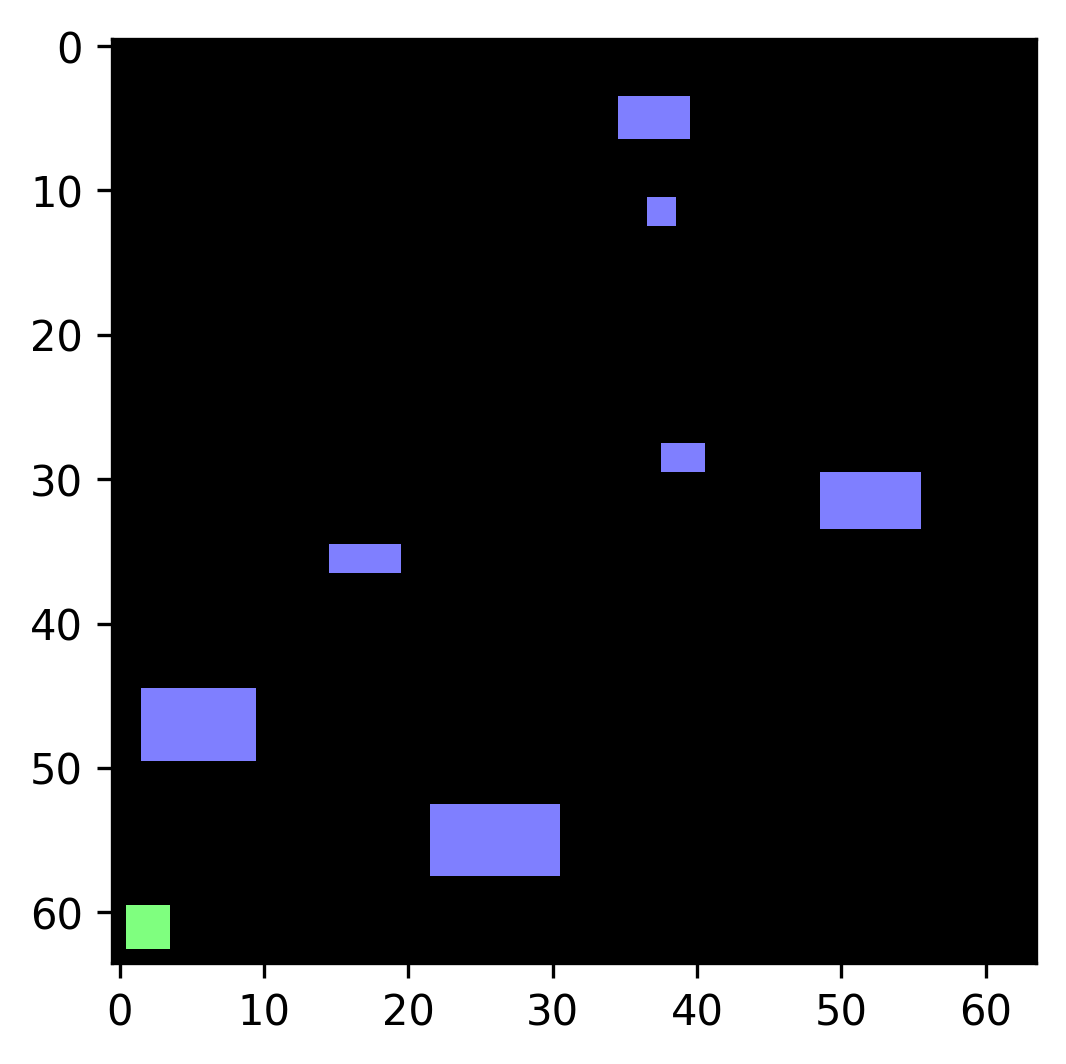

(3, 64, 64)


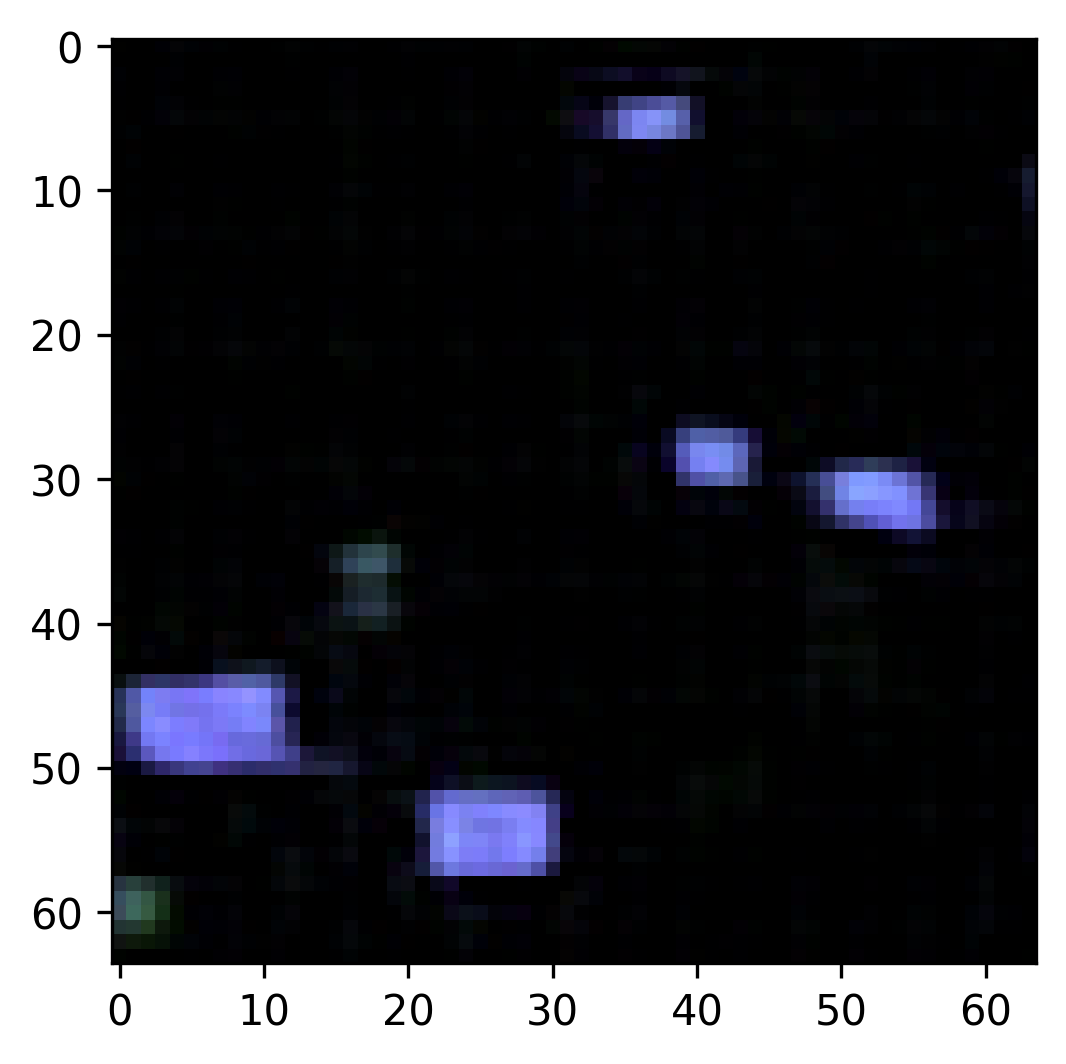

16
repr, std, cov, conv, closs 10.688525199890137 0.00037288665771484375 2.514570951461792e-07 0.00971092376857996 0.24310436844825745
repr, std, cov, conv, closs 10.906593322753906 0.0003731250762939453 1.3760291039943695e-07 0.009265555068850517 0.2545279860496521
repr, std, cov, conv, closs 10.942193031311035 0.0003726482391357422 1.9441358745098114e-07 0.009206697344779968 0.24836589395999908
repr, std, cov, conv, closs 10.778430938720703 0.0003726482391357422 1.816079020500183e-07 0.007505509071052074 0.24909785389900208
repr, std, cov, conv, closs 10.703556060791016 0.00037288665771484375 1.1734664440155029e-07 0.00895996019244194 0.24981993436813354
repr, std, cov, conv, closs 11.053633689880371 0.00037288665771484375 9.592622518539429e-08 0.008954297751188278 0.2541162371635437
repr, std, cov, conv, closs 10.715718269348145 0.0003719329833984375 2.789311110973358e-07 0.00741537194699049 0.25291967391967773
repr, std, cov, conv, closs 11.001489639282227 0.00037217140197753906 1.

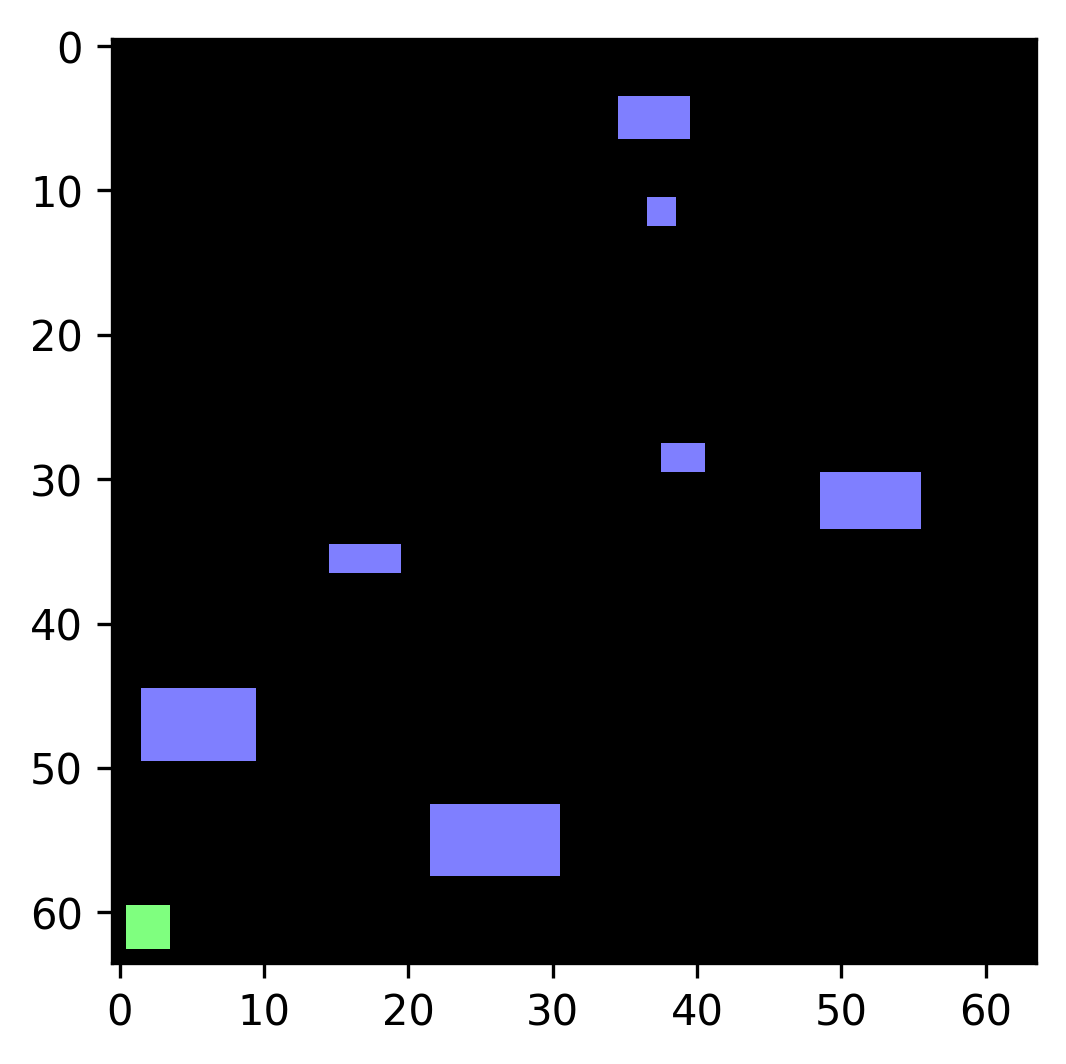

(3, 64, 64)


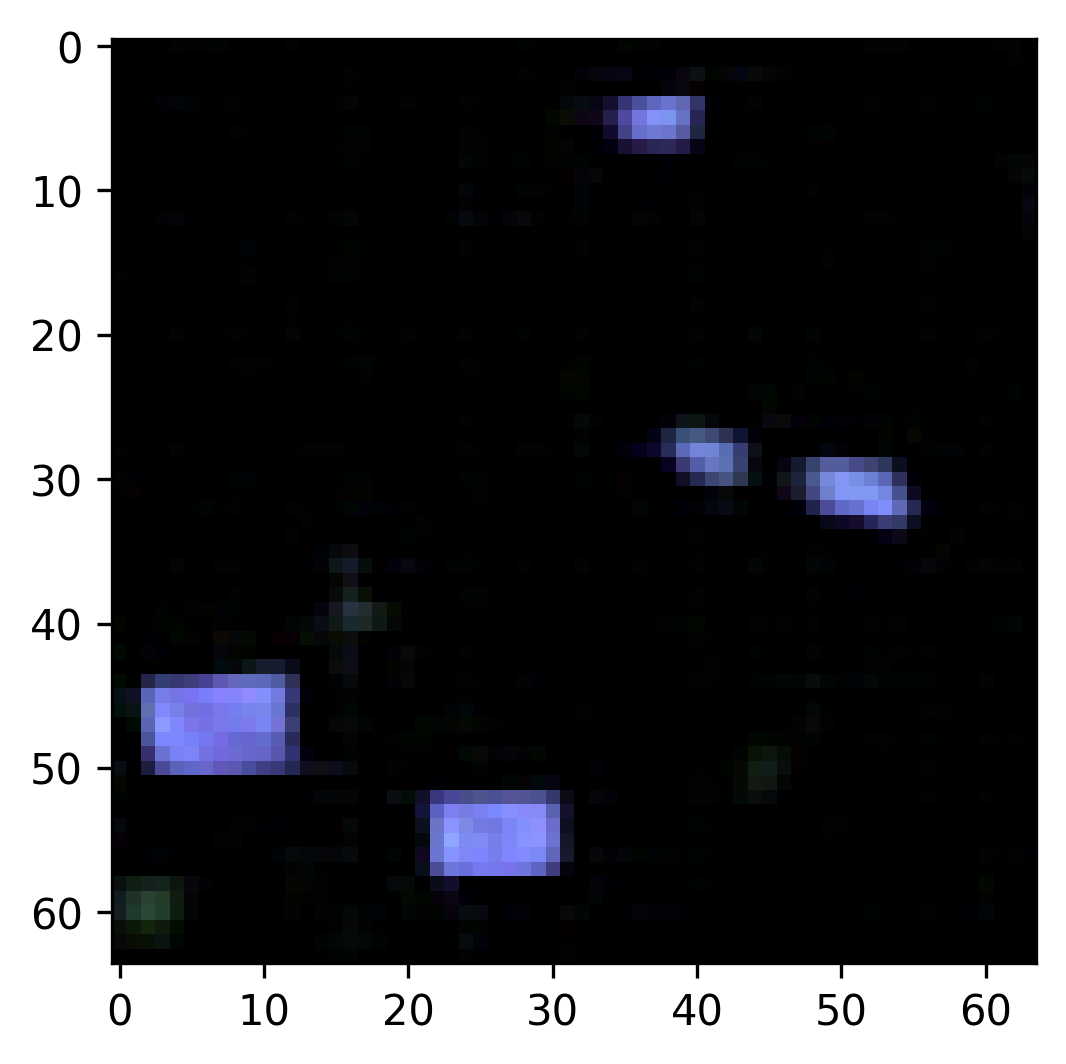

17
repr, std, cov, conv, closs 11.202606201171875 0.0003647804260253906 1.4901161193847656e-07 0.008967495523393154 0.24860253930091858
repr, std, cov, conv, closs 11.514921188354492 0.0003647804260253906 1.5902332961559296e-07 0.008446860127151012 0.24894776940345764
repr, std, cov, conv, closs 11.899428367614746 0.0003647804260253906 1.2828968465328217e-07 0.009892024099826813 0.2498246729373932
repr, std, cov, conv, closs 11.974159240722656 0.0003647804260253906 1.2246891856193542e-07 0.009504253976047039 0.25203937292099
repr, std, cov, conv, closs 11.208938598632812 0.00036406517028808594 1.3899989426136017e-07 0.008032860234379768 0.25052374601364136
repr, std, cov, conv, closs 11.621265411376953 0.00036334991455078125 1.5902332961559296e-07 0.008580374531447887 0.2503535747528076
repr, std, cov, conv, closs 11.794955253601074 0.0003635883331298828 9.755603969097137e-08 0.011305602267384529 0.24986723065376282
repr, std, cov, conv, closs 12.144567489624023 0.0003635883331298828 1

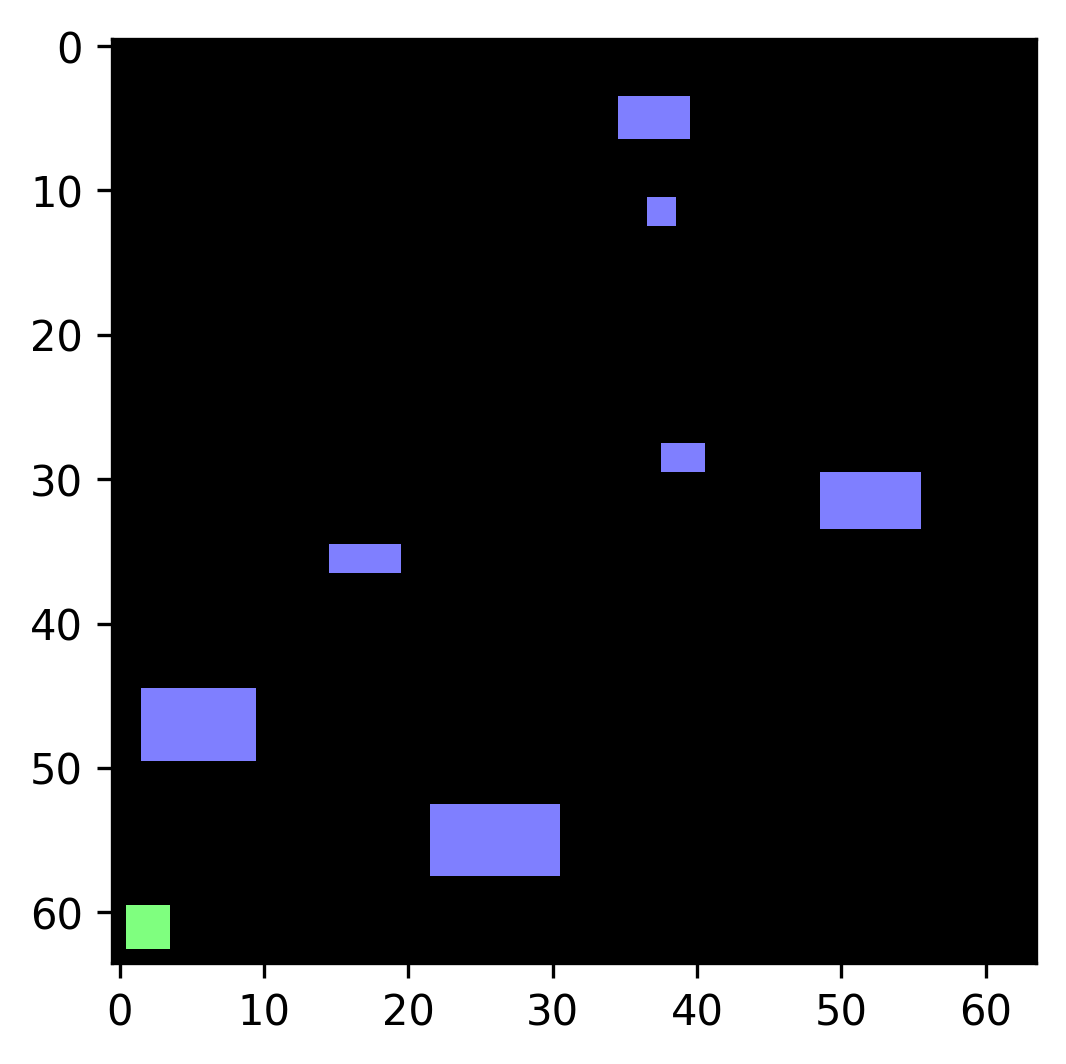

(3, 64, 64)


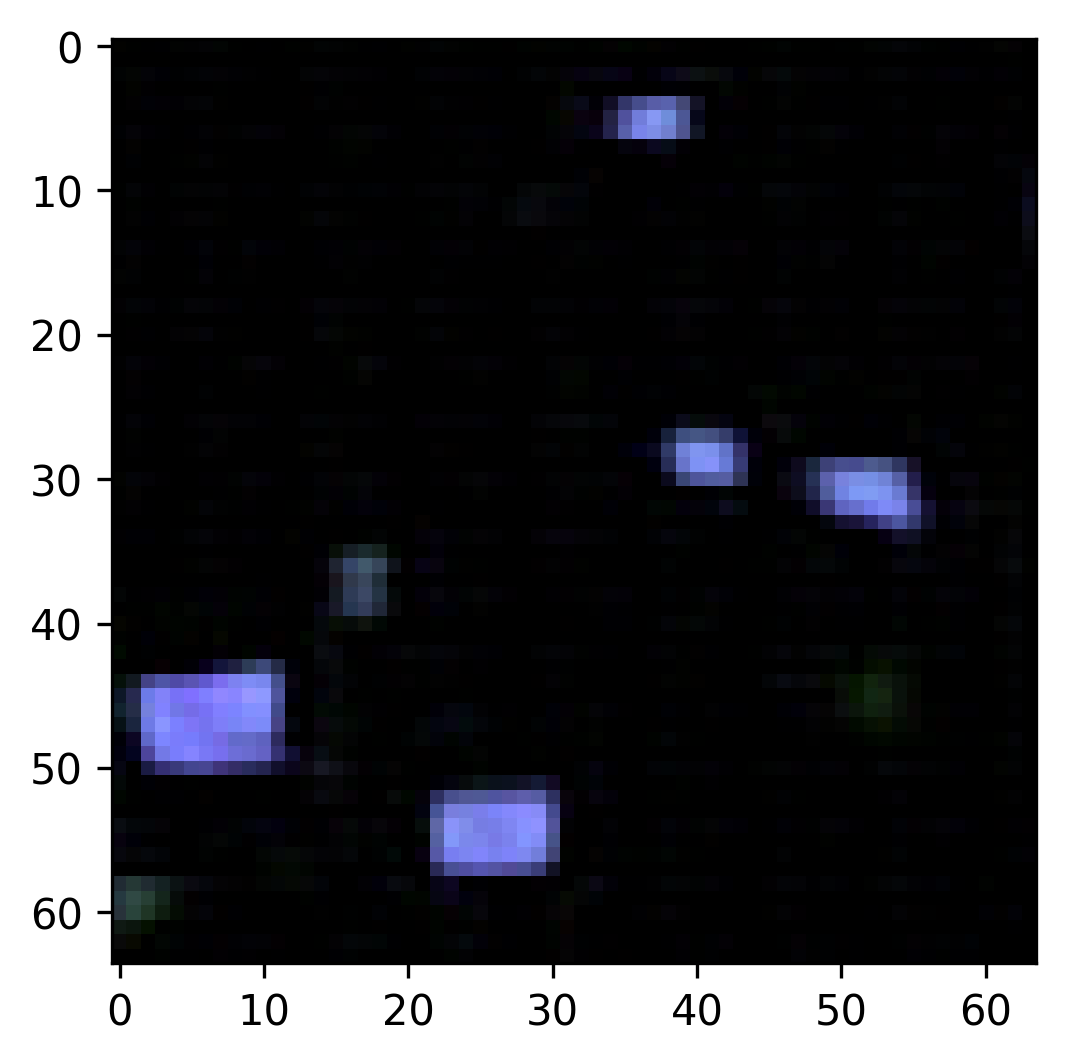

18
repr, std, cov, conv, closs 11.992470741271973 0.0003578662872314453 8.917413651943207e-08 0.009241167455911636 0.2500844895839691
repr, std, cov, conv, closs 11.959880828857422 0.00035762786865234375 1.3969838619232178e-07 0.008019457571208477 0.2496335804462433
repr, std, cov, conv, closs 12.25352954864502 0.00035762786865234375 1.310836523771286e-07 0.010375279933214188 0.24851784110069275
repr, std, cov, conv, closs 12.672469139099121 0.00035762786865234375 1.2479722499847412e-07 0.010677879676222801 0.2517426013946533
repr, std, cov, conv, closs 12.196084976196289 0.00035762786865234375 1.2922100722789764e-07 0.009153041988611221 0.2511831521987915
repr, std, cov, conv, closs 12.634005546569824 0.0003573894500732422 1.0151416063308716e-07 0.008449969813227654 0.25075480341911316
repr, std, cov, conv, closs 12.39040470123291 0.00035643577575683594 1.8300488591194153e-07 0.008824598975479603 0.24876755475997925
repr, std, cov, conv, closs 12.781224250793457 0.00035572052001953125

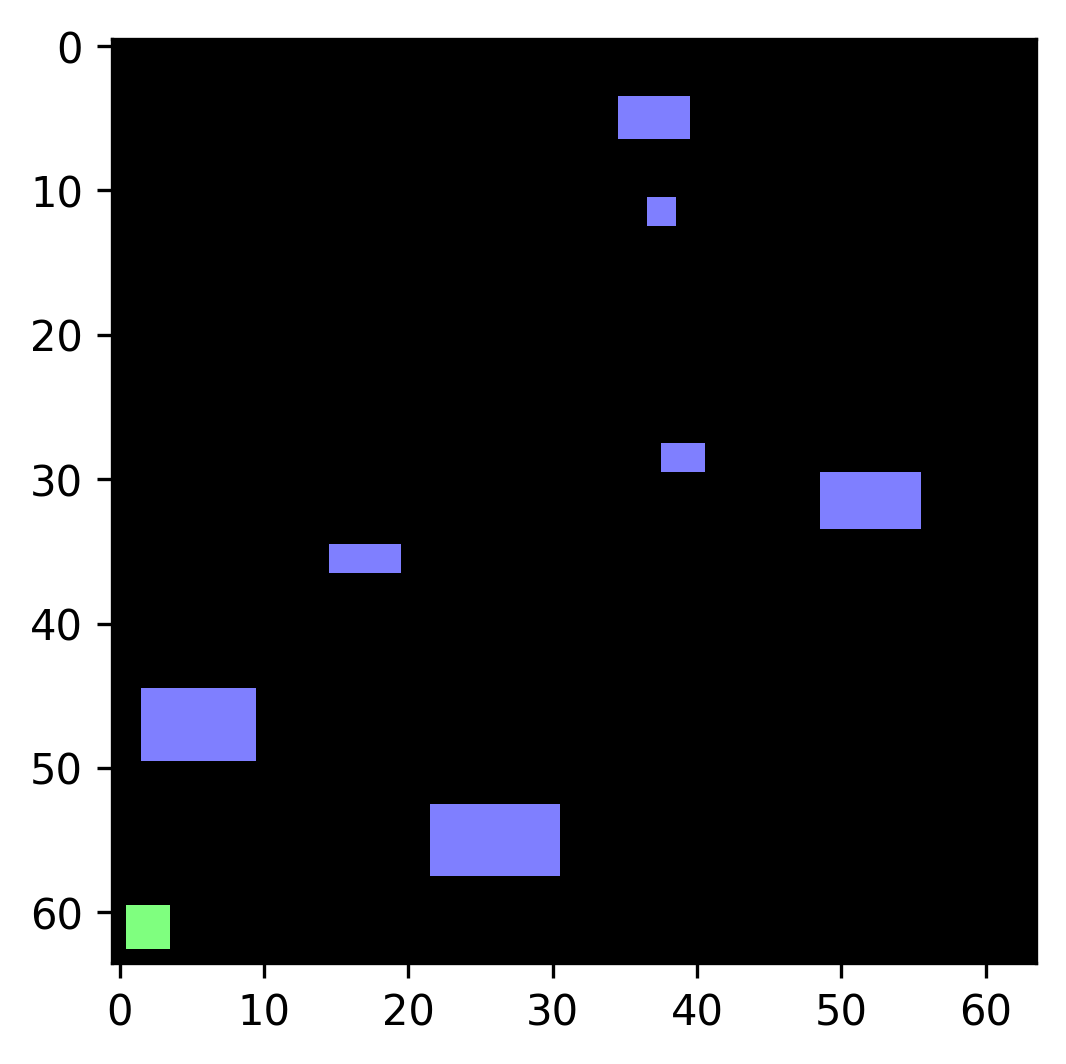

(3, 64, 64)


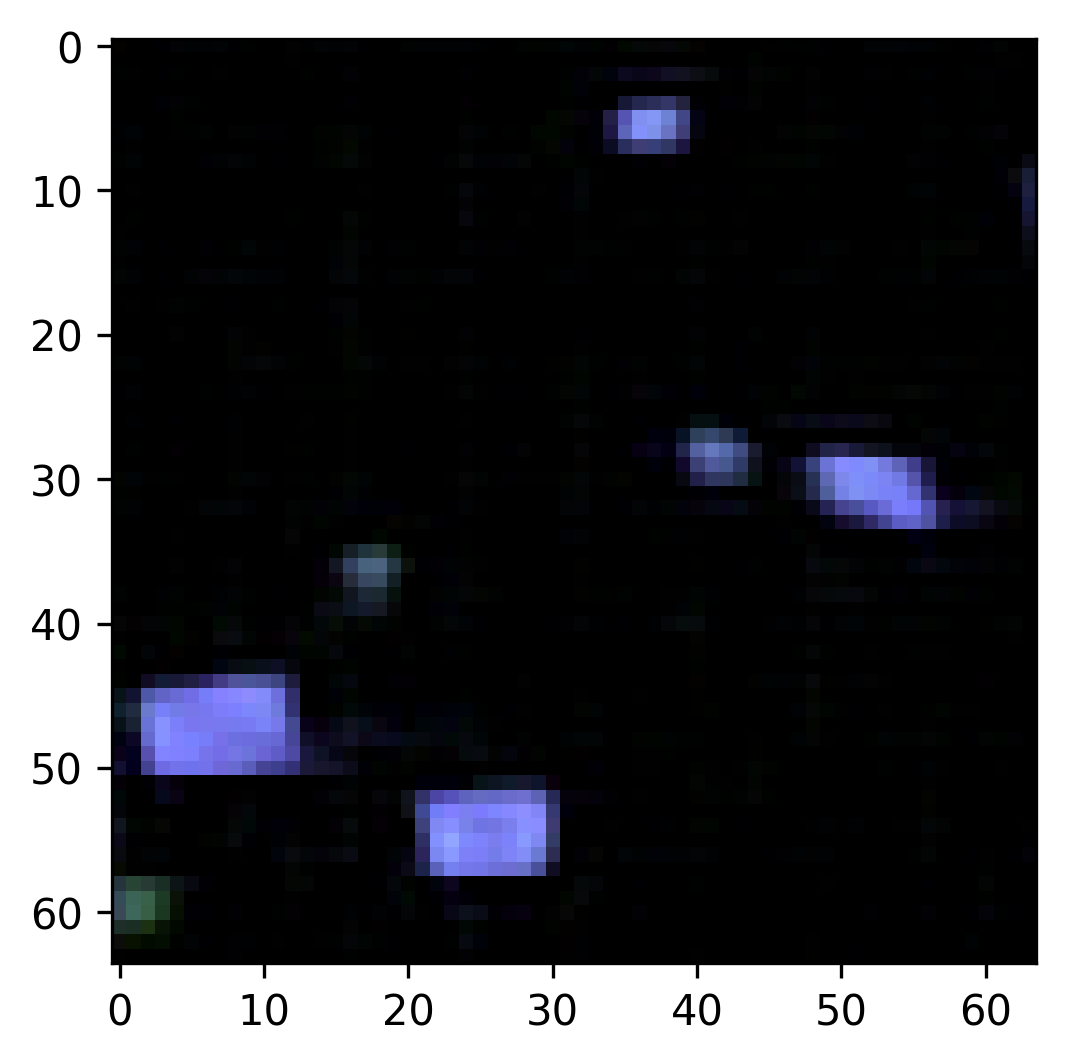

19
repr, std, cov, conv, closs 12.791481018066406 0.00034928321838378906 1.2619420886039734e-07 0.009114916436374187 0.2506808042526245
repr, std, cov, conv, closs 13.535552978515625 0.00034928321838378906 5.2386894822120667e-08 0.010735618881881237 0.24993053078651428
repr, std, cov, conv, closs 12.713458061218262 0.00034880638122558594 1.578591763973236e-07 0.008840847760438919 0.24951592087745667
repr, std, cov, conv, closs 13.048005104064941 0.0003483295440673828 1.441221684217453e-07 0.008154885843396187 0.25007379055023193
repr, std, cov, conv, closs 12.844573020935059 0.0003483295440673828 1.2316741049289703e-07 0.00831272080540657 0.24892424046993256
repr, std, cov, conv, closs 13.081639289855957 0.0003485679626464844 7.566995918750763e-08 0.00885738991200924 0.2521204948425293
repr, std, cov, conv, closs 12.95749282836914 0.0003483295440673828 9.266659617424011e-08 0.008692672476172447 0.2524997591972351
repr, std, cov, conv, closs 13.625802040100098 0.0003483295440673828 1.39

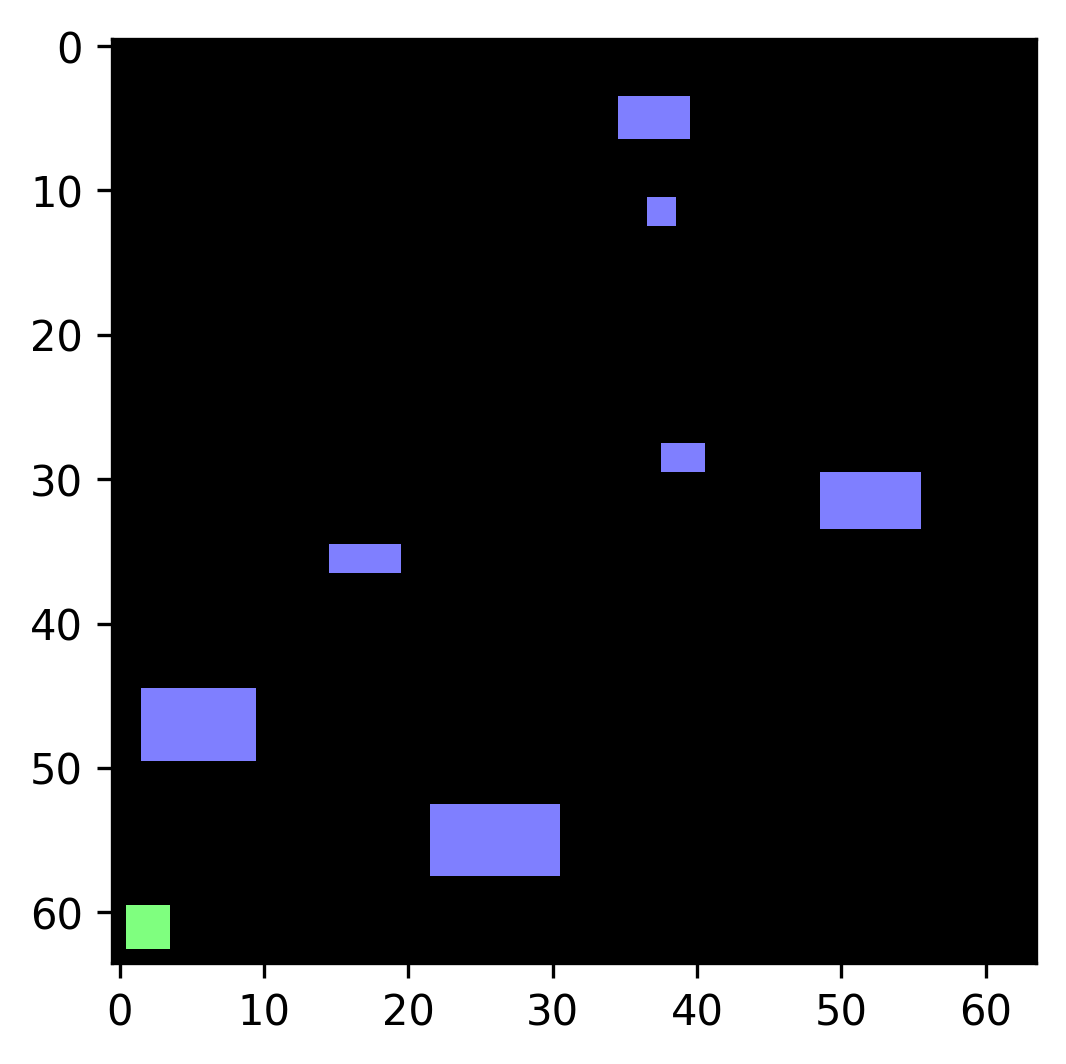

(3, 64, 64)


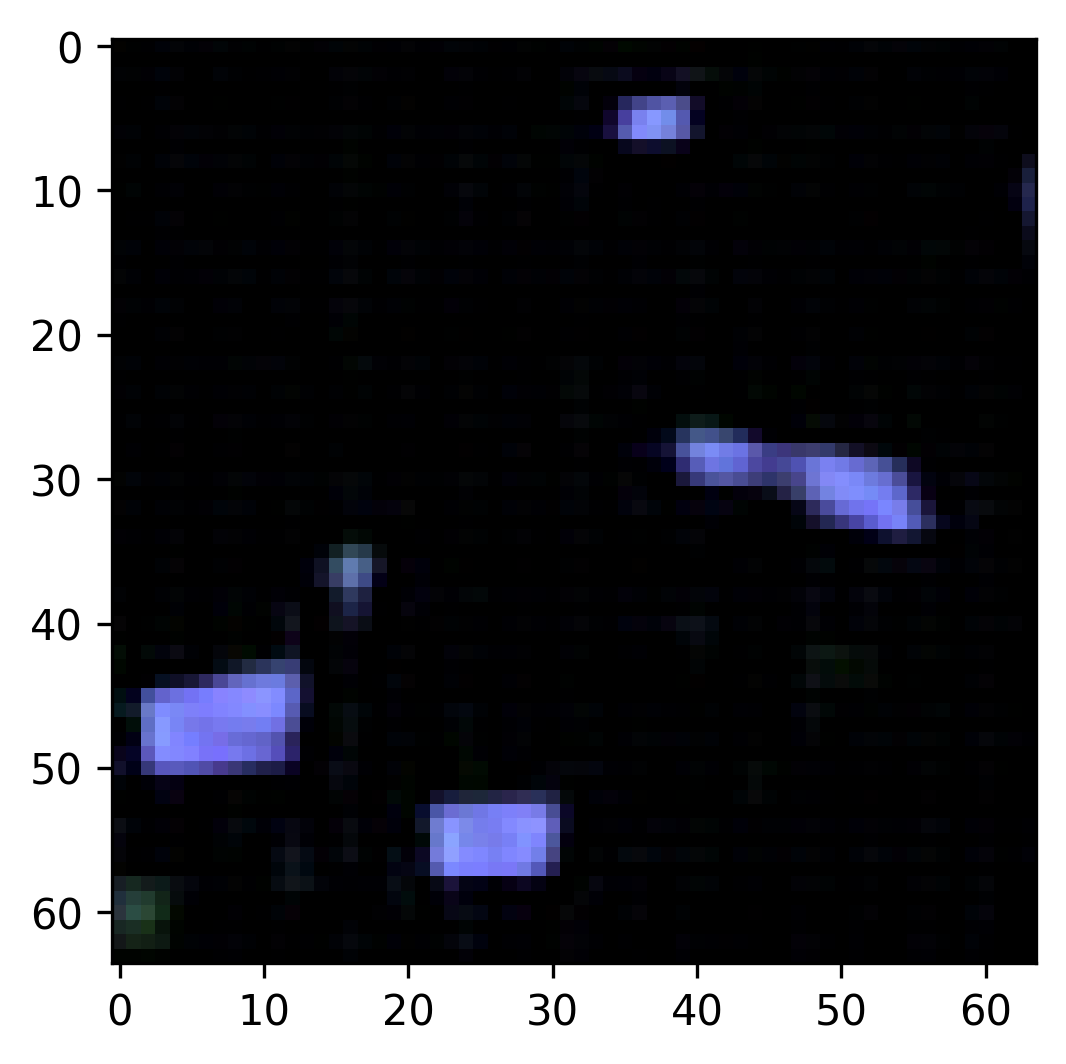

20
repr, std, cov, conv, closs 13.771468162536621 0.0003409385681152344 5.75091689825058e-08 0.009123423136770725 0.25948357582092285
repr, std, cov, conv, closs 13.74203872680664 0.0003409385681152344 5.3783878684043884e-08 0.009271306917071342 0.2510540187358856
repr, std, cov, conv, closs 13.975262641906738 0.0003407001495361328 7.241033017635345e-08 0.009508587419986725 0.24903735518455505
repr, std, cov, conv, closs 14.420315742492676 0.0003407001495361328 6.542541086673737e-08 0.008507232181727886 0.24836894869804382
repr, std, cov, conv, closs 14.207403182983398 0.0003407001495361328 7.450580596923828e-08 0.010010196827352047 0.2479351907968521
repr, std, cov, conv, closs 14.506738662719727 0.0003402233123779297 1.0523945093154907e-07 0.010808296501636505 0.2513936758041382
repr, std, cov, conv, closs 13.926307678222656 0.0003390312194824219 1.1990778148174286e-07 0.009235255420207977 0.2497575581073761
repr, std, cov, conv, closs 14.115235328674316 0.00033855438232421875 1.5995

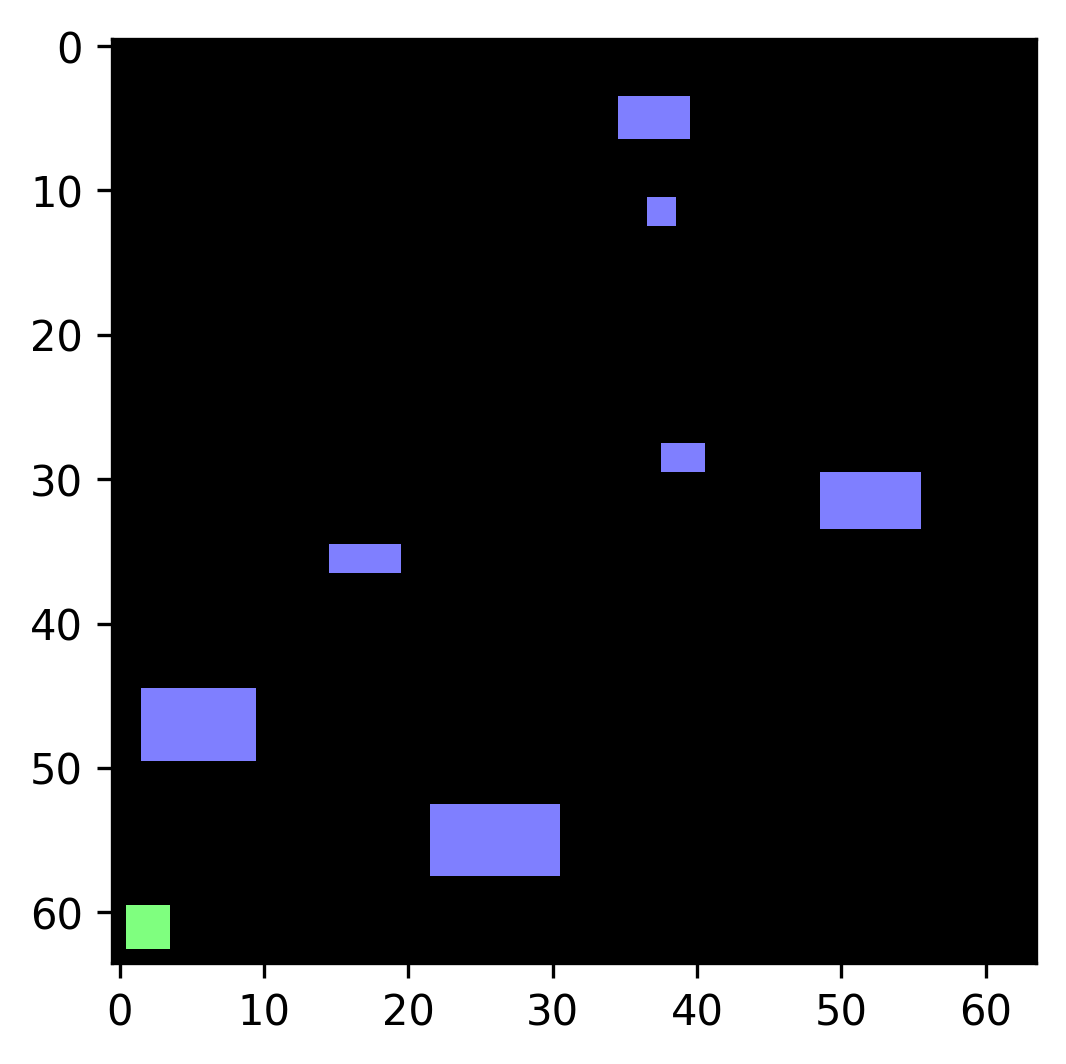

(3, 64, 64)


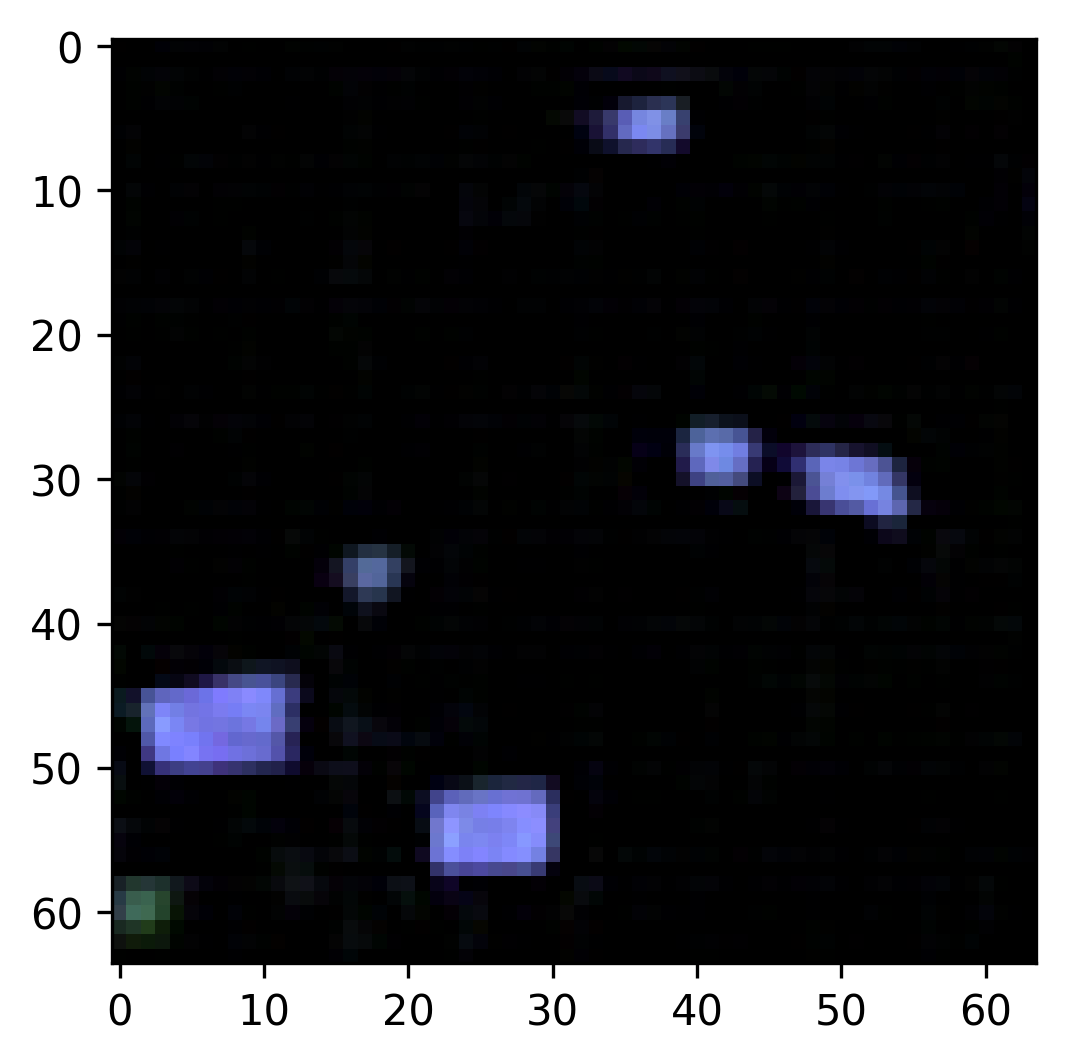

21
repr, std, cov, conv, closs 14.94101619720459 0.0003330707550048828 1.3597309589385986e-07 0.008906292729079723 0.2498272955417633
repr, std, cov, conv, closs 15.295703887939453 0.0003325939178466797 2.2444874048233032e-07 0.009080525487661362 0.2514141798019409
repr, std, cov, conv, closs 15.179068565368652 0.00033211708068847656 1.1199153959751129e-07 0.009456793777644634 0.24902182817459106
repr, std, cov, conv, closs 15.494062423706055 0.0003323554992675781 8.079223334789276e-08 0.00980444997549057 0.2545831501483917
repr, std, cov, conv, closs 14.709416389465332 0.00033164024353027344 1.1944212019443512e-07 0.008699843659996986 0.2509576678276062
repr, std, cov, conv, closs 15.041439056396484 0.000331878662109375 7.031485438346863e-08 0.008286925032734871 0.2501152753829956
repr, std, cov, conv, closs 15.05922794342041 0.00033164024353027344 9.42964106798172e-08 0.009339714422821999 0.25116175413131714
repr, std, cov, conv, closs 15.223700523376465 0.000331878662109375 2.374872

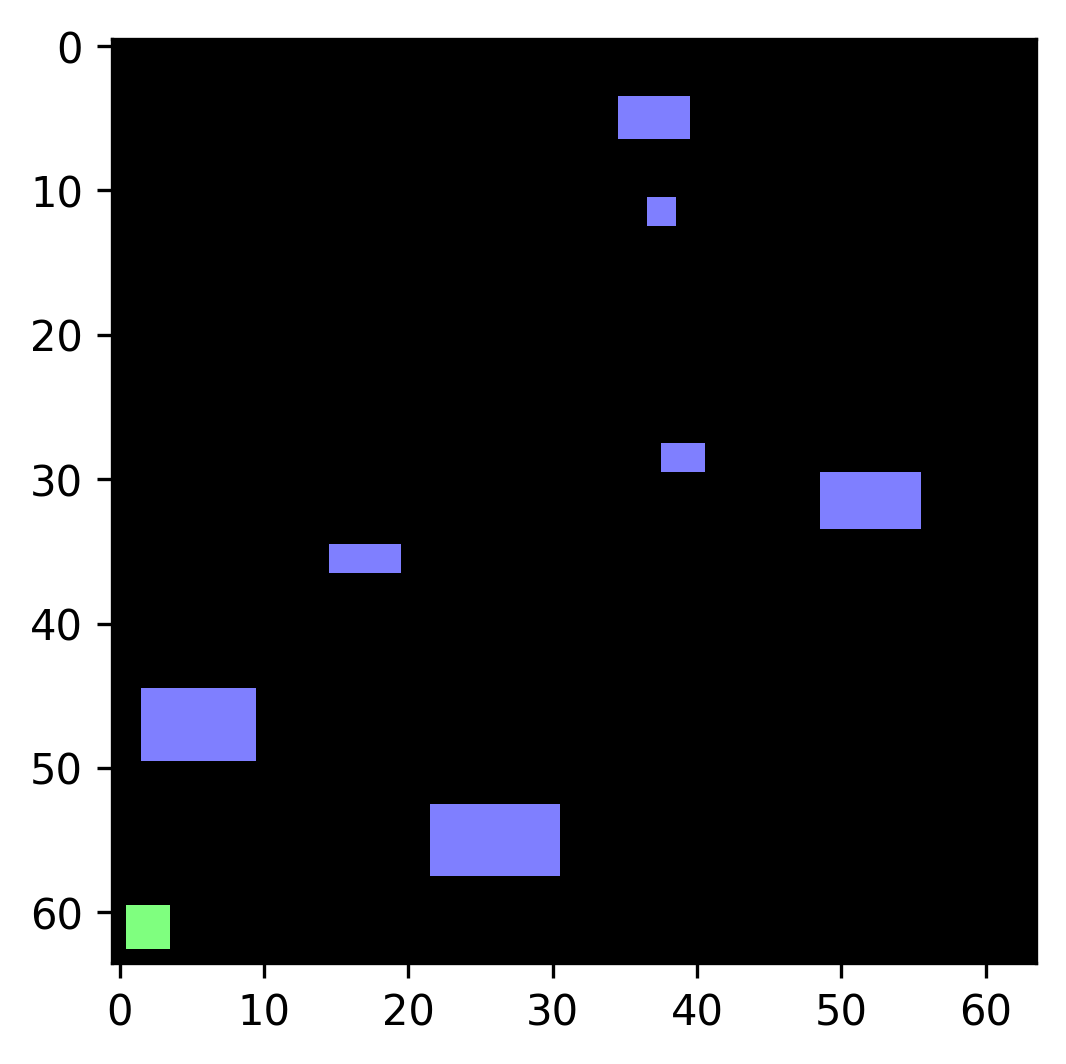

(3, 64, 64)


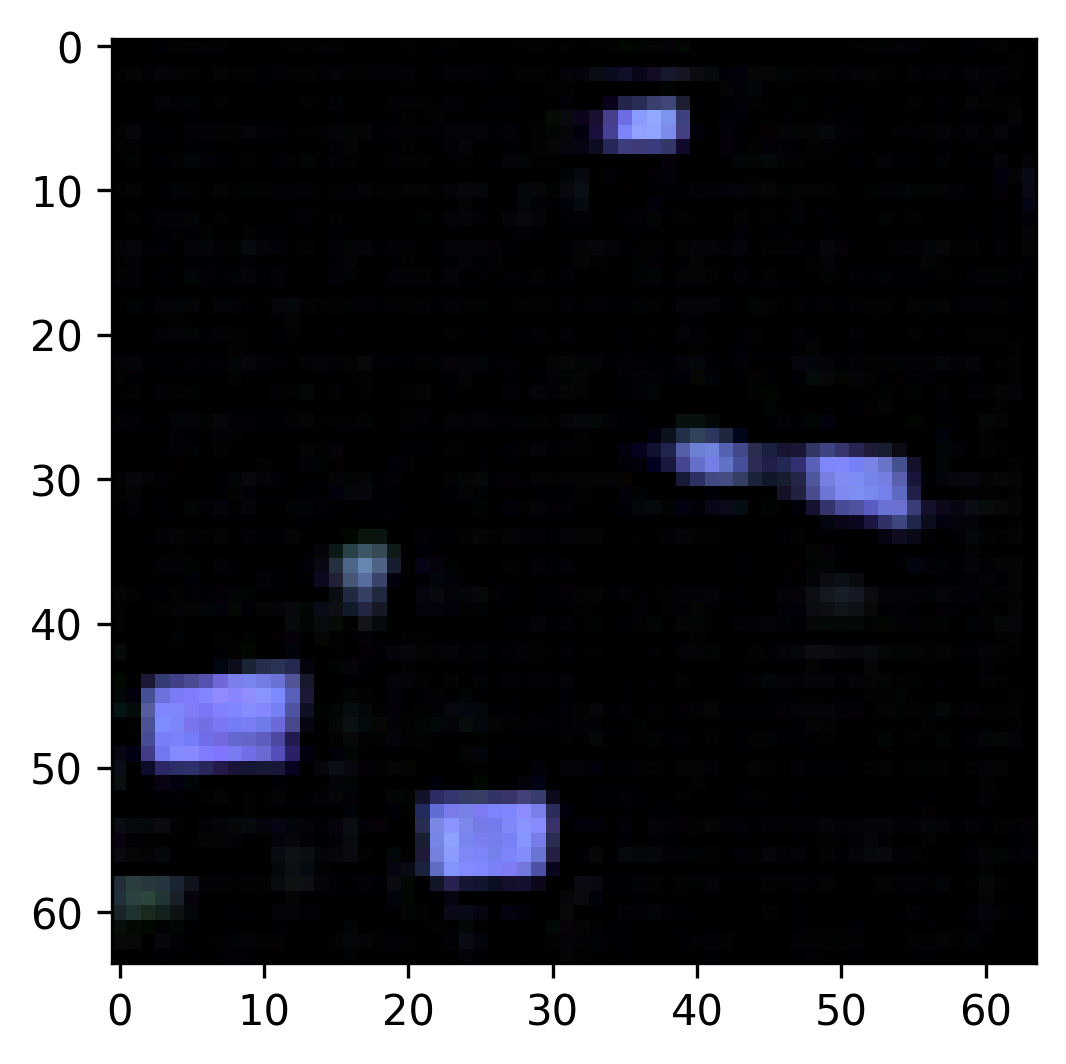

22
repr, std, cov, conv, closs 15.95456600189209 0.0003261566162109375 8.777715265750885e-08 0.009408831596374512 0.24477440118789673
repr, std, cov, conv, closs 16.366588592529297 0.0003261566162109375 6.868503987789154e-08 0.009180206805467606 0.25231143832206726
repr, std, cov, conv, closs 15.913691520690918 0.0003249645233154297 1.0803341865539551e-07 0.0089003536850214 0.24612319469451904
repr, std, cov, conv, closs 16.265716552734375 0.000324249267578125 9.615905582904816e-08 0.009842941537499428 0.2505253553390503
repr, std, cov, conv, closs 16.12973403930664 0.00032329559326171875 9.592622518539429e-08 0.01070518046617508 0.2511511445045471
repr, std, cov, conv, closs 16.238508224487305 0.0003230571746826172 1.3457611203193665e-07 0.009585408493876457 0.2479085922241211
repr, std, cov, conv, closs 15.940287590026855 0.0003230571746826172 9.639188647270203e-08 0.009146176278591156 0.2479807287454605
repr, std, cov, conv, closs 15.847081184387207 0.0003230571746826172 5.285255610

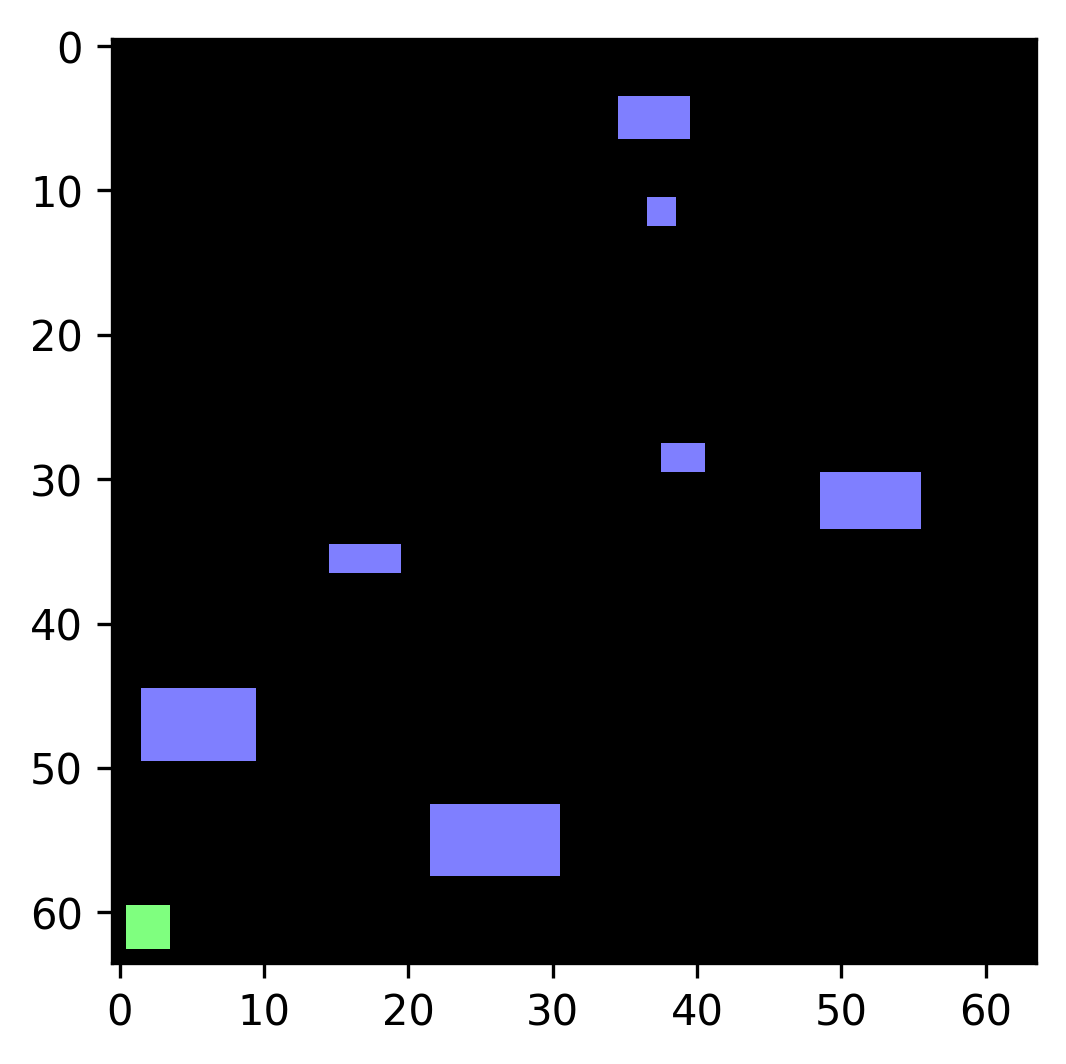

(3, 64, 64)


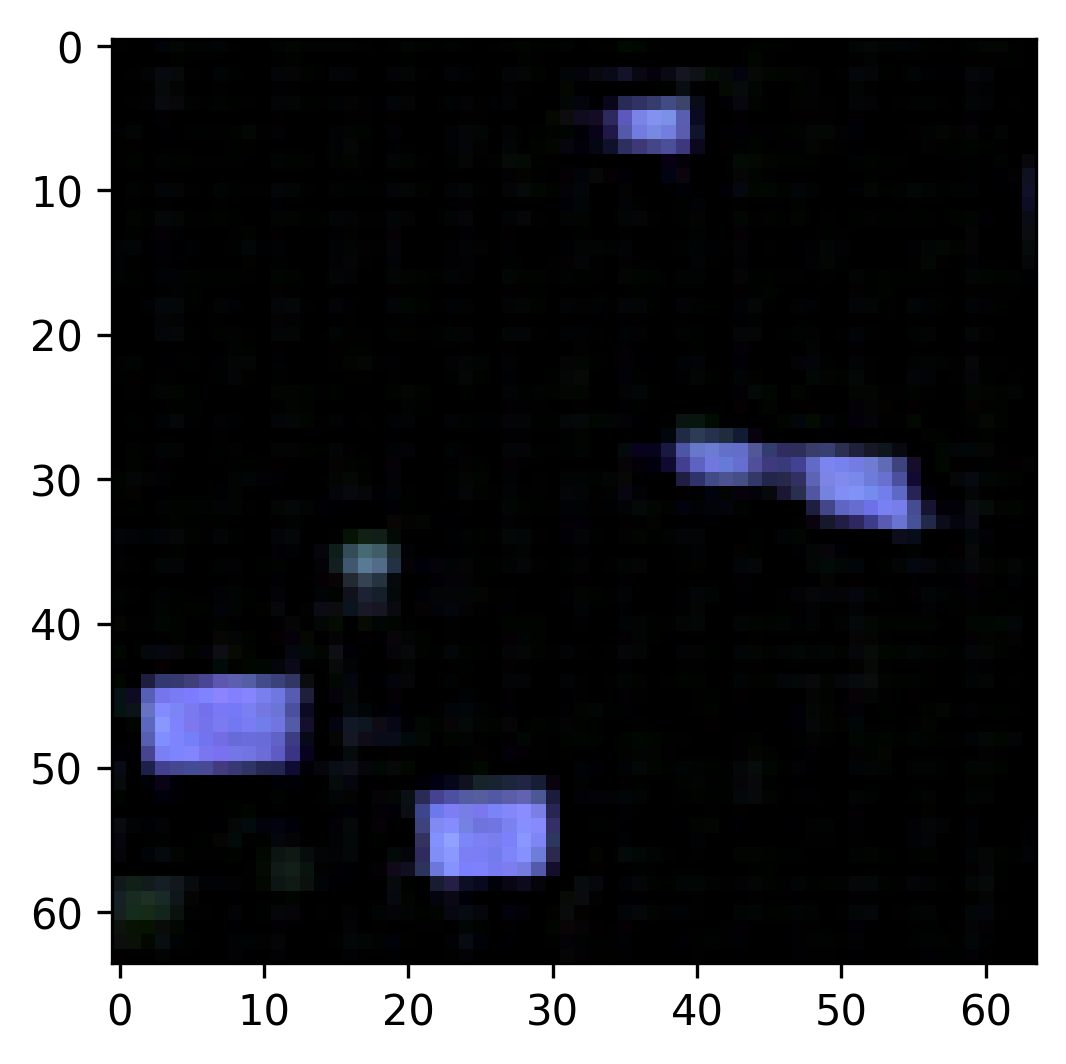

23
repr, std, cov, conv, closs 16.587974548339844 0.0003180503845214844 4.0978193283081055e-08 0.008826111443340778 0.2501569390296936
repr, std, cov, conv, closs 16.779556274414062 0.0003178119659423828 6.845220923423767e-08 0.008283168077468872 0.25022757053375244
repr, std, cov, conv, closs 17.45310401916504 0.0003173351287841797 7.59027898311615e-08 0.010460643097758293 0.2513660788536072
repr, std, cov, conv, closs 17.369266510009766 0.0003170967102050781 6.28642737865448e-08 0.009983764961361885 0.24986232817173004
repr, std, cov, conv, closs 16.509855270385742 0.00031685829162597656 8.172355592250824e-08 0.00879073515534401 0.2507442235946655
repr, std, cov, conv, closs 16.7935848236084 0.000316619873046875 6.28642737865448e-08 0.007890650071203709 0.24984678626060486
repr, std, cov, conv, closs 16.350887298583984 0.00031638145446777344 6.612390279769897e-08 0.008716601878404617 0.2497057169675827
repr, std, cov, conv, closs 16.684354782104492 0.000316619873046875 3.958120942115

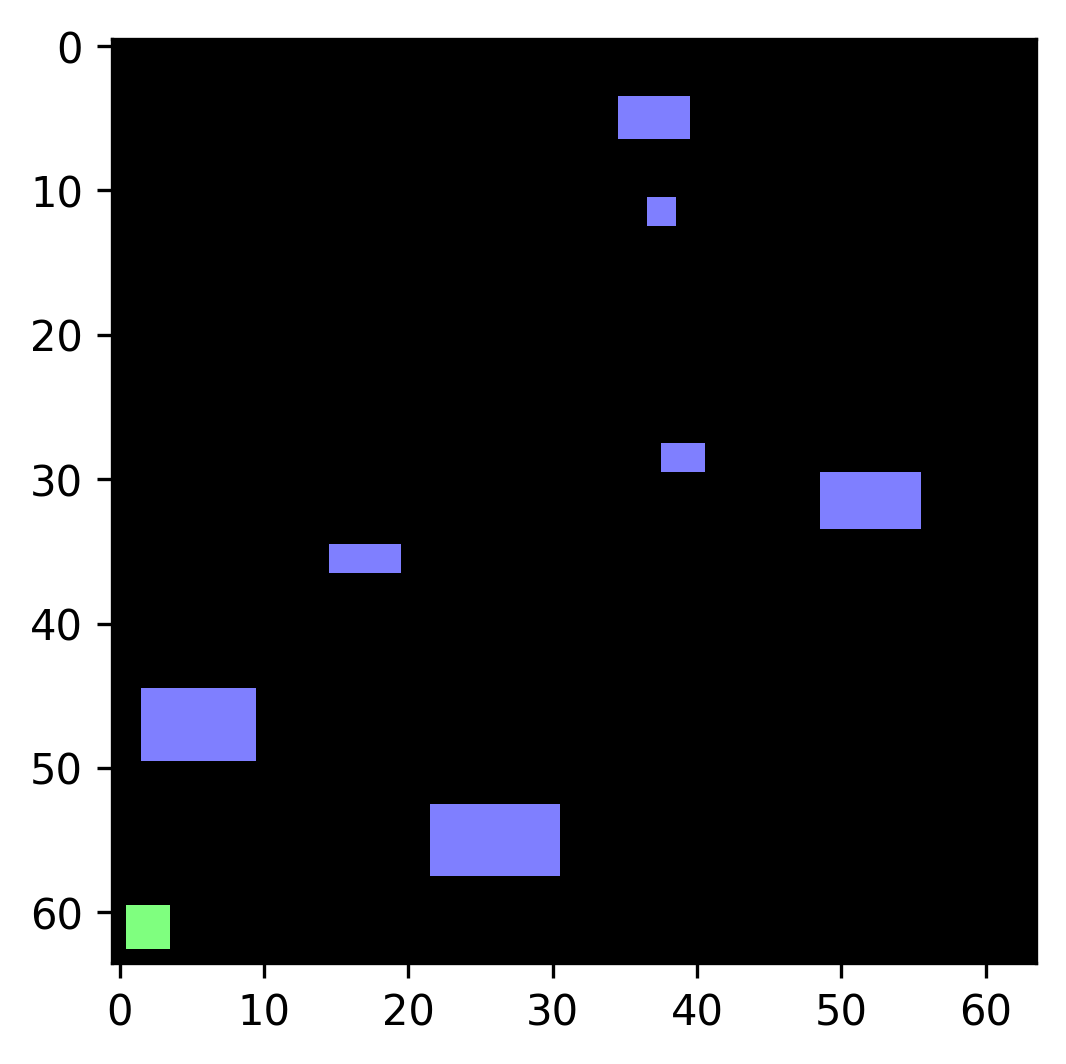

(3, 64, 64)


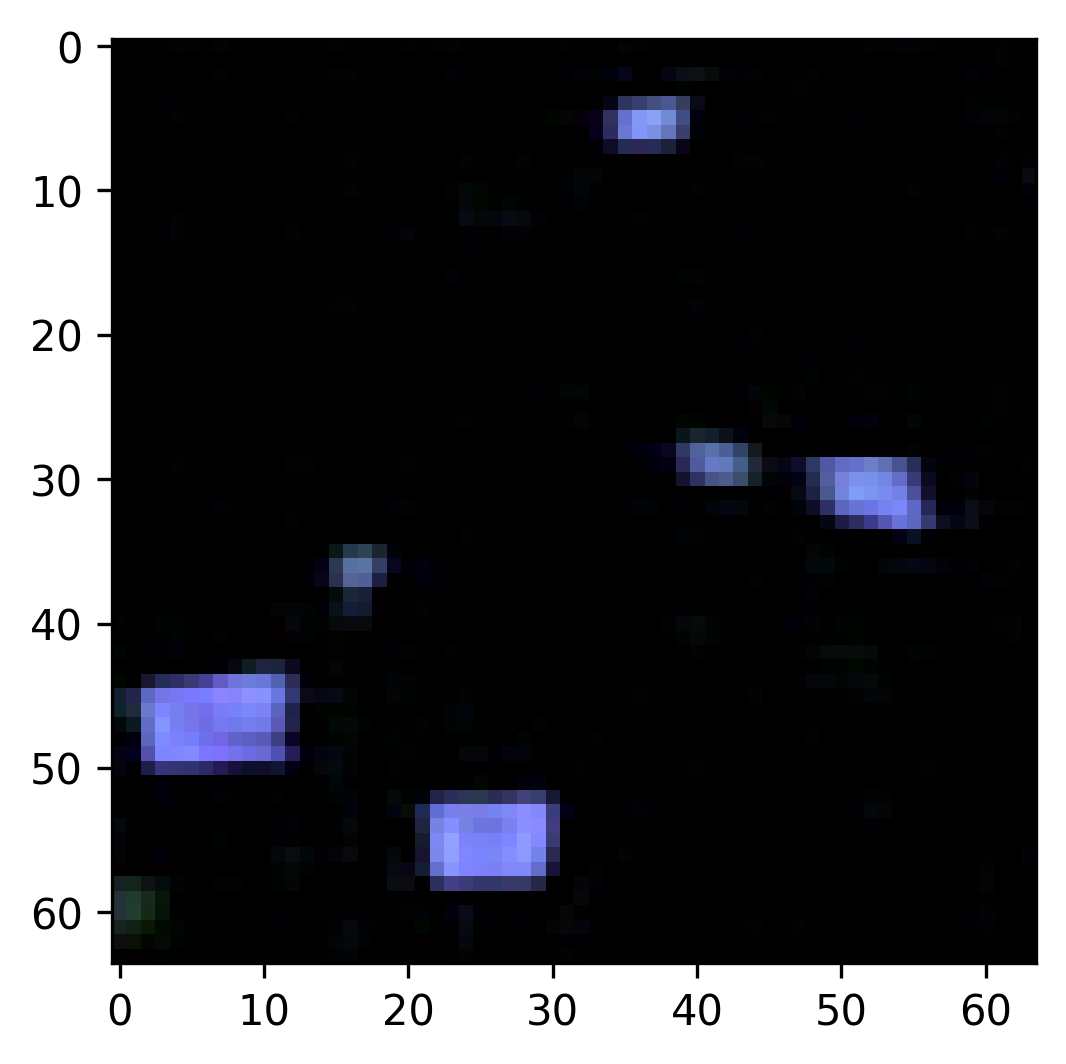

24
repr, std, cov, conv, closs 16.285837173461914 0.00030994415283203125 1.1199153959751129e-07 0.0067797815427184105 0.2514260411262512
repr, std, cov, conv, closs 16.743139266967773 0.0003094673156738281 8.055940270423889e-08 0.007197122555226088 0.24824607372283936
repr, std, cov, conv, closs 17.311859130859375 0.0003097057342529297 4.7730281949043274e-08 0.008553341031074524 0.25321730971336365
repr, std, cov, conv, closs 16.93741226196289 0.0003094673156738281 7.008202373981476e-08 0.008366134017705917 0.24742832779884338
repr, std, cov, conv, closs 18.078475952148438 0.0003097057342529297 2.2817403078079224e-08 0.008489467203617096 0.24904987215995789
repr, std, cov, conv, closs 17.852088928222656 0.0003094673156738281 4.0279701352119446e-08 0.007655795197933912 0.24904769659042358
repr, std, cov, conv, closs 18.100357055664062 0.000308990478515625 3.702007234096527e-08 0.008547652512788773 0.2473803013563156
repr, std, cov, conv, closs 19.268068313598633 0.00030922889709472656 2

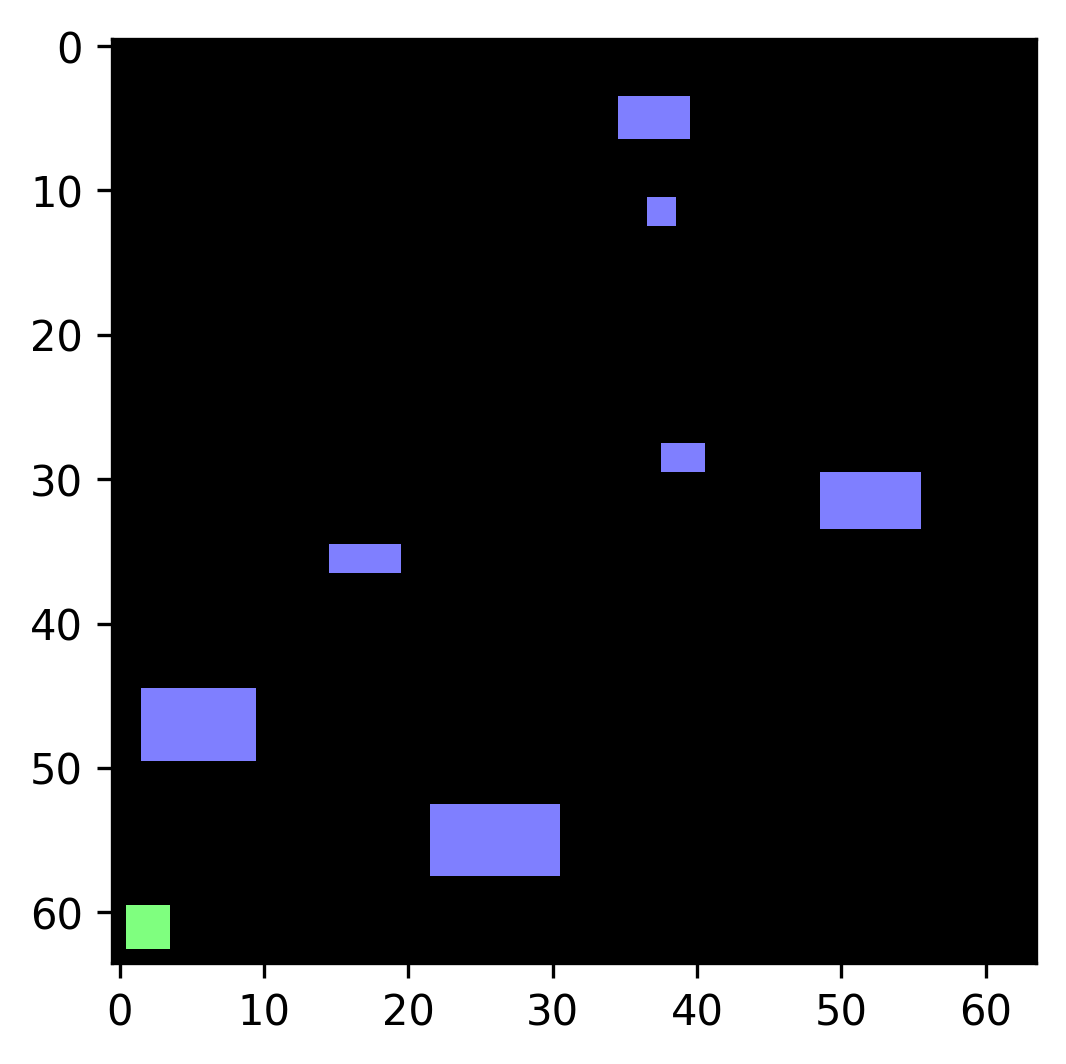

(3, 64, 64)


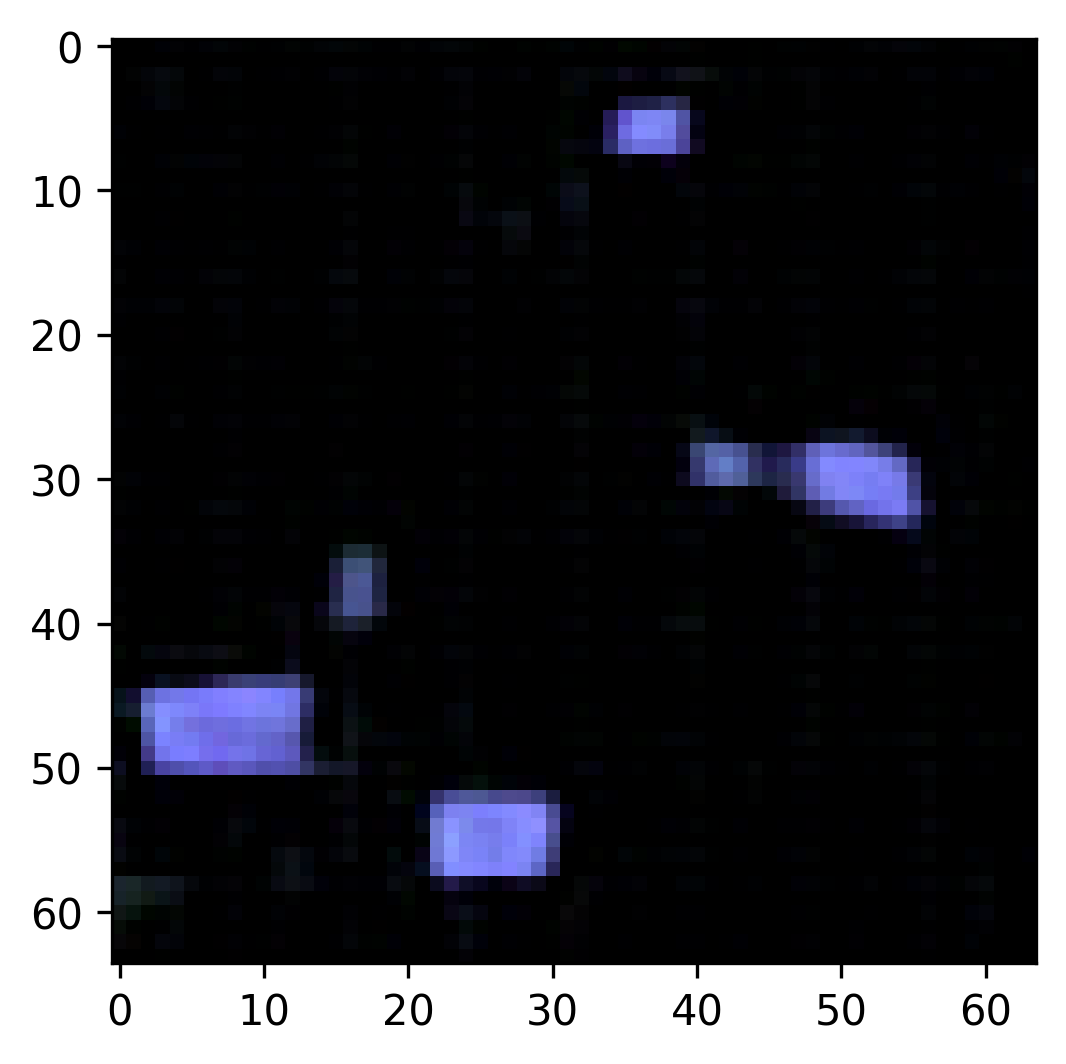

25
repr, std, cov, conv, closs 17.833627700805664 0.0003020763397216797 5.471520125865936e-08 0.008395884186029434 0.24967095255851746
repr, std, cov, conv, closs 18.1892032623291 0.0003025531768798828 2.2351741790771484e-08 0.008314435370266438 0.24956873059272766
repr, std, cov, conv, closs 18.69540023803711 0.00030231475830078125 1.7695128917694092e-08 0.009243380278348923 0.24862352013587952
repr, std, cov, conv, closs 19.259143829345703 0.00030231475830078125 1.4901161193847656e-08 0.009756326675415039 0.2502894997596741
repr, std, cov, conv, closs 18.733251571655273 0.00030231475830078125 3.050081431865692e-08 0.00852237083017826 0.2511049509048462
repr, std, cov, conv, closs 19.11946678161621 0.00030231475830078125 3.748573362827301e-08 0.008437399752438068 0.24982869625091553
repr, std, cov, conv, closs 19.177255630493164 0.0003020763397216797 4.7264620661735535e-08 0.009221790358424187 0.2515559494495392
repr, std, cov, conv, closs 19.52837562561035 0.0003020763397216797 5.168

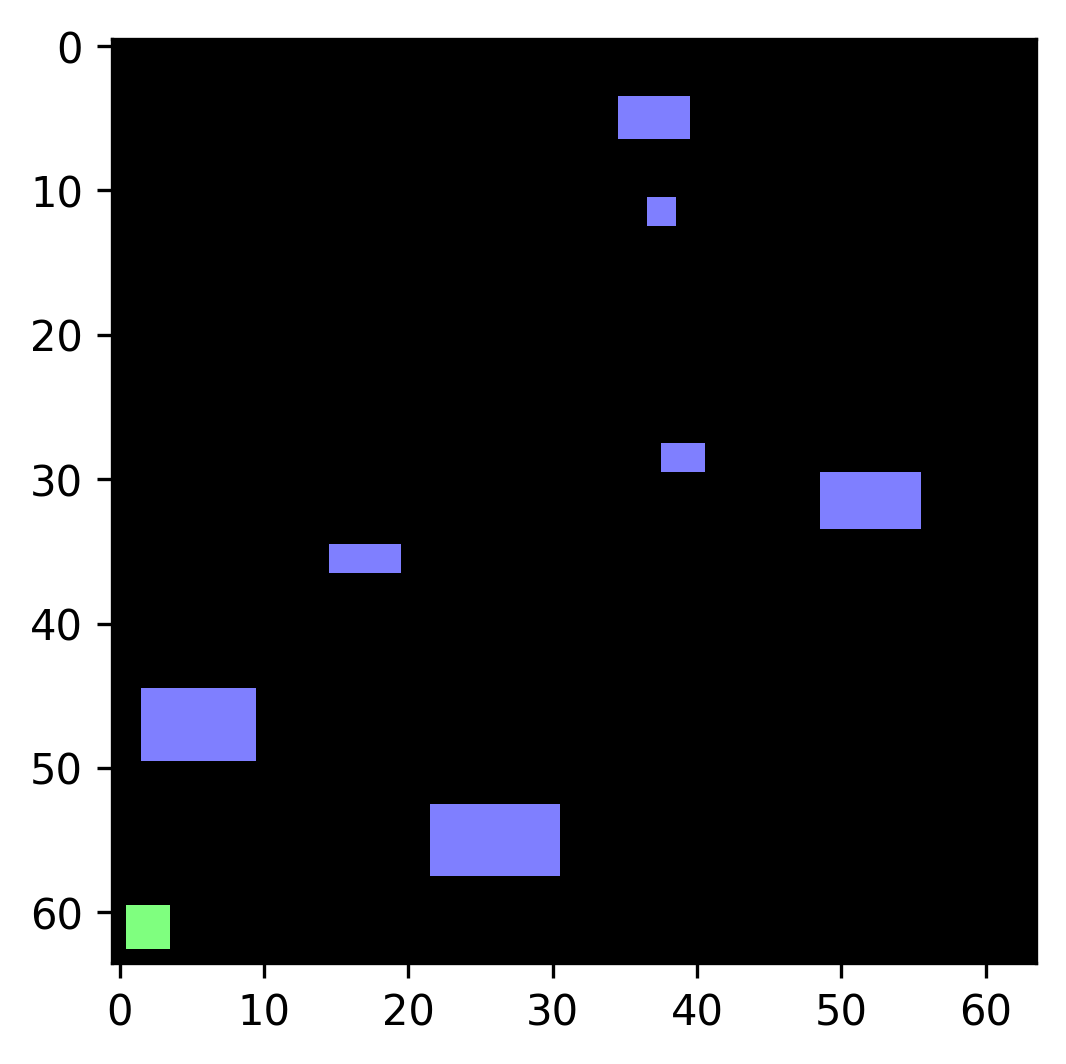

(3, 64, 64)


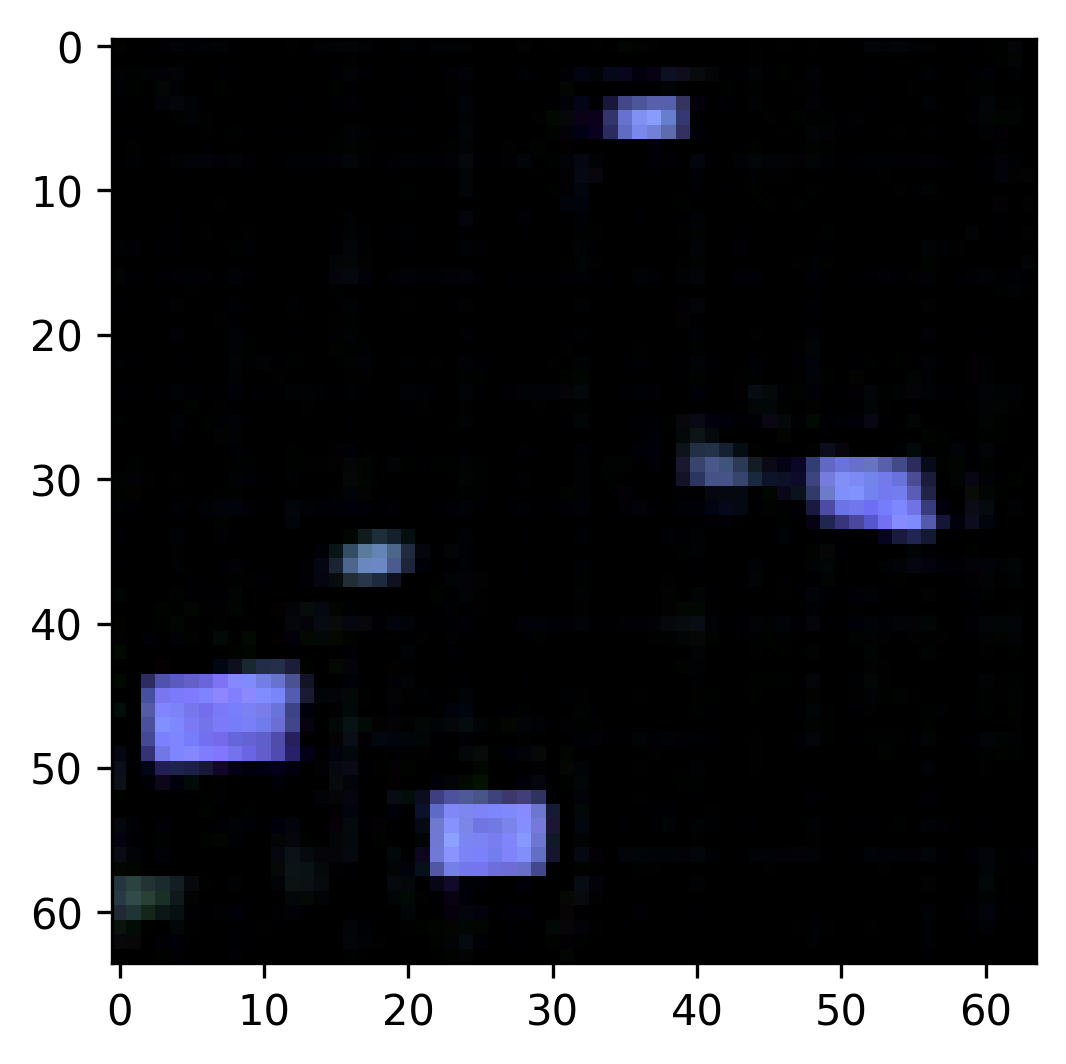

26
repr, std, cov, conv, closs 20.08480453491211 0.0002956390380859375 1.4668330550193787e-08 0.010115395300090313 0.25036901235580444
repr, std, cov, conv, closs 19.88498306274414 0.00029540061950683594 1.862645149230957e-08 0.008058412931859493 0.24985221028327942
repr, std, cov, conv, closs 19.448020935058594 0.00029540061950683594 2.9569491744041443e-08 0.008801133371889591 0.24944263696670532
repr, std, cov, conv, closs 19.72135353088379 0.0002951622009277344 6.495974957942963e-08 0.008724487386643887 0.25055158138275146
repr, std, cov, conv, closs 19.341703414916992 0.00029468536376953125 9.150244295597076e-08 0.00857070367783308 0.25006812810897827
repr, std, cov, conv, closs 19.555530548095703 0.00029397010803222656 1.026783138513565e-07 0.007964661344885826 0.24875357747077942
repr, std, cov, conv, closs 19.182653427124023 0.00029349327087402344 6.076879799365997e-08 0.009212236851453781 0.2501055598258972
repr, std, cov, conv, closs 19.43915367126465 0.00029349327087402344 2.

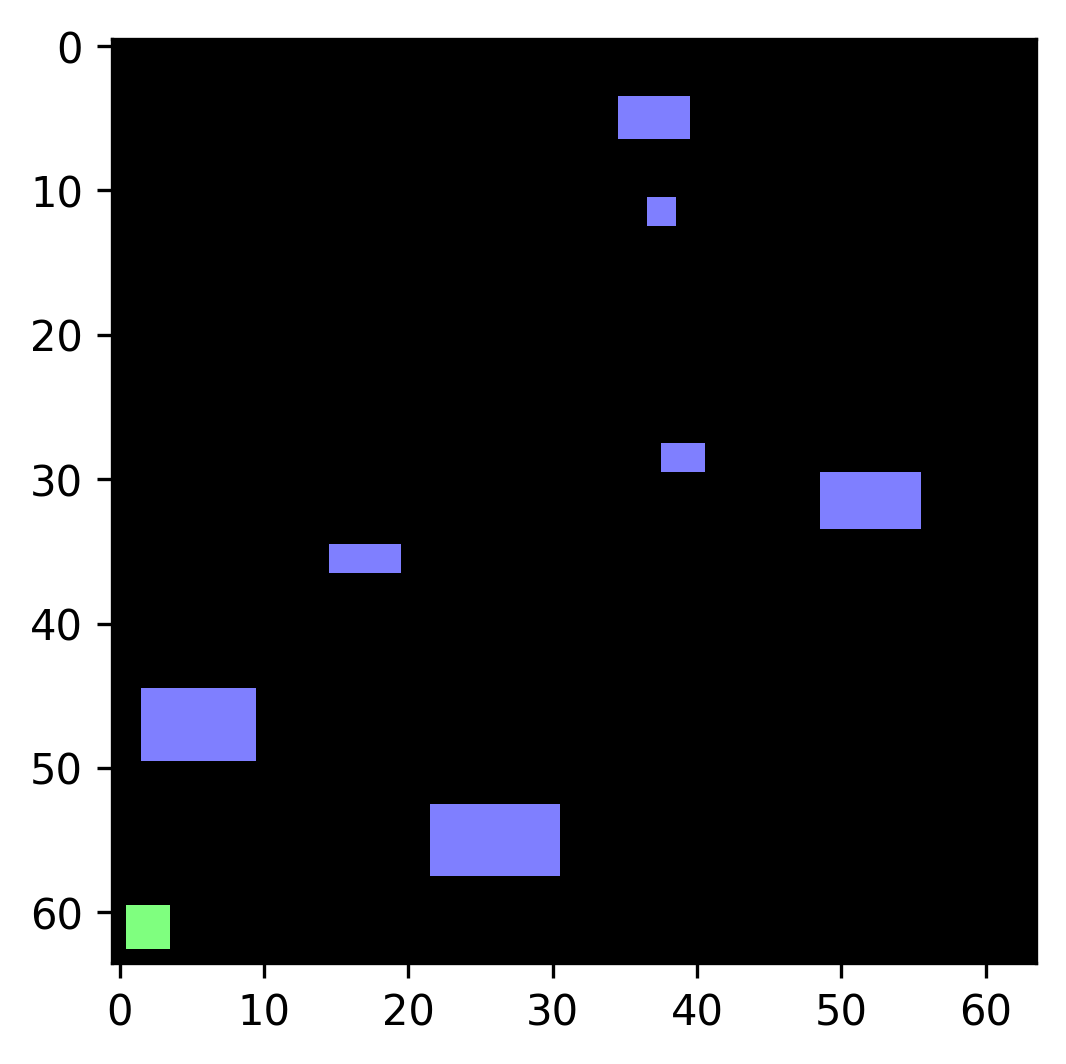

(3, 64, 64)


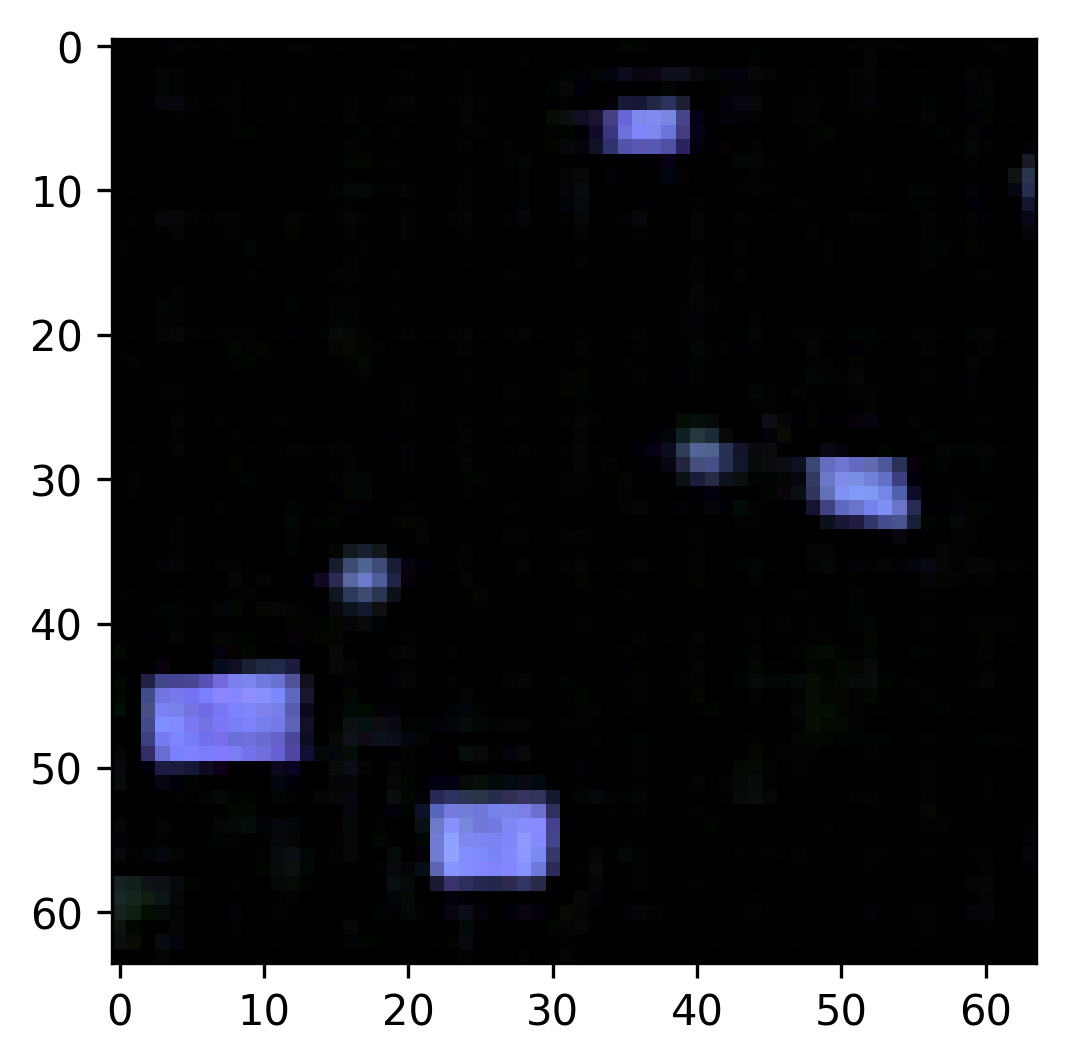

27
repr, std, cov, conv, closs 20.402067184448242 0.0002894401550292969 1.7462298274040222e-08 0.00865308940410614 0.24982374906539917
repr, std, cov, conv, closs 20.811105728149414 0.0002894401550292969 9.313225746154785e-09 0.009636916220188141 0.2512119710445404
repr, std, cov, conv, closs 20.739431381225586 0.0002894401550292969 1.4668330550193787e-08 0.008202561177313328 0.2471262663602829
repr, std, cov, conv, closs 20.828651428222656 0.0002892017364501953 2.6309862732887268e-08 0.008145847357809544 0.2463611364364624
repr, std, cov, conv, closs 20.674015045166016 0.0002892017364501953 3.259629011154175e-08 0.007644453551620245 0.24761520326137543
repr, std, cov, conv, closs 20.833864212036133 0.0002887248992919922 4.7963112592697144e-08 0.007969280704855919 0.25812944769859314
repr, std, cov, conv, closs 21.504331588745117 0.00028777122497558594 4.0279701352119446e-08 0.010118004865944386 0.24708305299282074
repr, std, cov, conv, closs 21.43771743774414 0.0002875328063964844 5.1

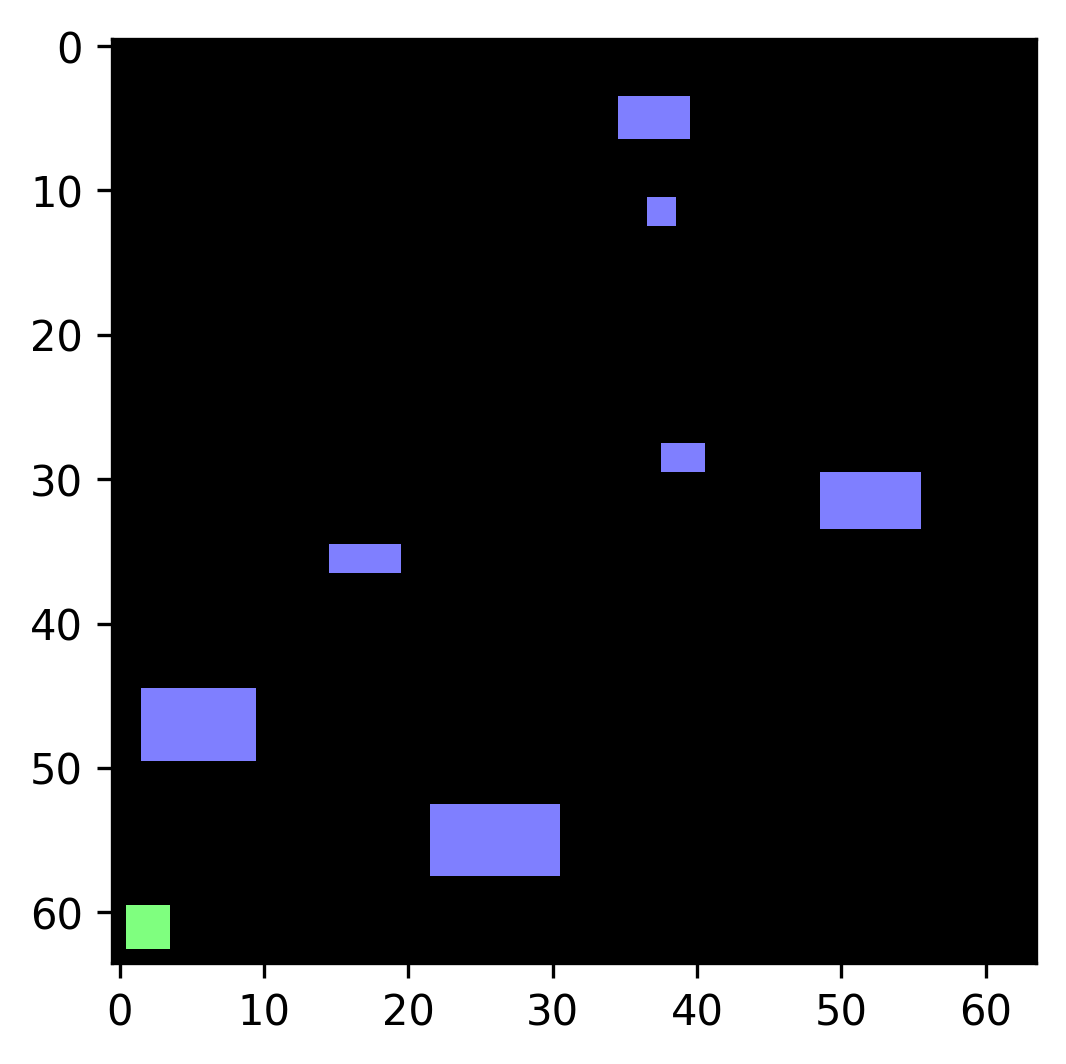

(3, 64, 64)


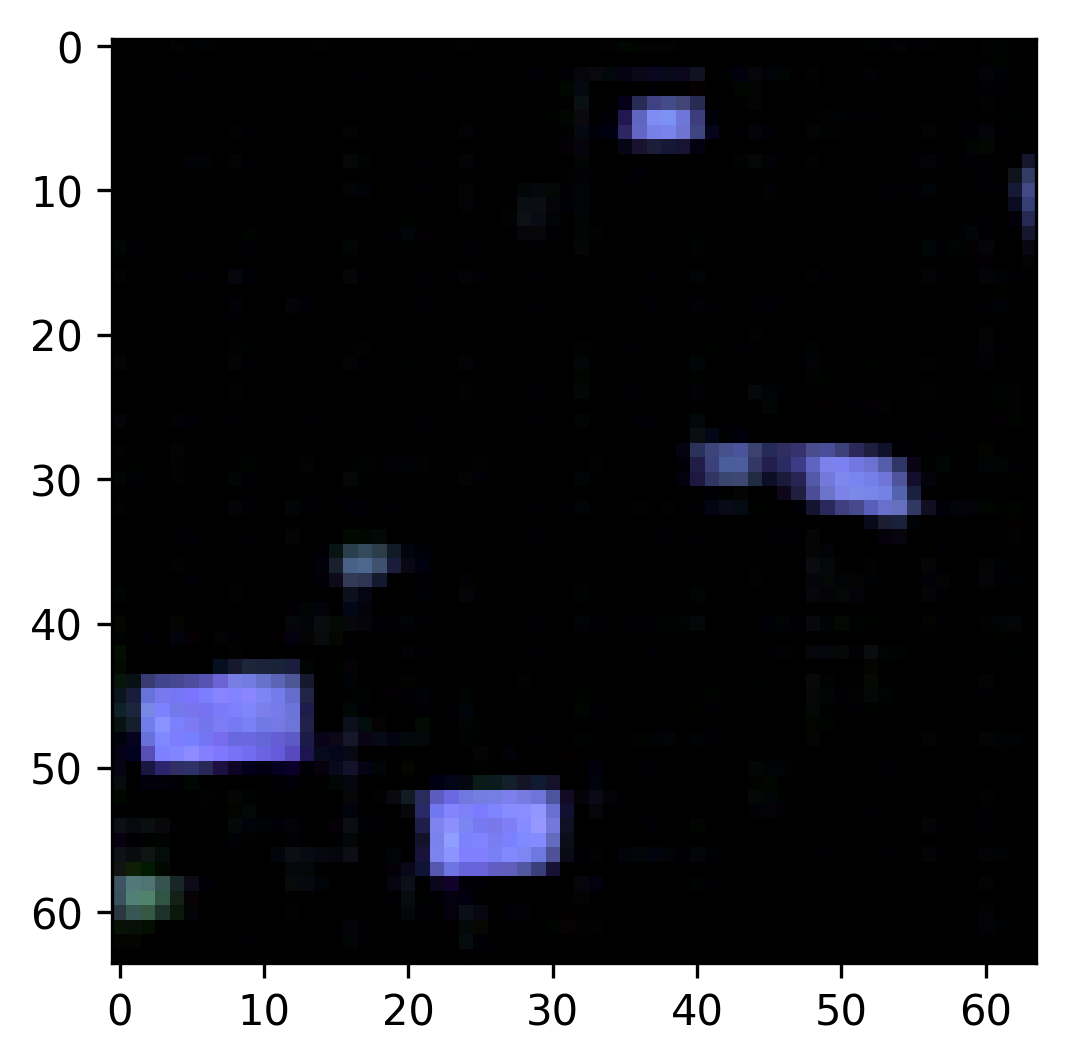

28
repr, std, cov, conv, closs 20.693016052246094 0.00028228759765625 7.334165275096893e-08 0.008057314902544022 0.2527238130569458
repr, std, cov, conv, closs 21.45524787902832 0.00028228759765625 3.3760443329811096e-08 0.00819673202931881 0.24236229062080383
repr, std, cov, conv, closs 21.235031127929688 0.00028228759765625 1.1874362826347351e-08 0.009584436193108559 0.2588213086128235
repr, std, cov, conv, closs 21.47044563293457 0.00028228759765625 1.0011717677116394e-08 0.00839855894446373 0.24999874830245972
repr, std, cov, conv, closs 21.95198631286621 0.00028228759765625 1.1641532182693481e-08 0.01016782782971859 0.2507595419883728
repr, std, cov, conv, closs 22.382644653320312 0.00028204917907714844 2.468004822731018e-08 0.009981485083699226 0.24760814011096954
repr, std, cov, conv, closs 21.77581787109375 0.0002818107604980469 3.236345946788788e-08 0.008053313940763474 0.24978265166282654
repr, std, cov, conv, closs 22.275819778442383 0.0002818107604980469 1.5366822481155396e

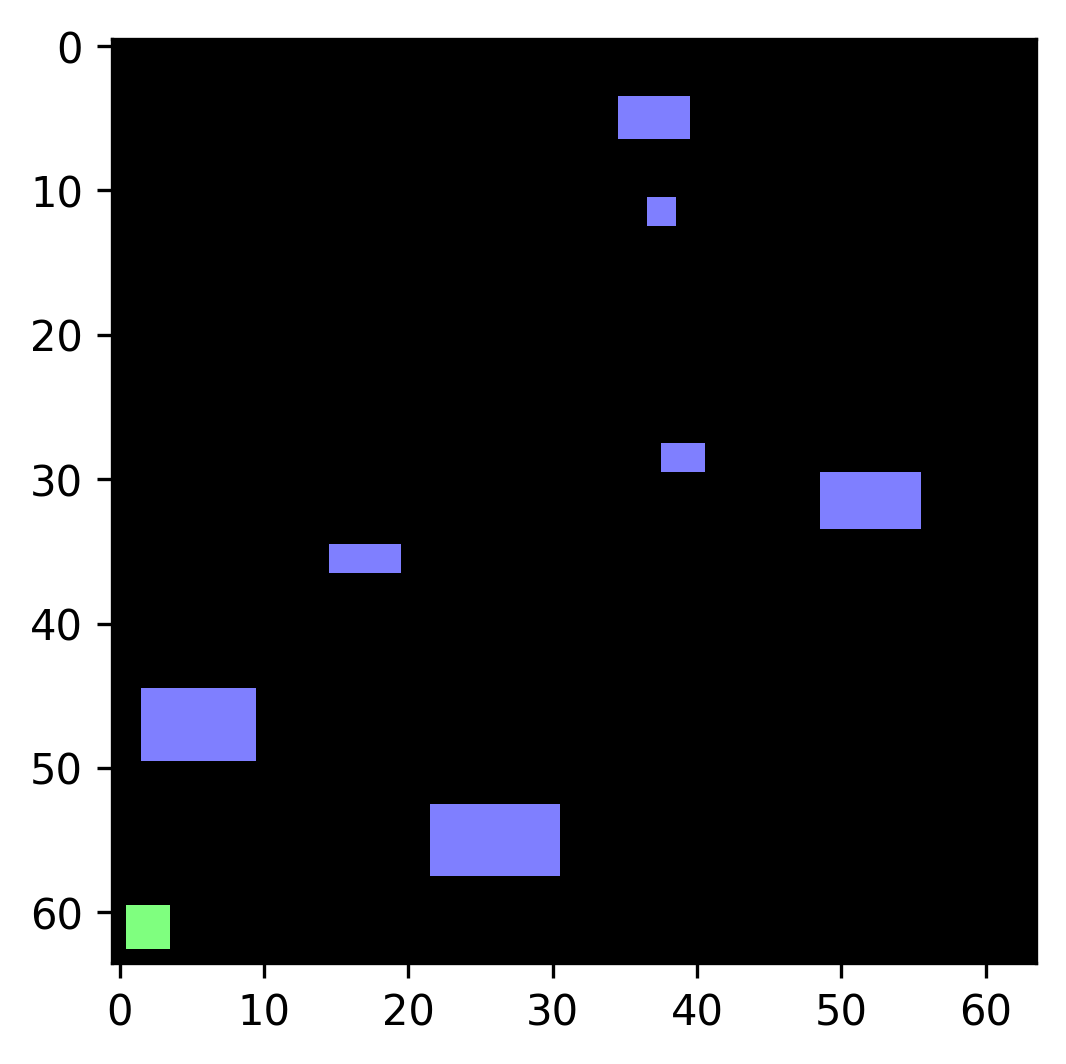

(3, 64, 64)


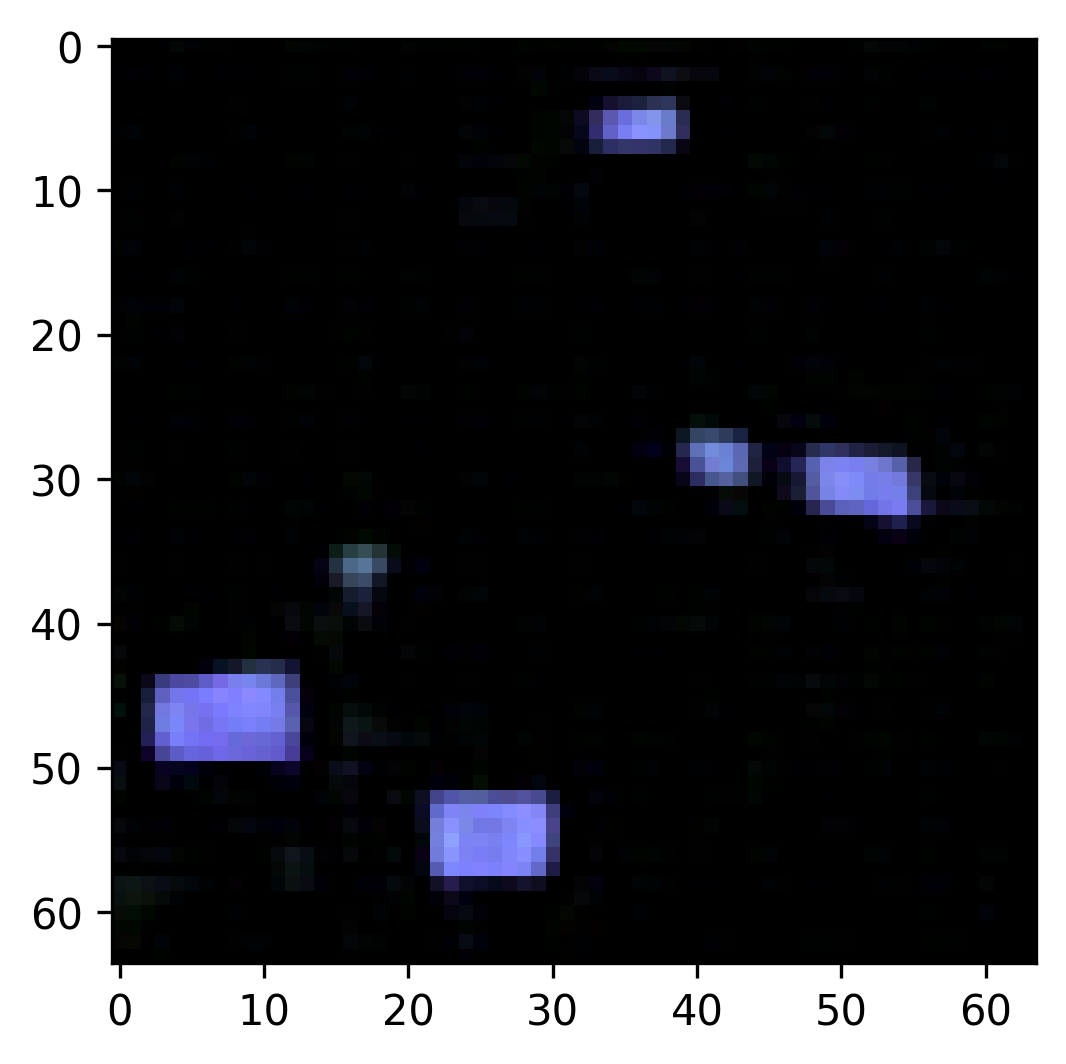

29
repr, std, cov, conv, closs 22.501394271850586 0.0002765655517578125 3.073364496231079e-08 0.008583798073232174 0.25386351346969604
repr, std, cov, conv, closs 23.470842361450195 0.0002765655517578125 2.8172507882118225e-08 0.01023002527654171 0.24857884645462036
repr, std, cov, conv, closs 22.705442428588867 0.0002760887145996094 2.0954757928848267e-08 0.009185880422592163 0.246351420879364
repr, std, cov, conv, closs 22.76778221130371 0.0002758502960205078 3.585591912269592e-08 0.007744062226265669 0.2505097985267639
repr, std, cov, conv, closs 23.292221069335938 0.0002758502960205078 2.3050233721733093e-08 0.00864548422396183 0.25279003381729126
repr, std, cov, conv, closs 22.864336013793945 0.0002758502960205078 2.0954757928848267e-08 0.007706387899816036 0.24911651015281677
repr, std, cov, conv, closs 22.094322204589844 0.00027561187744140625 2.6775524020195007e-08 0.007809044327586889 0.2500777244567871
repr, std, cov, conv, closs 22.436098098754883 0.0002753734588623047 1.676

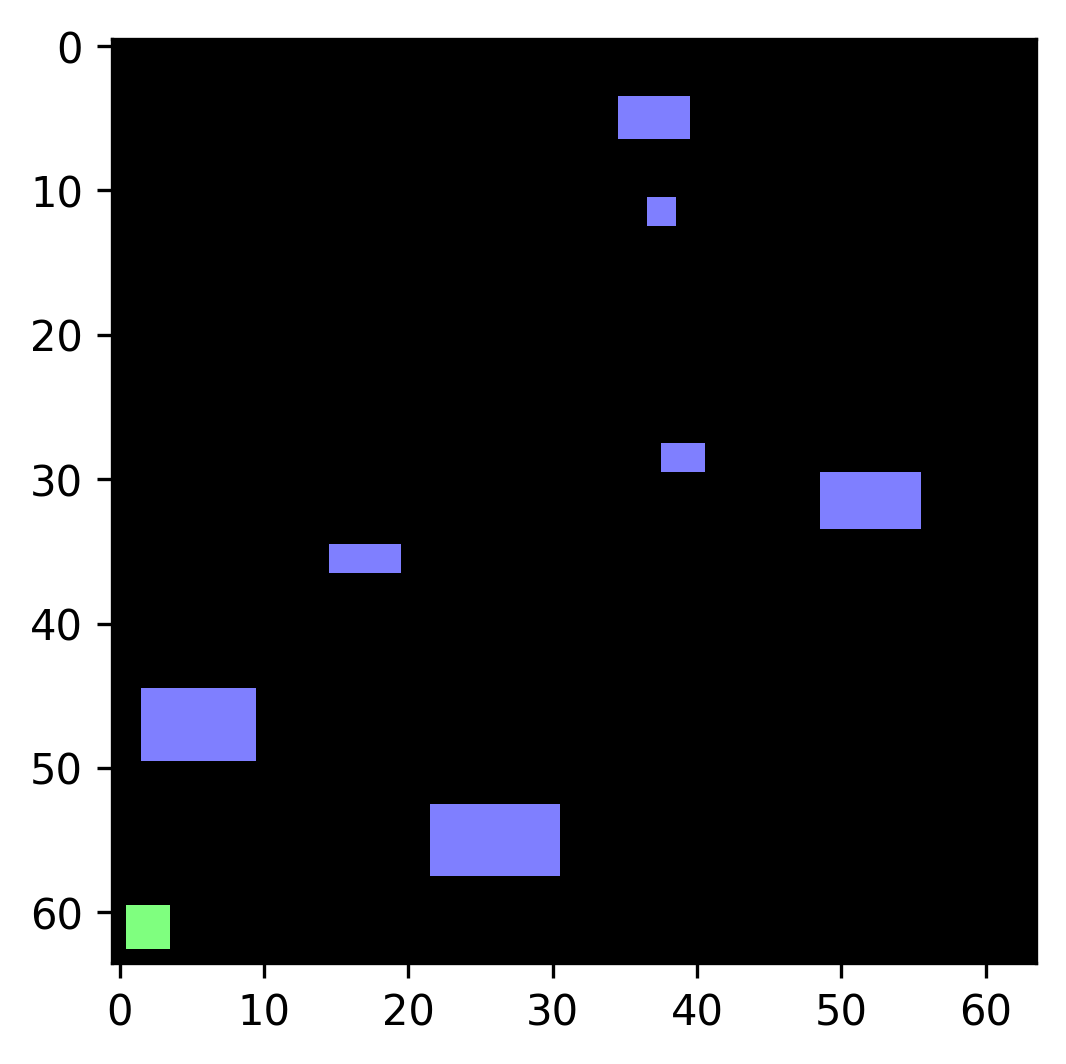

(3, 64, 64)


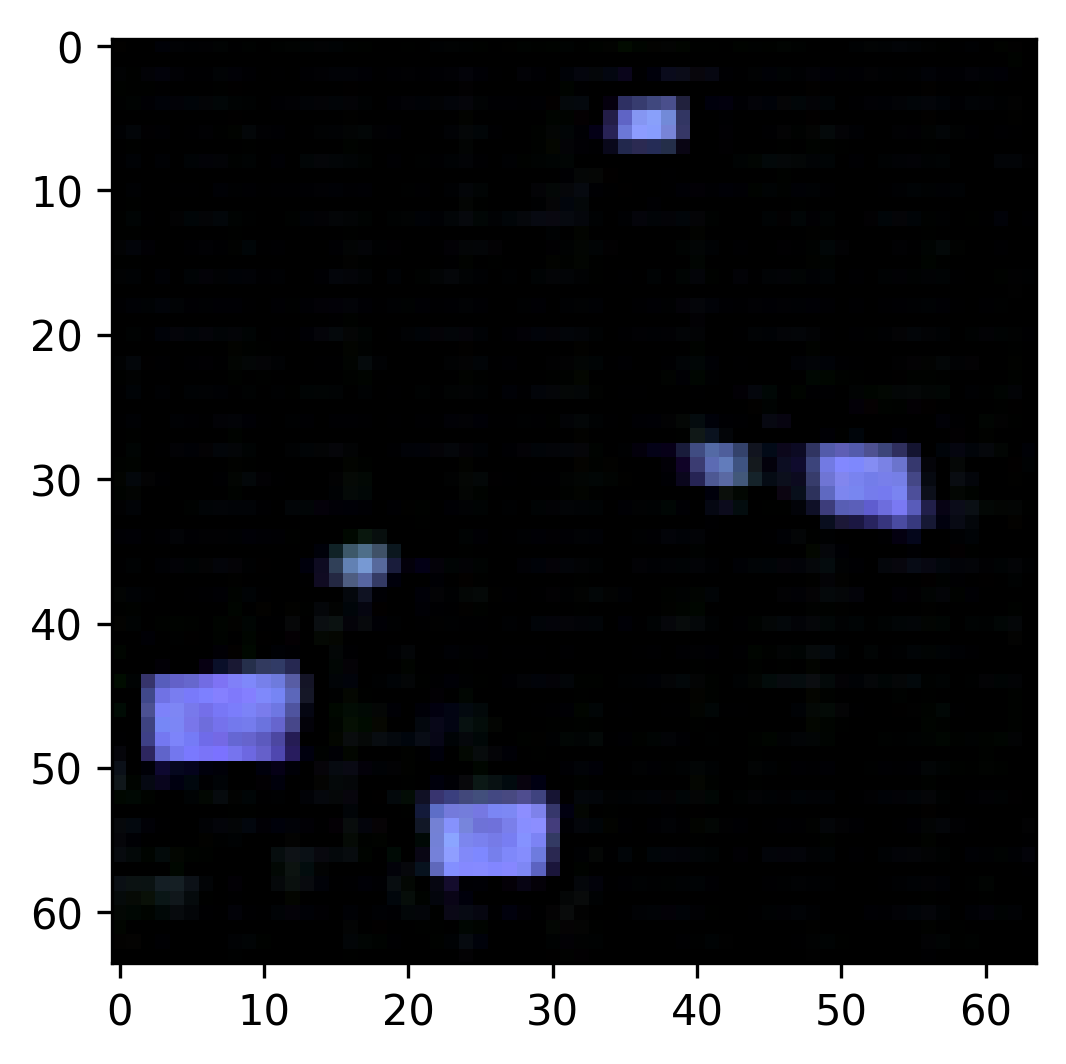

In [20]:
from matplotlib import pyplot as plt
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(4, 4))
    print(npimg.shape)
    # plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

import torchvision.transforms.v2 as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


for i in range(30):
    print(i)
    # agent.train_ae(train_loader, optim)
    # agent.train_jepa(train_loader, optim)
    agent.train_jepa(train_loader, c_loader, optim)

    state = buffer[7][80][0]
    state = transform(state).unsqueeze(0).to(device)[0]
    sx_ = agent.jepa.enc(state.unsqueeze(0))
    out= agent.deconv(sx_).squeeze(0)
    print(out.shape)
    imshow(state.detach().cpu())
    imshow(out.detach().cpu())

# 10 epochs 15m23s


In [ ]:
state = buffer[7][80][0]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
state = transform(state).unsqueeze(0).to(device)[0]
sx_ = agent.jepa.enc(state.unsqueeze(0))
out= agent.deconv(sx_).squeeze(0)
print(out.shape)
imshow(state.detach().cpu())
imshow(out.detach().cpu())

In [ ]:
# @title simulate 4
from google.colab.patches import cv2_imshow
import cv2
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# buffer=[]

def simulate(agent, buffer=[]):
    # out = cv2.VideoWriter('video.avi', cv2.VideoWriter_fourcc(*'DIVX'), 20, (64,64))
    out = cv2.VideoWriter('video{}.avi'.format(time.time()), cv2.VideoWriter_fourcc(*'DIVX'), 20, (64,64))
    state = env.reset()
    episode=[]
    act=[]
    while True:
    # while not done:
        state = transform(state).unsqueeze(0).to(device)
        # action = agent(state).cpu() # https://github.com/openai/procgen/blob/master/procgen/env.py#L155
        if len(act)<=0: act = agent(state).cpu()[:1].tolist()
        action = act.pop(0)
        state, reward, done, info = env.step(action) # np(64,64,3) 0.0 False {'prev_level_seed': 736820912, 'prev_level_complete': 0, 'level_seed': 736820912, 'rgb': array([[[  0, 125, 222], ...)
        # print(i, 'act: ',action.item(), 'reward: ',reward)
        out.write(state)
        if done:
            episode.append((state, action, -1))
            print("ded")
            break
        episode.append((state, action, 0))
    print('time')
    env.close()
    out.release()
    cv2.destroyAllWindows()
    buffer.append(episode)
    return buffer

buffer = simulate(agent, buffer)
# _=simulate(agent)



In [ ]:
# @title wwwwwwwwwwww
for i in range(10):
    # # buffer=[]
    # print("#### simulate ####")
    # buffer = simulate(agent, buffer)

    print(i,"#### train ####")
    # train_data = BufferDataset(buffer, seq_len) # one line of poem is roughly 50 characters
    # train_loader = DataLoader(train_data, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 2, drop_last=True) # num_workers = 4
    agent.train_jepa(train_loader, optim)

# repr, std, cov 0.009419754147529602 0.478271484375 0.005037273280322552


In [ ]:
!ffmpeg -hide_banner -loglevel error -i video.avi video.mp4 -y
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4', "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""<video width=400 controls autoplay><source src="{data_url}" type="video/mp4"></video>""")

###save

In [ ]:
# @title test search, argm
# # def search(self, sx, T=None, bptt=None):
T=20
bptt=None
if T==None: T = 256
if bptt==None: bptt = min(T,32)
d_model=agent.d_model
# sx=torch.randn((1, d_model), device=device)
# batch=sx.size(dim=0)
batch=32
# scale = torch.sqrt(torch.tensor((d_model,), device=device))

# x_ = torch.rand((batch, T, 3),device=device)
# x_ = torch.rand((batch, T, 3),device=device)*4 -2
# x_ = torch.rand((batch, T, 3),device=device)*3 -1.5
# x_ = torch.rand((batch, T, 3),device=device)*2 -1
# *self.dim_z**(-0.5) # 1/d^(1/2)
# x_ = torch.zeros((batch, T, 3),device=device) # dont, deterministic, stuck
x=nn.Parameter(x_.clone())
# optim = torch.optim.SGD([x], lr=1e3, momentum=0.9)
optim = torch.optim.SGD([x], lr=1e2)
optim = torch.optim.SGD([x], lr=1e5)
# optim = torch.optim.SGD([x], lr=3e2)
# optim = torch.optim.AdamW([x], lr=3e2)
# optim = torch.optim.AdamW([x], lr=1e5)

# xx = torch.split(x, bptt, dim=1)
# for _ in range(10): # num epochs
#     sx_ = sx.detach()
#     # print(sx_[0][:10])
#     for xxx in xx: # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
#         la, lact = quantizer(x) # xhat, indices [batch_size, T, num_levels], [batch_size, T]
#         print(lact)
#         loss, sx_ = agent.rnn_pred(sx_, la)
#         loss.backward()
#         optim.step()
#         optim.zero_grad()
#         sx_ = sx_.detach()
#         print("search",loss.item())


# argm
# sx = torch.rand((batch, d_model),device=device)*2 -1
# sy = torch.rand((batch, d_model),device=device)*2 -1
# a = torch.rand((batch, agent.dim_a),device=device)*2 -1
# z_ = torch.rand((batch, agent.dim_z),device=device)*2 -1
# # z_ = torch.rand((batch, agent.dim_z),device=device)
# # z_ = z_/scale

z=nn.Parameter(z_.clone()) # argm 0.38188403844833374 3.86767578125
# torch.nn.init.zeros_(z)
torch.nn.init.xavier_uniform_(z)
# print(z)
# optim = torch.optim.SGD([z], lr=1e2, momentum=0.9)
# optim = torch.optim.SGD([z], lr=1e4)
optim = torch.optim.SGD([z], lr=3e3)
# optim = torch.optim.SGD([z], lr=3e1)
# optim = torch.optim.AdamW([z], lr=3e-1)
lossfn = torch.nn.MSELoss()
num_steps = 100
agent.jepa.eval()
import time
start=time.time()
for i in range(num_steps):
    sxaz = torch.cat([sx, a, z], dim=-1)
    # loss, sx = agent.rnn_pred(sx, la)s
    sy_ = agent.jepa.pred(sxaz)
    # print("y_, y",y_.shape, y.shape)
    loss = lossfn(sy_, sy)
    loss.backward()
    optim.step()
    optim.zero_grad()
    print("argm",loss.item(), z[0].item())
# print(time.time()-start)
print(z.squeeze())

want z around [-1,1], large lr, few steps, punish large z


In [12]:
# @title wandb
# https://docs.wandb.ai/quickstart
!pip install wandb
import wandb
wandb.login() # 487a2109e55dce4e13fc70681781de9f50f27be7
run = wandb.init(
    project="procgen",
    config={
        "model": "res18",
    })


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.8 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bobdole. Use `wandb login --relogin` to force relogin


In [ ]:
print(sum(p.numel() for p in agent.parameters() if p.requires_grad))
# 23921665 # agent # 6872065
# 12219840 # jepa # 3695040
# 24M params
# 24M * 3 * 4bytes
# 288MB

# 4 byte *3*64*64
# 4 *3*64*64 = 49152 # 1 img 50kb
# 64 img -> 3.2mb
# seq len 50 -> 160mb

# 64*64*3=12288
# 256*256=65536


6872065


In [ ]:
# @title gym
# https://gymnasium.farama.org/
# https://github.com/Farama-Foundation/Gymnasium
import gymnasium as gym
# env = gym.make("LunarLander-v2", render_mode="human")
env = gym.make("Pendulum-v1") # https://gymnasium.farama.org/environments/classic_control/pendulum/
observation, info = env.reset(seed=42)
for _ in range(1000):
   action = env.action_space.sample()  # this is where you would insert your policy
   observation, reward, terminated, truncated, info = env.step(action)

   if terminated or truncated:
      observation, info = env.reset()

env.close()

import torch
from vector_quantize_pytorch import FSQ

quantizer = FSQ(levels = [2]).to(device) # https://github.com/lucidrains/vector-quantize-pytorch/blob/master/vector_quantize_pytorch/finite_scalar_quantization.py



In [ ]:
# @title train test function
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()

def strain(dataloader, model, optimizer, scheduler=None, verbose=True):
    size = len(dataloader)
    model.train()
    loss_list = []
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        with torch.cuda.amp.autocast():
            x1, x2 = trs(x)
            loss = model.loss(x1,x2)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        optimizer.zero_grad()
        # model.conv_ema.update_parameters(model.conv)
        # model.exp_ema.update_parameters(model.exp)

        scaler.update()
        if scheduler is not None: scheduler.step()
        train_loss = loss.item()/len(y)
        loss_list.append(loss.item())
        try: wandb.log({"train loss": train_loss})
        except: pass
        if batch % (size//10) == 0:
            loss, current = loss.item(), batch
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_list

def train(dataloader, model, optimizer, scheduler=None, verbose=True):
    size = len(dataloader)
    model.train()
    loss_list = []
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        x1, x2 = trs(x)
        loss = model.loss(x1,x2)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if scheduler is not None: scheduler.step()

        loss_list.append(loss.item())
        if batch % (size//10) == 0:
            loss, current = loss.item(), batch
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_list


# def ctrain(dataloader, model, loss_fn, optimizer, scheduler=None, verbose=True):
def ctrain(dataloader, model, loss_fn, optimizer, verbose=True):
    size = len(dataloader)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            x = model(x)
        pred = model.classify(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % (size//10) == 0:
        # if batch % 100 == 0:
            loss, current = loss.item(), batch * len(x)
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            x = model(x)
            pred = model.classify(x)
            loss = loss_fn(pred, y)
            # predicted, actual = classes[pred[0].argmax(0)], classes[y]
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss


In [ ]:
# @title rnn train, gen

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred,_ = model(X)
        loss = loss_fn(pred.reshape(-1,pred.shape[-1]), y.reshape(-1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss = loss.item()/ len(X)

        try: wandb.log({"train loss": train_loss})
        except: pass
        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def train(dataloader, model, loss_fn, optimizer, bptt=32):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # hid = model.init_hidden(bptt)
        hid = model.init_hidden(X.shape[0])
        X, y = X.to(device), y.to(device)
        # print("X.shape:",X.shape) # [batch_size, seq_len]
        Xs, ys = torch.split(X, bptt, dim=1), torch.split(y, bptt, dim=1)
        for (X, y) in zip(Xs, ys): # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
            optimizer.zero_grad()
            # print("X.shape:",X.shape) # [batch_size, bptt]
            pred, hid = model(X, hid)
            loss = loss_fn(pred.reshape(-1,pred.shape[-1]), y.flatten())
            # loss = loss_fn(pred.flatten(0,1), y.flatten())
            # loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            hid = hid.detach()

        train_loss = loss.item()/ len(X)
        try: wandb.log({"train loss": train_loss})
        except: pass
        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


import torch
from torch.nn import functional as F
def generate(model, context, max_steps = 64, temperature=1):
    # x = torch.tensor([train_dataset.stoi.get(c) for c in context], device=device).unsqueeze(0)
    x=ix = torch.tensor([train_dataset.stoi.get(c) for c in context], device=device).unsqueeze(0)
    model.eval()
    hidden=None
    with torch.no_grad():
        for n in range(max_steps):
            # output, hidden = model(x, hidden)
            output, hidden = model(ix, hidden)
            hidden=hidden[:, -1, :].unsqueeze(1)
            output = output[:, -1, :] # get logit for last character
            output = output/temperature
            output = F.softmax(output, dim = -1) # vocab_size to char
            ix = torch.multinomial(output, num_samples = 1) # rand sample by output distribution
            x = torch.cat((x, ix),1)
        completion = ''.join([train_dataset.itos[int(i)] for i in x.flatten()])
        return completion

# out=generate(model, "A wi")
# print(out)


In [ ]:
# @title simulate
from google.colab.patches import cv2_imshow
import cv2
# history = []
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

out = cv2.VideoWriter('video.avi', cv2.VideoWriter_fourcc(*'DIVX'), 20, (64,64))
buffer = []
state = env.reset()
done = False
while not done:
    state = transform(state).unsqueeze(0)
    action = agent(state) # https://github.com/openai/procgen/blob/master/procgen/env.py#L155
    state, reward, done, info = env.step(action) # np(64,64,3) 0.0 False {'prev_level_seed': 736820912, 'prev_level_complete': 0, 'level_seed': 736820912, 'rgb': array([[[  0, 125, 222], ...)
    # print(action.item(), reward)
    out.write(state)
    if done:
        buffer.append((state, action, reward-100))
        break
    buffer.append((state, action, reward))
env.close()
out.release()
cv2.destroyAllWindows()


In [ ]:
# @title mha
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.k = nn.Linear(d_model, d_model, bias=False)
        self.v = nn.Linear(d_model, d_model, bias=False)
        self.lin = nn.Linear(d_model, d_model)
        self.drop = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.tensor((self.head_dim,), dtype=torch.float, device=device))

    def forward(self, query, key, value, mask=None): # [batch_size, seq_len, d_model]
        batch_size = query.shape[0]
        Q = self.q(query).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2) # [batch_size, n_heads, seq_len, head_dim]
        K = self.k(key).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        V = self.v(value).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        # attn = torch.matmul(Q, K.transpose(2, 3)) / self.scale
        attn = Q @ K.transpose(2, 3) / self.scale # [batch_size, n_heads, seq_len, seq_len]
        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e10)
        attention = torch.softmax(attn, dim=-1)
        # x = torch.matmul(self.drop(attention), V)
        x = self.drop(attention) @ V # [batch_size, n_heads, seq_len, head_dim]
        x = x.transpose(1, 2).reshape(batch_size, -1, self.d_model) # [batch_size, seq_len, d_model]
        x = self.lin(x)
        return x, attention


class MHAme(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.k = nn.Linear(d_model, d_model, bias=False)
        self.v = nn.Linear(d_model, d_model, bias=False)
        self.lin = nn.Linear(d_model, d_model)
        self.drop = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.tensor((self.head_dim,), dtype=torch.float, device=device))

    def forward(self, query, key, value, mask=None): # [batch_size, seq_len, d_model]
        batch_size = query.shape[0]
        Q = self.q(query).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2) # [batch_size, n_heads, seq_len, head_dim]
        K = self.k(key).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        V = self.v(value).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        # attn = torch.matmul(Q, K.transpose(2, 3)) / self.scale
        attn = Q @ K.transpose(2, 3) / self.scale # [batch_size, n_heads, seq_len, seq_len]
        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e10)
        attention = torch.softmax(attn, dim=-1)
        # x = torch.matmul(self.drop(attention), V)
        x = self.drop(attention) @ V # [batch_size, n_heads, seq_len, head_dim]
        x = x.transpose(1, 2).reshape(batch_size, -1, self.d_model) # [batch_size, seq_len, d_model]
        x = self.lin(x)
        return x, attention

# @title test mha
# import torch
# batch_size=3
# L=5
# d_model=8
# n_heads=2

# trg = torch.rand(batch_size,L, d_model)
# src = torch.rand(batch_size,L, d_model)

# mha = MultiHeadAttention(d_model, n_heads)
# x, attn = mha(trg,src,src)

# head_dim = d_model // n_heads

# # trg1=trg.view(batch_size, -1, n_heads, head_dim).transpose(1, 2)
# trg=trg.view(batch_size, n_heads, -1, head_dim)
# src=src.view(batch_size, n_heads, -1, head_dim)
# # print(trg1)
# # print("##########")
# # print(trg2)
# attn = trg @ src.transpose(2, 3)
# x=attn@trg
# print(x.shape)
# print(attn.shape)

# # trg1=trg1.view(batch_size,L, d_model)
# trg1=trg1.reshape(batch_size,L, d_model)
# trg2=trg2.view(batch_size,L, d_model)
# print(trg1)
# print("##########")
# print(trg2)



In [ ]:
# @title simulate save
from google.colab.patches import cv2_imshow
import cv2

out = cv2.VideoWriter('video.avi', cv2.VideoWriter_fourcc(*'DIVX'), 20, (64,64))

# print(env.action_space)

state = env.reset()
done = False
while not done:
    # action = env.action_space.sample() # https://github.com/openai/procgen/blob/master/procgen/env.py#L155
    action = agent(state)
    state, reward, done, info = env.step(action)
    # print(state.shape) # 0-255 (64, 64, 3)
    print(action, reward, done)
    out.write(state)

    # break
    if done:
        break
env.close()
out.release()
cv2.destroyAllWindows()


In [ ]:
# @title autoencoder

class autoencoder(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.enc = get_res(d_model)
        # self.enc.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.enc.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        # self.enc = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
        #     nn.Conv2d(3, d_model, 1, 1, 1), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2), # 256
        #     nn.Conv2d(d_model, d_model, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
        #     nn.Conv2d(d_model, d_model, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
        #     nn.Conv2d(d_model, d_model, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
        #     nn.Conv2d(d_model, d_model, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
        #     nn.Conv2d(d_model, d_model, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
        #     # nn.Conv2d(d_model, 3, 3, 1, 1), nn.ReLU(), # 32
        # )
        # self.enc = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
        #     nn.Conv2d(3, d_model, 3, 2, 1), nn.ReLU(), # 256
        #     nn.Conv2d(d_model, d_model, 3, 2, 1), nn.ReLU(),
        #     nn.Conv2d(d_model, d_model, 3, 2, 1), nn.ReLU(),
        #     nn.Conv2d(d_model, d_model, 3, 2, 1), nn.ReLU(),
        #     nn.Conv2d(d_model, d_model, 3, 2, 1), nn.ReLU(),
        #     nn.Conv2d(d_model, d_model, 3, 2, 1), nn.ReLU(),
        #     # nn.Conv2d(d_model, 3, 3, 1, 1), nn.ReLU(), # 32
        # )
        self.deconv = Deconv(d_model)

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def encode(self, x): return self.enc(x).squeeze()
    # def decode(self, x): return self.deconv(x.unsqueeze(-1).unsqueeze(-1))
    def decode(self, x): return self.deconv(x)


device = "cuda" if torch.cuda.is_available() else "cpu"
model = autoencoder(256).to(device)
print(sum(p.numel() for p in model.enc.parameters() if p.requires_grad)) # res 2775104, convpool 2951424, stride 2957315
print(sum(p.numel() for p in model.deconv.parameters() if p.requires_grad)) # 2957315

input = torch.rand((4,3,64,64), device=device)
out = model.encode(input)
print(out.shape)
i2= model.decode(out)
print(i2.shape)



2775104
2362625
torch.Size([4, 256])
torch.Size([4, 1, 32, 32])


In [ ]:
# @title train autoencoder
# print(train_data.data)
# sar=train_data.data
# state, action, reward = zip(*sar)

# loader = DataLoader(state, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 2, drop_last=True) # num_workers = 4
# optim = torch.optim.AdamW(agent.parameters(), 1e-4, (0.9, 0.95)) # lr = 1e-4 #3e-4
optim = torch.optim.AdamW(model.parameters(), 3e-3, (0.9, 0.95)) # lr = 1e-3

def train(dataloader, model, optimizer, scheduler=None, verbose=True):
    size = len(dataloader)
    model.train()
    for batch, state in enumerate(dataloader):
        state = state.to(device)
        # sx_ = agent.jepa.enc(state)
        # state_ = agent.conv(sx_)
        state_ = model(state)
        loss = F.mse_loss(state_, state)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if scheduler is not None: scheduler.step()

        try: wandb.log({"loss": loss.item()})
        except: pass
        if batch % (size//10) == 0:
            loss, current = loss.item(), batch
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


for i in range(8):
    print(i)
    train(train_loader,model,optim)
    state = buffer[7][80][0]
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    state = transform(state).unsqueeze(0).to(device)[0]
    sx_ = model.encode(state.unsqueeze(0))
    out= model.decode(sx_)
    imshow(state.detach().cpu())
    imshow(out.detach().cpu())


In [ ]:
# @title text E norm (d/3)^(1/2)
# a=torch.rand(16, 1, 256)
# b=torch.tensor([])
# c=torch.cat((a,b),dim=1)

# a=torch.rand(16, 1, 1)
# b=torch.rand(16, 1, 256)
# # c=torch.bmm(a,b)
# c=a@b
# print(c.shape)

d=16
# a=torch.rand(d)/(d/3)**(1/2)
# a=torch.rand(d)*2-1
# # a=torch.rand(d,d)
# print(a)
# print(a.norm().item())

# w=torch.rand(d,d)*2-1
# w=(torch.rand(d,d)*2-1)*(3**0.5)/d
# print(w)
w = F.normalize(w)
k,v = torch.rand(1,d), torch.rand(1,d)
k,v = k*2-1, v*2-1
# k,v = F.normalize(k), F.normalize(v)
# print(k)
# print(k.T@v)
# print(k@v.T)
print((k.T@v).norm().item())
# print(w.norm().item())
# print(w[0].norm().item())
# print(w[:,0].norm().item())
# print((w@k.T).norm().item())

# (d/3)^(1/2) # E norm of dim d vec [0-1] or [-1-1]
# print(4/(3**0.5))
# k@v.T d/4 [0-1], 0 [-1-1],
# w norm: d^2 a^2 = print(16/(3**0.5))

# int int ab db da = int [1/2 a b^2] da = int 1/2 a da =
# 1/4



5.039520263671875


In [ ]:
# @title 514
n=100
a=torch.linspace(n,0,n)
i=0
o=0
# oo=[]
while True:
    m = torch.randint(0, n, (1,))
    a[m] = i
    o_=i-a.min()
    oo.append(o_.item())
    print(sum(oo)/len(oo))
    i+=1
# 514?
# p=1.064422028?


In [ ]:
n=100
tt=0
a=1+1/(n*(n-1))
print(a)
for i in range(n-1):
    a=(1+ 1/(n-i))*a
    print(a)
    tt+=a


In [ ]:
# @title augmentations
# https://github.com/facebookresearch/vicreg/blob/main/augmentations.py
import torch
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode

class TrainTransform(object):
    def __init__(self):
        self.transform = transforms.Compose([
                transforms.RandomResizedCrop(32, interpolation=InterpolationMode.BICUBIC),#224
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Lambda(lambda x : torch.clamp(x, 0., 1.)), # clamp else ColorJitter will return nan https://discuss.pytorch.org/t/input-is-nan-after-transformation/125455/6
                transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], p=0.8,),
                transforms.RandomGrayscale(p=0.2),
                transforms.RandomApply([transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),], p=1.0),
                # transforms.RandomSolarize(threshold=130, p=0.0)
                # transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        self.transform_prime = transforms.Compose([
                transforms.RandomResizedCrop(32, interpolation=InterpolationMode.BICUBIC),#224
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Lambda(lambda x : torch.clamp(x, 0., 1.)), # clamp else ColorJitter will return nan https://discuss.pytorch.org/t/input-is-nan-after-transformation/125455/6
                transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], p=0.8,),
                transforms.RandomGrayscale(p=0.2),
                transforms.RandomApply([transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),], p=0.1),
                # transforms.RandomSolarize(threshold=130/255, p=0.2) # og threshold=130, /255 bec after normalising
                transforms.RandomSolarize(threshold=.9, p=0.2),
                # transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
                # transforms.RandomPerspective(distortion_scale=0.3, p=0.5), # me
                # transforms.RandomErasing(p=0.5, scale=(0.1, 0.11), ratio=(1,1), value=0, inplace=True), # default p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False
        # dims = len(sample.shape)
        # if dims==3: x1 = self.transform(sample) # same transforms per minibatch
        # elif dims==4: x1 = transforms.Lambda(lambda x: torch.stack([self.transform(x_) for x_ in x]))(sample) # diff transforms per img in minibatch
    def __call__(self, sample):
        x1 = self.transform(sample)
        x2 = self.transform_prime(sample)
        return x1, x2

trs=TrainTransform()


In [ ]:
# @title vicreg next
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
from torch.optim.swa_utils import AveragedModel, get_ema_multi_avg_fn, update_bn # https://pytorch.org/docs/stable/optim.html#putting-it-all-together-ema


def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

# https://github.com/facebookresearch/vicreg/blob/main/resnet.py
class VICReg(nn.Module):
    def __init__(self, dim_embd=256, ema=False):
        super().__init__()
        self.conv = get_res(dim_embd=dim_embd)

        # f=[dim_embd,1024,1024,1024]
        # f=[dim_embd,512,512,512]
        f=[dim_embd,256,256,256]
        self.exp = nn.Sequential(
            nn.Linear(f[0], f[1]), nn.BatchNorm1d(f[1]), nn.ReLU(),
            nn.Linear(f[1], f[2]), nn.BatchNorm1d(f[2]), nn.ReLU(),
            nn.Linear(f[-2], f[-1], bias=False)
            )
        self.ema = ema
        if ema:
            self.conv_ema = AveragedModel(self.conv, multi_avg_fn=get_ema_multi_avg_fn(0.999))
            self.exp_ema = AveragedModel(self.exp, multi_avg_fn=get_ema_multi_avg_fn(0.999))

    # https://arxiv.org/pdf/2105.04906.pdf
    def vicreg(self, x, y): # https://github.com/facebookresearch/vicreg/blob/main/main_vicreg.py
        # invariance loss
        repr_loss = F.mse_loss(x, y) # s(Z, Z')

        x = x - x.mean(dim=0)
        y = y - y.mean(dim=0)

        # variance loss
        std_x = torch.sqrt(x.var(dim=0) + 0.0001) #ϵ=0.0001
        std_y = torch.sqrt(y.var(dim=0) + 0.0001)
        std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

        batch_size=x.size(dim=0)
        num_features=32
        sim_coeff=10.0 # 25.0 # λ
        std_coeff=10.0 # 25.0 # µ
        cov_coeff=1.0 # 1.0 # ν

        if x.dim() == 1: x = x.unsqueeze(0)
        if y.dim() == 1: y = y.unsqueeze(0)

        # # covariance loss
        cov_x = (x.T @ x) / (batch_size - 1) #C(Z)
        cov_y = (y.T @ y) / (batch_size - 1)
        cov_loss = off_diagonal(cov_x).pow_(2).sum().div(num_features)\
         + off_diagonal(cov_y).pow_(2).sum().div(num_features) #c(Z)
        loss = (sim_coeff * repr_loss + std_coeff * std_loss + cov_coeff * cov_loss)
        print("in vicreg ",(sim_coeff * repr_loss).item() , (std_coeff * std_loss).item() , (cov_coeff * cov_loss).item())
        return loss

    def loss(self, sx, sy):
        sx = self.forward(sx)
        sy = self.forward(sy)
        with torch.no_grad(): # target encoder is ema
            sy = self.conv_ema(sy)
            vy = self.exp_ema(sy)
        vx = self.exp(sx)
        vy = self.exp(sy)
        loss = self.vicreg(vx,vy)
        return loss

    def forward(self, x):
        return self.conv(x)


model = VICReg().to(device) # create an instance and move it to device (cache?)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 58.0MB/s]


In [ ]:
# @title simulate 512
from google.colab.patches import cv2_imshow
import cv2
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def simulate(agent, buffer=[]):
    out = cv2.VideoWriter('video.avi', cv2.VideoWriter_fourcc(*'DIVX'), 20, (64,64))
    state = env.reset()
    episode=[]
    while True:
    # while not done:
        # state = transform(state).unsqueeze(0).to(device)
        # action = agent(state).cpu() # https://github.com/openai/procgen/blob/master/procgen/env.py#L155
        # state, reward, done, info = env.step(action[0]) # np(64,64,3) 0.0 False {'prev_level_seed': 736820912, 'prev_level_complete': 0, 'level_seed': 736820912, 'rgb': array([[[  0, 125, 222], ...)
        action = env.action_space.sample() # https://github.com/openai/procgen/blob/master/procgen/env.py#L155
        state, reward, done, info = env.step(action)
        # print(i, 'act: ',action.item(), 'reward: ',reward)
        out.write(state)
        if done:
            episode.append((state, action, -1))
            # print("ded")
            break
        episode.append((state, action, 0))
    # print('time')
    env.close()
    out.release()
    cv2.destroyAllWindows()
    buffer.append(episode)
    return buffer

# buffer = simulate(agent, buffer)
# _=simulate(agent)

buffer=[]
for i in range(512):
    buffer = simulate(agent, buffer)



/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the envir

### trash

In [ ]:
# @title torch gru
# text_generation.ipynb https://colab.research.google.com/drive/1SguQZQYZBaalRuElJcxGdgF3YxhiwkAM
# RNNs.ipynb https://colab.research.google.com/drive/16DZRFsBEPMTHnjDED1xlxBDZpCmp5XGR

import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class gru(nn.Module):
    def __init__(self, emb_dim, rnn_units, num_layers):
        super().__init__()
        self.gru = nn.GRU(emb_dim, rnn_units, num_layers=num_layers, dropout=0.0, batch_first=True)
        self.dense = nn.Linear(rnn_units, vocab_size)
        self.rnn_units = rnn_units
        self.num_layers = num_layers

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.rnn_units, device=device) # https://pytorch.org/docs/stable/generated/torch.nn.GRU.html

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        if hidden is None: hidden = self.init_hidden(x.shape[0])
        # print('fwd',x.shape, hidden.shape) # fwd [batch_size, bptt, emb_dim], [num_layers, batch_size, rnn_units]
        output, hidden = self.gru(x, hidden)
        output = self.dense(output)
        return output, hidden


emb_dim = 256#256
rnn_units = 1024#1024
num_layers = 1
# model = gru(emb_dim, rnn_units, num_layers).to(device)
# model.summary()



In [ ]:
# @title ltm
import faiss
import numpy as np
import pickle
import torch

class Ltm():
    def __init__(self, ltmk=None, ltmv=None):
        self.index = None
        if ltmk is None:
            self.ltmk = torch.tensor([])
            self.ltmv = torch.tensor([])
        else:
            self.ltmk = ltmk # [len_ltm, d_model]
            self.ltmv = ltmv
        if len(self.ltmk)>=100:
            self.index = makefaissindex(ltmk)

    # def add(self, k, v):
    def add(self, k, v, mask=None):
        # self.ltmk.append(k)
        # self.ltmv.append(v)
        if k==None: return
        if k.ndim==1: k, v = k.unsqueeze(0), v.unsqueeze(0)
        if mask==None:
            self.ltmk = torch.cat([self.ltmk, k], dim=1)
            self.ltmv = torch.cat([self.ltmv, v], dim=1)
        else:
            self.ltmk[mask] = torch.cat([self.ltmk[mask], k], dim=1)
            self.ltmv[mask] = torch.cat([self.ltmv[mask], v], dim=1)
        if self.index:
            self.index.add(k)
            if torch.rand(1)<0.1:
                self.index.train(self.ltmk)

    def makefaissindex(self, vert_store):
        d = vert_store.shape[-1]
        nlist = 100
        index = faiss.IndexFlatL2(d) # no need train # 1-Flat.py
        index = faiss.IndexIVFFlat(index, d, nlist, faiss.METRIC_L2) # 2-IVFFlat.py
        if not index.is_trained: index.train(vert_store)
        index.add(vert_store)
        return index

    def vecsearch(self, query, k=5, treshold=36): # k nearest neighbors
        # index.nprobe = 5 # 1
        D, I = self.index.search(query, k) # dist, idx
        D, I = D[0], I[0]
        mask = I[D<treshold]
        return mask

    def __call__(self, query, k=5, treshold=36): # [batch_size, d_model]
        if self.index!=None and len(self.ltmk)>=100:
            mask = self.vecsearch(query, k, treshold)
            rag = self.ltmk[mask] # [len_rag, d_model]
        else:
            rag = self.ltmk
        if len(rag)==0: return 0
        # print("ltm call", query.shape, rag.shape)
        # attn = query @ rag.T # [batch_size, d_model] @ [d_model, len_ltm] = [batch_size, len_ltm]
        attn = query.unsqueeze(1) @ rag.transpose(-1,-2) # [batch_size, 1, d_model] @ [batch_size, d_model, len_ltm] = [batch_size, len_ltm]
        attention = torch.softmax(attn, dim=-1) # [batch_size, len_ltm]
        x = attention @ self.ltmv
        return x # [batch_size, d_model]

    def remove_ids(self, removing): # torch.tensor indexes
        mask = torch.ones(len(self.ltmk), dtype=torch.bool)
        mask[removing] = False
        self.ltmk, self.ltmv = self.ltmk[mask], self.ltmv[mask]
        if self.index: self.index = makefaissindex(ltmk)

    def save(file='ltm.pkl'):
        with open(file, 'wb') as f: pickle.dump((self.ltmk, self.ltmv), f)

    def load(file='ltm.pkl'):
        with open(file, 'rb') as f: self.ltmk, self.ltmv = pickle.load(f)

ltm = Ltm()


In [ ]:
# @title stm
import torch
import pickle

class Stm():
    def __init__(self, stmk=None, stmv=None, meta=None):
        self.stmk = stmk # [len_ltm, d_model]
        self.stmv = stmv
        self.meta = meta

    def __call__(self, query):
        # if len(rag)==0: return 0
        # print("stm call", query.shape, self.stmk.shape)
        # attn = query @ self.stmk.T # [batch_size, d_model] @ [d_model, len_ltm] = [batch_size, len_ltm]
        attn = query.unsqueeze(1) @ self.stmk.transpose(-1,-2) # [batch_size, d_model] @ [d_model, len_ltm] = [batch_size, len_ltm]
        attention = torch.softmax(attn, dim=-1) # [batch_size, len_ltm]
        x = attention @ self.stmv
        self.meta = self.meta + attn.squeeze() # attention
        return x # [batch_size, d_model]

    def add(self, k, v):
        if k.ndim==1:
            k=k.unsqueeze(0)
            v=v.unsqueeze(0)
        self.stmk = torch.cat([self.stmk, k], dim=1)
        self.stmv = torch.cat([self.stmv, v], dim=1)
        # self.meta = torch.cat([self.meta, torch.ones(1,1)], dim=-1)
        self.meta = torch.cat([self.meta, torch.ones(self.meta.shape[0],1)], dim=-1)
        # self.meta = torch.cat([self.meta, torch.ones(1)])

    def decay(self, g=0.9, k=256):
        self.meta = g*self.meta # decay
        mask = self.meta>0.001 # forget not retrieved
        self.stmk, self.stmv = self.stmk[mask], self.stmv[mask]
        self.meta = self.meta[mask]

        topk = torch.topk(self.meta, k)#, dim=None, largest=True, sorted=True
        self.meta = topk.values # cap stm size
        self.stmk, self.stmv = self.stmk[topk.indices], self.stmv[topk.indices]

    def pop(self, t=5):
        # if important long term, if
        mask = self.meta>t # to pop to ltm
        popk, popv = self.stmk[mask], self.stmv[mask]
        self.stmk, self.stmv = self.stmk[~mask], self.stmv[~mask]
        self.meta = self.meta[~mask]
        return popk, popv, mask.any(dim=-1)

    def save(file='stm.pkl'):
        with open(file, 'wb') as f: pickle.dump((self.stmk, self.stmv, self.meta), f)

    def load(file='stm.pkl'):
        with open(file, 'rb') as f: self.stmk, self.stmv, self.meta = pickle.load(f)



In [ ]:
# @title split params to train
# qkv for useful for critic predicting cost?

# train after each step: jepa(pred)(using SL)?

# train after each episode: critic, jepa()


# jepa is batch of same length episodes, take from history
# cost is single full episode buffer

# or combine string of episode buffers, batchify like rnn training


# batch_size = 64
# weights = torch.ones(len(buffer))#.expand(batch_size, -1)
# index = torch.multinomial(weights, num_samples=batch_size, replacement=False)
# buffer[index]


for name, p in agent.named_parameters():
    print(name, 'tcost' in name)
# https://pytorch.org/docs/stable/optim.html#per-parameter-options4
# optim.SGD([
#                 {'params': others},
#                 {'params': bias_params, 'weight_decay': 0}
#             ], weight_decay=1e-2, lr=1e-2)

tcost_params = [p for name, p in agent.named_parameters() if 'tcost' in name]
others = [p for name, p in agent.named_parameters() if 'tcost' not in name]

# # joptim = torch.optim.AdamW(agent.jepa.parameters(), lr=1e-3)
# joptim = torch.optim.AdamW([agent.jepa.parameters(),agent.q.parameters(), agent.k.parameters(), agent.v.parameters()], lr=1e-3)
# coptim = torch.optim.AdamW(agent.tcost.parameters(), lr=1e-3)
joptim = torch.optim.AdamW(tcost_params, lr=1e-3)
coptim = torch.optim.AdamW(others, lr=1e-3)
agent.train(buffer, joptim, coptim)


In [ ]:
# @title assorted
# print(type(buffer[0][0]))
# print(buffer[0][0])
# print(buffer[0][0].dtype)
import numpy as np

# b=np.random.randint(low=0, high=256, size=(1000, 64, 64, 3), dtype='uint8')
b=[np.random.randint(low=0, high=256, size=(64, 64, 3), dtype='uint8') for _ in range(1000)]
# print(b.shape)
# print(b[0])
def custom_collate(original_batch):
    return original_batch

train_data = BufferDataset(b, seq_len) # one line of poem is roughly 50 characters
train_loader = DataLoader(train_data, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 2) # num_workers = 4
# train_loader = DataLoader(train_data, shuffle = True, pin_memory = False, batch_size = batch_size, collate_fn=custom_collate) # num_workers = 4
# train_loader = DataLoader(test_dataset, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 0)

    # def plan(self, ): # mpc
    #     # xs, us = locuslab_mpc(x_init, goal_state, self.jepa)
    #     xs, us = locuslab_mpc(x_init, goal_state, self.jepa)

# def train_cost(self, dataloader, buffer, optim):

#         c = c + self.icost(world_state_) + reward
#         c_ = c_ + cost
#     closs = nn.MSELoss()(c,c_) # L1Loss MSELoss ; Sum reward
#     closs.backward()
#     optim.step()



In [ ]:
# @title custom transforms ToTensorme
import torchvision.transforms as transforms
# 100,3
# seq_len,
# for batch, Sar in enumerate(train_data):
for batch, Sar in enumerate(train_loader):
# for batch, (State, Action, Reward) in enumerate(train_loader):
# for batch, (Sar,_) in enumerate(train_loader):
    # print(len(Sar[0]))
    # print(Sar[0][0].shape)
    # State, Action, Reward = zip(*Sar)
    # State=Sar
    break
for s,a,r in zip(*Sar):
    state=s
    break
print(len(State))
print(len(State[0]))
print(type(State[0]))


# transforms.Lambda(lambda x : torch.clamp(x, 0., 1.)),

# def ToTensorme(x):
#     print("ToTensorme",type(x))
#     # if type(x) == np.ndarray: return x.astype(np.float32)
#     # if type(x) == np.ndarray: return torch.from_numpy(x).to(torch.float32)
#     # if type(x) == torch.Tensor: return x.permute(2,0,1).to(torch.float32)
#     if type(x) == torch.Tensor: return x.permute(0,3,1,2).to(torch.float32)
#     # if type(x) == torch.Tensor: return x.to(torch.float32)

# # transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# # transform = transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# transform = transforms.Compose([transforms.Lambda(ToTensorme), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# # transform = transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), transforms.Lambda(ToTensorme)])
# # https://pytorch.org/docs/stable/data.html#dataloader-collate-fn

print(State[0].shape)
# out=transform(State[0][0])
# out=transform(State[0])
# out=transform(list(State[0]))
# print(out)

# State = torch.tensor(State)
# print(State.shape)

# State[:,,]
# l=99
# lst=list(range(0,l,7))[1:]+[l]
# print(lst)


# b=[np.random.randint(low=0, high=256, size=(64, 64, 3), dtype='uint8') for _ in range(10)]
# for state in b:
#     transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#     transform(state)



50
16
<class 'torch.Tensor'>
torch.Size([16, 3, 64, 64])


In [ ]:
# @title batch pop to ltm
import torch
batch_size=8
d_model=4
# stmk=torch.rand(batch_size, 5, d_model)
# stmv=torch.rand(batch_size, 5, d_model)
# ltmk=torch.rand(batch_size, 5, d_model)
# ltmv=torch.rand(batch_size, 5, d_model)
# meta=torch.rand(batch_size, 5)*7
# mask = meta>5 # to pop to ltm
# popk, popv = stmk[mask], stmv[mask]
# print(popk.shape, popv.shape)
# stmk, stmv = stmk[~mask], stmv[~mask]
# meta = meta[~mask]
# # return popk, popv


# out=torch.rand(batch_size, 1, d_model)
out=[torch.rand(1, d_model) for _ in range(batch_size)]
lst=torch.rand(batch_size, 5, d_model)
mask=torch.rand(batch_size, 5) > 0.5
# out = torch.cat([out,lst[mask]], dim=1)
# batch, row = torch.where(mask)
# print(batch, row)
# out = torch.cat([out,lst[torch.where(mask)]], dim=1)
# print(out[batch].shape,lst[batch, row,:].shape)
# out[batch] = torch.cat([out[batch],lst[batch, row,:]], dim=1)
# out[batch] = torch.cat([out[batch],lst[batch, row,:].unsqueeze(1)], dim=1)

for b, m in enumerate(mask):
    # out[b] = torch.cat([out[b],lst[b][m]], dim=1)
    out[b] = torch.cat([out[b],lst[b][m]])



# num_masked = mask.sum(dim=1, keepdim=True)
# masked_elements = lst[torch.arange(lst.size(0))[:, None], mask]
# zeros = torch.zeros(batch_size, num_masked.max(), d_model)
# output = zeros.scatter(dim=1, index=masked_elements.nonzero(as_tuple=True)[1], src=masked_elements)
# torch.cat([out, output], dim=1)

# empty_mask = ~mask.any(dim=1)  # Find rows where all mask values are False
# padded_lst = torch.zeros(batch_size, 1, d_model)  # Create a zero tensor for padding
# padded_lst[~empty_mask] = lst[mask][~empty_mask]  # Fill non-empty masks with selected values
# out = torch.cat([out, padded_lst], dim=1)


# print(mask)
# print(mask[:, None])
# print(mask[:, None].expand(-1, lst.size(1), -1))

# out = torch.cat([out, lst[mask[:, None].expand(-1, lst.size(1), -1)]], dim=1)
# out = torch.cat([out, lst[mask[:, None]]], dim=1)

# print(out.shape)
print(out)


In [ ]:
# @title straight through estimator
class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return (input > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return F.hardtanh(grad_output)
